# 台灣各縣市高齡人口與長照資源供需分析

## 一、研究背景與動機

### 研究背景
近年來，台灣快速邁入超高齡社會，高齡人口比例持續攀升。根據內政部人口統計，我國自民國109年起自然增加率轉為負值，顯示出生人口已無法支撐死亡人口，人口老化已成為不可逆的趨勢。

在高齡人口不斷成長的情況下，長期照顧需求急速擴張。政府推動長照2.0政策雖大幅擴增服務項目與供給量，但受限於地理分布、人口結構差異、偏鄉交通不便，以及各縣市老化速度不同，全國長照資源仍呈現供需不均與地區差異顯著的現象。

### 研究目的
本研究旨在透過完整的量化資料與統計方法，系統性檢驗台灣各縣市長照資源配置，達成以下目標：

1. **檢驗高齡化程度與長照資源配置的關係**
2. **評估長照資源配置對服務充足度之改善效果**
3. **探討地理因素對長照服務可近性的影響**
4. **提供政策建議與實務應用方向**

---

## 二、環境設定與資料準備

In [366]:
# =========================
# 套件導入 | Package Imports
# =========================

# 資料處理套件 | Data Processing
import pandas as pd
import numpy as np
import warnings

# 視覺化套件 | Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
from math import pi

# 統計分析套件 | Statistical Analysis
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# 地圖視覺化套件 | Map Visualization
import folium
from folium import plugins

# 系統工具 | System Tools
import os
import json

# 設定 | Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.float_format", "{:.2f}".format)

print("✓ 套件導入完成 | Packages imported successfully")

✓ 套件導入完成 | Packages imported successfully


In [367]:
# =========================
# 中文字型設定 | Chinese Font Configuration
# =========================

print("正在設定中文字型 | Configuring Chinese fonts...")

# 設定字型路徑 | Set font path
noto_font_dir = "./fonts/Noto_Sans_TC/static"

if os.path.exists(noto_font_dir):
    font_files = {
        "Regular": os.path.join(noto_font_dir, "NotoSansTC-Regular.ttf"),
        "Bold": os.path.join(noto_font_dir, "NotoSansTC-Bold.ttf"),
        "Medium": os.path.join(noto_font_dir, "NotoSansTC-Medium.ttf"),
    }

    # 載入字型檔案 | Load font files
    for weight, font_path in font_files.items():
        if os.path.exists(font_path):
            font_manager.fontManager.addfont(font_path)
            print(f"  ✓ 已載入字型 | Font loaded: {weight}")

    # 設定 matplotlib 字型 | Configure matplotlib fonts
    plt.rcParams["font.sans-serif"] = ["Noto Sans TC", "Arial Unicode MS"]
    plt.rcParams["axes.unicode_minus"] = False
    print("✓ 字型設定完成 | Font configuration completed")
else:
    print(
        "⚠ 字型資料夾不存在，使用系統預設字型 | Font folder not found, using system default"
    )
    plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "PingFang TC", "Heiti TC"]
    plt.rcParams["axes.unicode_minus"] = False

# 設定 seaborn 主題 | Set seaborn theme
sns.set_theme(style="whitegrid", font="Noto Sans TC")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 100

print("\n中文測試 | Chinese test: 台灣長照資源分析 ✓")

正在設定中文字型 | Configuring Chinese fonts...
  ✓ 已載入字型 | Font loaded: Regular
  ✓ 已載入字型 | Font loaded: Bold
  ✓ 已載入字型 | Font loaded: Medium
✓ 字型設定完成 | Font configuration completed

中文測試 | Chinese test: 台灣長照資源分析 ✓


### 2.1 資料載入函數 | Data Loading Functions

In [368]:
def load_population_data(filepath):
    """
    載入並清理人口資料 | Load and clean population data

    參數 | Parameters:
        filepath (str): CSV檔案路徑 | CSV file path

    返回 | Returns:
        pd.DataFrame: 清理後的人口資料 | Cleaned population data
    """
    print(f"載入人口資料 | Loading population data: {filepath}")

    # 讀取CSV檔案 | Read CSV file
    df = pd.read_csv(filepath, encoding="utf-8")

    # 清理欄位名稱 | Clean column names
    df.columns = df.columns.str.strip()

    # 定義數值欄位 | Define numeric columns
    numeric_cols = [
        "總人口",
        "65～69",
        "70～74",
        "75～79",
        "80～84",
        "85～89",
        "90～94",
        "95～99",
        "100以上",
        "65以下",
    ]

    # 清理數值欄位：移除千分位符號、空白 | Clean numeric fields: remove commas and spaces
    for col in numeric_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(",", "")
                .str.replace(" ", "")
                .astype(float)
            )

    # 清理縣市名稱 | Clean city names
    df["區域別"] = df["區域別"].str.strip()

    # 計算65歲以上人口 | Calculate elderly population (65+)
    age_cols = [
        "65～69",
        "70～74",
        "75～79",
        "80～84",
        "85～89",
        "90～94",
        "95～99",
        "100以上",
    ]
    df["65歲以上"] = df[age_cols].sum(axis=1)

    # 計算老年人口比例 | Calculate elderly population ratio
    df["老年人口比例(%)"] = (df["65歲以上"] / df["總人口"]) * 100

    print(f"  ✓ 資料筆數 | Records: {len(df)}")
    print(f"  ✓ 縣市數量 | Cities: {df['區域別'].nunique()}")
    print(f"  ✓ 年份範圍 | Year range: {df['年份'].min()}-{df['年份'].max()}")

    return df


def load_ltc_data(filepath):
    """
    載入並清理長照據點資料 | Load and clean long-term care (LTC) facility data

    參數 | Parameters:
        filepath (str): CSV檔案路徑 | CSV file path

    返回 | Returns:
        pd.DataFrame: 清理後的長照據點資料 | Cleaned LTC data
    """
    print(f"載入長照據點資料 | Loading LTC data: {filepath}")

    # 讀取CSV檔案 | Read CSV file
    df = pd.read_csv(filepath, encoding="utf-8")

    # 建立縣市代碼對照表 | Create city code mapping
    city_code_mapping = {
        "63000": "台北市",
        "64000": "高雄市",
        "65000": "新北市",
        "66000": "台中市",
        "67000": "台南市",
        "68000": "桃園市",
        "10002": "宜蘭縣",
        "10004": "新竹縣",
        "10005": "苗栗縣",
        "10007": "彰化縣",
        "10008": "南投縣",
        "10009": "雲林縣",
        "10010": "嘉義縣",
        "10013": "屏東縣",
        "10014": "台東縣",
        "10015": "花蓮縣",
        "10016": "澎湖縣",
        "10017": "基隆市",
        "10018": "新竹市",
        "10020": "嘉義市",
        "09007": "連江縣",
        "09020": "金門縣",
    }

    # 清理縣市代碼 | Clean city codes
    df["縣市代碼"] = df["縣市"].astype(str).str.strip().str.replace('"', "")
    df["縣市名稱"] = df["縣市代碼"].map(city_code_mapping)

    # 清理據點類型 | Clean facility types
    df["據點類型"] = df["O_ABC"].astype(str).str.strip().str.replace('"', "")

    # 過濾有效資料 | Filter valid data
    df_valid = df[
        (df["縣市名稱"].notna()) & (df["據點類型"].isin(["A", "B", "C"]))
    ].copy()

    print(f"  ✓ 有效據點數 | Valid facilities: {len(df_valid)}")
    print(f"  ✓ 據點類型分布 | Facility type distribution:")
    print(df_valid["據點類型"].value_counts().to_string())

    return df_valid


def load_area_data(filepath, target_year=113):
    """
    載入並清理土地面積資料 | Load and clean land area data

    參數 | Parameters:
        filepath (str): CSV檔案路徑 | CSV file path
        target_year (int): 目標年份 | Target year

    返回 | Returns:
        pd.DataFrame: 清理後的面積資料 | Cleaned area data
    """
    print(f"載入土地面積資料 | Loading area data: {filepath}")

    # 讀取CSV檔案 | Read CSV file
    df = pd.read_csv(filepath, encoding="utf-8")

    # 清理縣市名稱 | Clean city names
    df["縣市"] = df["縣市"].str.strip().str.replace(" ", "").str.replace("　", "")

    # 清理面積數值 | Clean area values
    df["土地面積"] = (
        df["土地面積"]
        .astype(str)
        .str.replace(",", "")
        .str.replace(" ", "")
        .astype(float)
    )

    # 篩選目標年份 | Filter target year
    df_year = df[df["年份"] == target_year]

    # 彙總各縣市總面積 | Aggregate total area by city
    city_area = df_year.groupby("縣市")["土地面積"].sum().reset_index()
    city_area.columns = ["縣市名稱", "土地面積(km²)"]

    print(f"  ✓ 縣市數量 | Cities: {len(city_area)}")
    print(f"  ✓ 總面積 | Total area: {city_area['土地面積(km²)'].sum():.2f} km²")

    return city_area


print("✓ 資料載入函數定義完成 | Data loading functions defined")

✓ 資料載入函數定義完成 | Data loading functions defined


### 2.2 資料合併函數 | Data Merging Function

In [369]:
def merge_all_data(df_pop, df_ltc, df_area, target_year=113):
    """
    合併所有資料來源 | Merge all data sources

    參數 | Parameters:
        df_pop (pd.DataFrame): 人口資料 | Population data
        df_ltc (pd.DataFrame): 長照據點資料 | LTC data
        df_area (pd.DataFrame): 土地面積資料 | Area data
        target_year (int): 目標年份 | Target year

    返回 | Returns:
        pd.DataFrame: 合併後的完整資料 | Merged complete dataset
    """
    print(f"\n合併資料 | Merging data for year {target_year}...")

    # 彙總長照據點數 | Aggregate LTC facilities
    ltc_by_city = df_ltc.groupby(["縣市名稱", "據點類型"]).size().unstack(fill_value=0)
    ltc_by_city["總據點數"] = ltc_by_city.sum(axis=1)
    ltc_by_city = ltc_by_city.reset_index()

    # 篩選目標年份人口資料 | Filter population data for target year
    df_year = df_pop[df_pop["年份"] == target_year].copy()
    df_year["縣市名稱"] = df_year["區域別"].str.replace(" ", "")

    # 合併資料 | Merge datasets
    df_merged = df_year.merge(ltc_by_city, on="縣市名稱", how="left")
    df_merged = df_merged.merge(df_area, on="縣市名稱", how="left")

    # 填補缺失值 | Fill missing values
    facility_cols = ["A", "B", "C", "總據點數"]
    df_merged[facility_cols] = df_merged[facility_cols].fillna(0)

    # 計算衍生指標 | Calculate derived indicators
    df_merged["人口密度(人/km²)"] = df_merged["總人口"] / df_merged["土地面積(km²)"]
    df_merged["每千位高齡人口據點數"] = (
        df_merged["總據點數"] / df_merged["65歲以上"]
    ) * 1000
    df_merged["每平方公里據點數"] = df_merged["總據點數"] / df_merged["土地面積(km²)"]

    print(f"  ✓ 合併完成 | Merge completed")
    print(f"  ✓ 最終資料筆數 | Final records: {len(df_merged)}")
    print(f"  ✓ 欄位數 | Columns: {len(df_merged.columns)}")

    return df_merged


print("✓ 資料合併函數定義完成 | Data merging function defined")

✓ 資料合併函數定義完成 | Data merging function defined


### 2.3 資料來源視覺化 | Data Source Visualization

繪製台灣各縣市長照ABC據點分布地圖，以及據點數量統計圖表。

In [370]:
# =========================
# 建立台灣各縣市長照據點分布地圖 | Create Taiwan LTC Facilities Distribution Map
# =========================


def create_taiwan_ltc_map(df_ltc, df_merged):
    """
    建立台灣長照據點分布地圖 | Create Taiwan LTC facilities distribution map

    參數 | Parameters:
        df_ltc: 長照據點原始資料 | Raw LTC data
        df_merged: 合併後的完整資料 | Merged complete data
    """

    # 建立台灣地圖中心點 | Set Taiwan map center
    taiwan_center = [23.5, 121.0]

    # 建立基礎地圖 | Create base map
    m = folium.Map(location=taiwan_center, zoom_start=7, tiles="OpenStreetMap")

    # 定義縣市座標 (用於圓形標記) | Define city coordinates for circle markers
    city_coords = {
        "台北市": [25.0330, 121.5654],
        "新北市": [25.0120, 121.4659],
        "桃園市": [24.9937, 121.3010],
        "台中市": [24.1477, 120.6736],
        "台南市": [22.9998, 120.2269],
        "高雄市": [22.6273, 120.3014],
        "基隆市": [25.1276, 121.7392],
        "新竹市": [24.8138, 120.9675],
        "新竹縣": [24.8387, 121.0177],
        "苗栗縣": [24.5602, 120.8214],
        "彰化縣": [24.0518, 120.5161],
        "南投縣": [23.9609, 120.9719],
        "雲林縣": [23.7092, 120.4313],
        "嘉義市": [23.4801, 120.4491],
        "嘉義縣": [23.4518, 120.2554],
        "屏東縣": [22.5519, 120.5487],
        "宜蘭縣": [24.7021, 121.7377],
        "花蓮縣": [23.9871, 121.6015],
        "台東縣": [22.7972, 121.0713],
        "澎湖縣": [23.5712, 119.5793],
        "金門縣": [24.4489, 118.3765],
        "連江縣": [26.1605, 119.9495],
    }

    # 彙總各縣市據點統計 | Aggregate facility statistics by city
    city_stats = df_merged[
        ["縣市名稱", "A", "B", "C", "總據點數", "65歲以上", "每千位高齡人口據點數"]
    ].copy()

    # 定義顏色映射 (根據據點密度) | Define color mapping based on facility density
    max_density = city_stats["每千位高齡人口據點數"].max()
    min_density = city_stats["每千位高齡人口據點數"].min()

    def get_color(density):
        """根據據點密度返回顏色 | Return color based on density"""
        if pd.isna(density) or not np.isfinite(density):
            return "gray"
        elif density > max_density * 0.7:
            return "green"
        elif density > max_density * 0.4:
            return "orange"
        else:
            return "red"

    # 在地圖上標記各縣市據點 | Mark facilities on map
    for city, coords in city_coords.items():
        city_data = city_stats[city_stats["縣市名稱"] == city]

        if len(city_data) > 0:
            row = city_data.iloc[0]

            # 建立彈出視窗內容 | Create popup content
            popup_html = f"""
            <div style="font-family: 'Noto Sans TC', sans-serif; width: 200px;">
                <h4 style="margin: 0 0 10px 0; color: #2c3e50;">{city}</h4>
                <table style="width: 100%; border-collapse: collapse;">
                    <tr style="background-color: #ecf0f1;">
                        <td style="padding: 5px;"><b>總據點數</b></td>
                        <td style="padding: 5px; text-align: right;">{int(row["總據點數"])}</td>
                    </tr>
                    <tr>
                        <td style="padding: 5px;">　A級據點</td>
                        <td style="padding: 5px; text-align: right;">{int(row["A"])}</td>
                    </tr>
                    <tr style="background-color: #ecf0f1;">
                        <td style="padding: 5px;">　B級據點</td>
                        <td style="padding: 5px; text-align: right;">{int(row["B"])}</td>
                    </tr>
                    <tr>
                        <td style="padding: 5px;">　C級據點</td>
                        <td style="padding: 5px; text-align: right;">{int(row["C"])}</td>
                    </tr>
                    <tr style="background-color: #ecf0f1;">
                        <td style="padding: 5px;"><b>65歲以上人口</b></td>
                        <td style="padding: 5px; text-align: right;">{int(row["65歲以上"]):,}</td>
                    </tr>
                    <tr>
                        <td style="padding: 5px;"><b>每千位據點數</b></td>
                        <td style="padding: 5px; text-align: right;">{row["每千位高齡人口據點數"]:.2f}</td>
                    </tr>
                </table>
            </div>
            """

            # 計算圓圈大小 (根據總據點數) | Calculate circle size based on total facilities
            radius = np.sqrt(row["總據點數"]) * 2000

            # 決定顏色 | Determine color
            color = get_color(row["每千位高齡人口據點數"])

            # 添加圓形標記 | Add circle marker
            folium.CircleMarker(
                location=coords,
                radius=min(radius / 1000, 30),  # 限制最大半徑 | Limit max radius
                popup=folium.Popup(popup_html, max_width=300),
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.6,
                weight=2,
            ).add_to(m)

            # 添加縣市標籤 | Add city label
            folium.Marker(
                location=coords,
                icon=folium.DivIcon(
                    html=f"""
                    <div style="font-size: 10pt; color: black; font-weight: bold; 
                         text-shadow: 1px 1px 2px white, -1px -1px 2px white;">
                        {city}
                    </div>
                """
                ),
            ).add_to(m)

    # 添加圖例 | Add legend
    legend_html = """
    <div style="position: fixed; 
                bottom: 50px; right: 50px; width: 220px; height: 180px; 
                background-color: white; z-index:9999; font-size:12px;
                border:2px solid grey; border-radius: 5px; padding: 10px;
                font-family: 'Noto Sans TC', sans-serif;">
        <h4 style="margin: 0 0 10px 0;">長照據點密度</h4>
        <p style="margin: 5px 0;">
            <i style="background: green; width: 20px; height: 20px; 
               float: left; margin-right: 8px; opacity: 0.6;"></i>
            充足 (高密度)
        </p>
        <p style="margin: 5px 0;">
            <i style="background: orange; width: 20px; height: 20px; 
               float: left; margin-right: 8px; opacity: 0.6;"></i>
            中等
        </p>
        <p style="margin: 5px 0;">
            <i style="background: red; width: 20px; height: 20px; 
               float: left; margin-right: 8px; opacity: 0.6;"></i>
            不足 (低密度)
        </p>
        <hr style="margin: 10px 0;">
        <p style="margin: 5px 0; font-size: 10px;">
            ● 圓圈大小代表總據點數<br>
            ● 顏色代表每千位高齡人口據點數
        </p>
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))

    return m


print("✓ 地圖繪製函數定義完成 | Map plotting function defined")

✓ 地圖繪製函數定義完成 | Map plotting function defined


In [371]:
# =========================
# 繪製各縣市長照ABC據點數量堆疊長條圖 | Plot stacked bar chart of LTC ABC facilities
# =========================


def plot_ltc_facilities_by_city(df):
    """繪製各縣市長照ABC據點數量堆疊長條圖"""

    fig, ax = plt.subplots(figsize=(14, 10))

    # 排序資料 | Sort data
    df_sorted = df.sort_values("總據點數", ascending=True)

    # 準備資料 | Prepare data
    cities = df_sorted["縣市名稱"]
    a_count = df_sorted["A"]
    b_count = df_sorted["B"]
    c_count = df_sorted["C"]

    # 繪製堆疊長條圖 | Plot stacked bar chart
    bars1 = ax.barh(cities, a_count, label="A級據點", color="#1f77b4")
    bars2 = ax.barh(cities, b_count, left=a_count, label="B級據點", color="#ff7f0e")
    bars3 = ax.barh(
        cities, c_count, left=a_count + b_count, label="C級據點", color="#2ca02c"
    )

    # 添加總數標籤 | Add total labels
    for i, (city, total) in enumerate(zip(cities, df_sorted["總據點數"])):
        ax.text(total + 5, i, f"{int(total)}", va="center", fontsize=9)

    ax.set_xlabel("據點數量", fontsize=12)
    ax.set_title(
        "各縣市長照ABC據點數量分布（113年）", fontsize=14, fontweight="bold", pad=20
    )
    ax.legend(loc="lower right", fontsize=11)
    ax.grid(True, alpha=0.3, axis="x")

    plt.tight_layout()
    plt.show()


print("✓ 長條圖繪製函數定義完成 | Bar chart plotting function defined")

✓ 長條圖繪製函數定義完成 | Bar chart plotting function defined


### 2.4 執行資料載入與視覺化 | Execute Data Loading and Visualization

In [372]:
# =========================
# 載入資料 | Load Data
# =========================

# 載入人口資料 | Load population data
df_pop = load_population_data("程式用-縣市人口按性別及五齡組.csv")

# 載入長照據點資料 | Load LTC data
df_ltc = load_ltc_data("data/長照ABC據點.csv")

# 載入土地面積資料 | Load area data
df_area = load_area_data(
    "data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv", target_year=113
)

# 合併所有資料 | Merge all data
df = merge_all_data(df_pop, df_ltc, df_area, target_year=113)

print("\n" + "=" * 80)
print("資料載入完成 | Data loading completed")
print("=" * 80)
print(f"分析對象: {len(df)} 個縣市, 民國113年")
print(f"總欄位數: {len(df.columns)}")

載入人口資料 | Loading population data: 程式用-縣市人口按性別及五齡組.csv
  ✓ 資料筆數 | Records: 220
  ✓ 縣市數量 | Cities: 22
  ✓ 年份範圍 | Year range: 104-113
載入長照據點資料 | Loading LTC data: data/長照ABC據點.csv
  ✓ 有效據點數 | Valid facilities: 26469
  ✓ 據點類型分布 | Facility type distribution:
據點類型
B    21282
C     4208
A      979
  ✓ 有效據點數 | Valid facilities: 26469
  ✓ 據點類型分布 | Facility type distribution:
據點類型
B    21282
C     4208
A      979
載入土地面積資料 | Loading area data: data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv
  ✓ 縣市數量 | Cities: 22
  ✓ 總面積 | Total area: 36194.45 km²

合併資料 | Merging data for year 113...
  ✓ 合併完成 | Merge completed
  ✓ 最終資料筆數 | Final records: 22
  ✓ 欄位數 | Columns: 23

資料載入完成 | Data loading completed
分析對象: 22 個縣市, 民國113年
總欄位數: 23
載入土地面積資料 | Loading area data: data/程式用-各縣市鄉鎮市區土地面積及人口密度.csv
  ✓ 縣市數量 | Cities: 22
  ✓ 總面積 | Total area: 36194.45 km²

合併資料 | Merging data for year 113...
  ✓ 合併完成 | Merge completed
  ✓ 最終資料筆數 | Final records: 22
  ✓ 欄位數 | Columns: 23

資料載入完成 | Data loading completed
分析對象: 22 個縣市, 民國113年
總欄位數: 23

In [373]:
# =========================
# 繪製台灣長照據點分布地圖 | Generate Taiwan LTC Facilities Distribution Map
# =========================

print("\n" + "=" * 80)
print("生成台灣各縣市長照ABC據點分布地圖")
print("Generating Taiwan LTC ABC Facilities Distribution Map")
print("=" * 80)

# 建立地圖 | Create map
taiwan_map = create_taiwan_ltc_map(df_ltc, df)

# 儲存地圖為HTML檔案 | Save map as HTML file
map_filename = "taiwan_ltc_map.html"
taiwan_map.save(map_filename)

print(f"\n✓ 地圖已生成並儲存為 {map_filename}")
print(f"✓ Map generated and saved as {map_filename}")
print("\n📍 圖例說明:")
print("  • 圓圈大小 = 總據點數量")
print("  • 綠色 = 資源充足 (高密度)")
print("  • 橘色 = 資源中等")
print("  • 紅色 = 資源不足 (低密度)")
print("  • 點擊各縣市可查看詳細資訊")

# 顯示地圖 | Display map
taiwan_map


生成台灣各縣市長照ABC據點分布地圖
Generating Taiwan LTC ABC Facilities Distribution Map

✓ 地圖已生成並儲存為 taiwan_ltc_map.html
✓ Map generated and saved as taiwan_ltc_map.html

📍 圖例說明:
  • 圓圈大小 = 總據點數量
  • 綠色 = 資源充足 (高密度)
  • 橘色 = 資源中等
  • 紅色 = 資源不足 (低密度)
  • 點擊各縣市可查看詳細資訊



繪製各縣市長照ABC據點數量統計圖


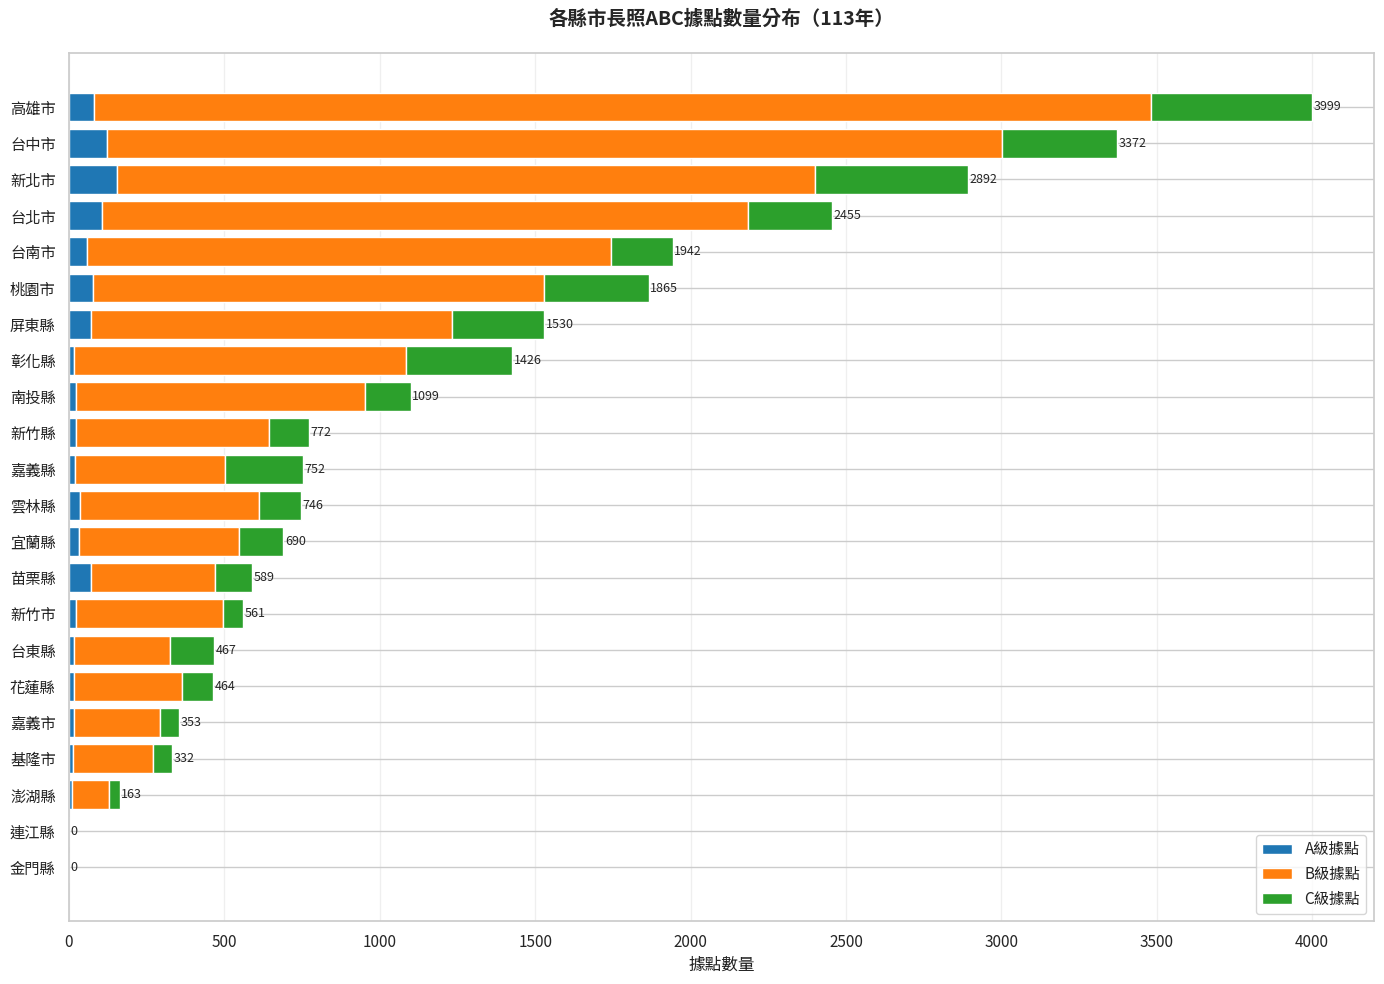


✓ 長條圖繪製完成


In [374]:
# =========================
# 繪製各縣市長照ABC據點數量堆疊長條圖 | Plot stacked bar chart
# =========================

print("\n" + "=" * 80)
print("繪製各縣市長照ABC據點數量統計圖")
print("=" * 80)

plot_ltc_facilities_by_city(df)

print("\n✓ 長條圖繪製完成")

---

## 三、統計分析方法 | Statistical Analysis Methods

本章節定義所有統計分析函數，包含：
1. 描述性統計分析
2. 皮爾森相關係數分析
3. 簡單線性迴歸
4. 服務密度分析
5. 供需落差分析
6. 多維度交叉比對分析

### 3.1 描述性統計分析函數 | Descriptive Statistics Function

In [375]:
def calculate_descriptive_stats(df):
    """
    計算描述性統計 | Calculate descriptive statistics
    """
    print("=" * 80)
    print("描述性統計分析 | Descriptive Statistics Analysis")
    print("=" * 80)

    results = {}

    # 高齡人口統計 | Elderly population statistics
    results["aging_stats"] = df[
        ["縣市名稱", "總人口", "65歲以上", "老年人口比例(%)"]
    ].sort_values("老年人口比例(%)", ascending=False)
    results["avg_aging_rate"] = df["老年人口比例(%)"].mean()
    results["std_aging_rate"] = df["老年人口比例(%)"].std()

    # 長照據點統計 | LTC facility statistics
    results["ltc_stats"] = df[["縣市名稱", "A", "B", "C", "總據點數"]].sort_values(
        "總據點數", ascending=False
    )
    results["total_facilities"] = df["總據點數"].sum()

    # 人口密度統計 | Population density statistics
    results["density_stats"] = df[
        ["縣市名稱", "總人口", "土地面積(km²)", "人口密度(人/km²)"]
    ].sort_values("人口密度(人/km²)", ascending=False)
    results["avg_density"] = df["人口密度(人/km²)"].mean()

    return results


def calculate_correlation_analysis(df):
    """
    計算相關係數分析 | Calculate correlation analysis

    修正: 過濾 NaN 和無限值以避免計算錯誤
    """
    print("\n" + "=" * 80)
    print("相關係數分析 | Correlation Analysis")
    print("=" * 80)

    results = {}
    correlation_table = []

    # 變數對1：老年人口比例 vs 每千位高齡人口據點數
    valid_mask1 = (
        df[["老年人口比例(%)", "每千位高齡人口據點數"]].notna().all(axis=1)
        & np.isfinite(df["老年人口比例(%)"]).values
        & np.isfinite(df["每千位高齡人口據點數"]).values
    )
    if valid_mask1.sum() > 2:
        r1, p1 = pearsonr(
            df.loc[valid_mask1, "老年人口比例(%)"],
            df.loc[valid_mask1, "每千位高齡人口據點數"],
        )
        results["aging_vs_service"] = {"r": r1, "p": p1, "n": valid_mask1.sum()}
        correlation_table.append(
            {
                "變數對": "老年人口比例(%) vs 每千位高齡人口據點數",
                "樣本數": valid_mask1.sum(),
                "Pearson r": f"{r1:.4f}",
                "p-value": f"{p1:.4f}",
                "顯著性": "**" if p1 < 0.01 else "*" if p1 < 0.05 else "ns",
            }
        )
        print(f"\n【變數對1】老年人口比例 vs 每千位高齡人口據點數")
        print(f"  有效樣本數 n = {valid_mask1.sum()}")
        print(f"  Pearson r = {r1:.4f}, p-value = {p1:.4f}")
    else:
        results["aging_vs_service"] = {"r": np.nan, "p": np.nan, "n": valid_mask1.sum()}
        print(f"\n【變數對1】⚠ 有效樣本數不足 (n={valid_mask1.sum()})")

    # 變數對2：人口密度 vs 每平方公里據點數
    valid_mask2 = (
        df[["人口密度(人/km²)", "每平方公里據點數"]].notna().all(axis=1)
        & np.isfinite(df["人口密度(人/km²)"]).values
        & np.isfinite(df["每平方公里據點數"]).values
    )
    if valid_mask2.sum() > 2:
        r2, p2 = pearsonr(
            df.loc[valid_mask2, "人口密度(人/km²)"],
            df.loc[valid_mask2, "每平方公里據點數"],
        )
        results["density_vs_spatial"] = {"r": r2, "p": p2, "n": valid_mask2.sum()}
        correlation_table.append(
            {
                "變數對": "人口密度(人/km²) vs 每平方公里據點數",
                "樣本數": valid_mask2.sum(),
                "Pearson r": f"{r2:.4f}",
                "p-value": f"{p2:.4f}",
                "顯著性": "**" if p2 < 0.01 else "*" if p2 < 0.05 else "ns",
            }
        )
        print(f"\n【變數對2】人口密度 vs 每平方公里據點數")
        print(f"  有效樣本數 n = {valid_mask2.sum()}")
        print(f"  Pearson r = {r2:.4f}, p-value = {p2:.4f}")
    else:
        results["density_vs_spatial"] = {
            "r": np.nan,
            "p": np.nan,
            "n": valid_mask2.sum(),
        }
        print(f"\n【變數對2】⚠ 有效樣本數不足 (n={valid_mask2.sum()})")

    # 變數對3：65歲以上人口 vs 總據點數
    valid_mask3 = (
        df[["65歲以上", "總據點數"]].notna().all(axis=1)
        & np.isfinite(df["65歲以上"]).values
        & np.isfinite(df["總據點數"]).values
    )
    if valid_mask3.sum() > 2:
        r3, p3 = pearsonr(
            df.loc[valid_mask3, "65歲以上"], df.loc[valid_mask3, "總據點數"]
        )
        results["elderly_vs_facilities"] = {"r": r3, "p": p3, "n": valid_mask3.sum()}
        correlation_table.append(
            {
                "變數對": "65歲以上人口 vs 總據點數",
                "樣本數": valid_mask3.sum(),
                "Pearson r": f"{r3:.4f}",
                "p-value": f"{p3:.4f}",
                "顯著性": "**" if p3 < 0.01 else "*" if p3 < 0.05 else "ns",
            }
        )
        print(f"\n【變數對3】65歲以上人口 vs 總據點數")
        print(f"  有效樣本數 n = {valid_mask3.sum()}")
        print(f"  Pearson r = {r3:.4f}, p-value = {p3:.4f}")
    else:
        results["elderly_vs_facilities"] = {
            "r": np.nan,
            "p": np.nan,
            "n": valid_mask3.sum(),
        }
        print(f"\n【變數對3】⚠ 有效樣本數不足 (n={valid_mask3.sum()})")

    # 儲存相關係數表格
    results["correlation_table"] = pd.DataFrame(correlation_table)

    return results


def calculate_regression_analysis(df):
    """
    計算迴歸分析 | Calculate regression analysis
    """
    print("\n" + "=" * 80)
    print("線性迴歸分析 | Linear Regression Analysis")
    print("=" * 80)

    results = {}

    # 模型1：老年人口比例 → 每千位高齡人口據點數
    X1 = df[["老年人口比例(%)"]].values
    y1 = df["每千位高齡人口據點數"].values
    model1 = LinearRegression()
    model1.fit(X1, y1)
    y1_pred = model1.predict(X1)
    r2_1 = r2_score(y1, y1_pred)

    results["model1"] = {
        "coef": model1.coef_[0],
        "intercept": model1.intercept_,
        "r2": r2_1,
        "predictions": y1_pred,
    }

    print(f"\n模型1: 每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例")
    print(f"  斜率 β₁ = {model1.coef_[0]:.4f}")
    print(f"  截距 β₀ = {model1.intercept_:.4f}")
    print(f"  R² = {r2_1:.4f}")

    # 模型2：65歲以上人口 → 總據點數
    X2 = df[["65歲以上"]].values
    y2 = df["總據點數"].values
    model2 = LinearRegression()
    model2.fit(X2, y2)
    y2_pred = model2.predict(X2)
    r2_2 = r2_score(y2, y2_pred)

    results["model2"] = {
        "coef": model2.coef_[0],
        "intercept": model2.intercept_,
        "r2": r2_2,
        "predictions": y2_pred,
    }

    print(f"\n模型2: 總據點數 = β₀ + β₁ × 65歲以上人口")
    print(f"  斜率 β₁ = {model2.coef_[0]:.6f}")
    print(f"  截距 β₀ = {model2.intercept_:.4f}")
    print(f"  R² = {r2_2:.4f}")

    return results


def calculate_supply_demand_gap(df):
    """
    計算供需落差 | Calculate supply-demand gap
    """
    print("\n" + "=" * 80)
    print("供需落差分析 | Supply-Demand Gap Analysis")
    print("=" * 80)

    # 計算全國平均服務率 | Calculate national average service rate
    avg_service_rate = df["每千位高齡人口據點數"].mean()

    # 計算所需據點數 | Calculate required facilities
    df["所需據點數"] = (df["65歲以上"] * avg_service_rate / 1000).round(0)
    df["服務缺口"] = df["所需據點數"] - df["總據點數"]
    df["缺口比例(%)"] = (df["服務缺口"] / df["所需據點數"] * 100).round(2)

    print(f"\n合理服務標準: 每千位高齡人口 {avg_service_rate:.2f} 個據點")

    # 識別資源不足與充足區域 | Identify shortage and surplus areas
    shortage = df[df["服務缺口"] > 0].sort_values("服務缺口", ascending=False)
    surplus = df[df["服務缺口"] < 0].sort_values("服務缺口")

    results = {
        "avg_service_rate": avg_service_rate,
        "shortage_areas": shortage,
        "surplus_areas": surplus,
        "gap_data": df[
            [
                "縣市名稱",
                "65歲以上",
                "總據點數",
                "所需據點數",
                "服務缺口",
                "缺口比例(%)",
            ]
        ].copy(),
    }

    print(f"\n資源不足區域: {len(shortage)} 個縣市")
    print(f"資源充足區域: {len(surplus)} 個縣市")

    return results


def identify_hotspots(df):
    """
    識別資源不足熱點 | Identify resource shortage hotspots
    """
    print("\n" + "=" * 80)
    print("資源不足熱點識別 | Hotspot Identification")
    print("=" * 80)

    # 計算Z分數 | Calculate Z-scores
    df["老化程度Z"] = (df["老年人口比例(%)"] - df["老年人口比例(%)"].mean()) / df[
        "老年人口比例(%)"
    ].std()
    df["資源充足度Z"] = (
        df["每千位高齡人口據點數"] - df["每千位高齡人口據點數"].mean()
    ) / df["每千位高齡人口據點數"].std()

    # 計算優先設置分數 | Calculate priority score
    df["優先設置分數"] = df["老化程度Z"] - df["資源充足度Z"]

    # 識別熱點 | Identify hotspots
    avg_aging = df["老年人口比例(%)"].mean()
    avg_resource = df["每千位高齡人口據點數"].mean()

    hotspots = df[
        (df["老年人口比例(%)"] > avg_aging)
        & (df["每千位高齡人口據點數"] < avg_resource)
    ].sort_values("優先設置分數", ascending=False)

    results = {
        "hotspots": hotspots,
        "priority_ranking": df[
            ["縣市名稱", "老年人口比例(%)", "每千位高齡人口據點數", "優先設置分數"]
        ].sort_values("優先設置分數", ascending=False),
        "avg_aging": avg_aging,
        "avg_resource": avg_resource,
    }

    print(f"\n識別到 {len(hotspots)} 個資源不足熱點")

    return results


print("✓ 統計分析函數定義完成 | Statistical analysis functions defined")

✓ 統計分析函數定義完成 | Statistical analysis functions defined


---

## 四、執行分析 | Execute Analysis

載入資料並執行所有統計分析。

### 3.2 統計表格輸出函數 | Statistical Table Output Functions

In [376]:
def print_correlation_table(corr_results):
    """
    輸出表格:皮爾森相關係數分析統計表
    """
    print("\n" + "=" * 80)
    print("表一、皮爾森相關係數分析統計表")
    print("=" * 80)
    print()

    if "correlation_table" in corr_results:
        df_corr = corr_results["correlation_table"]
        display(df_corr)
        print("\n註:* p < 0.05, ** p < 0.01, ns = 不顯著")
    else:
        print("無相關係數數據")


def print_regression_table(reg_results, df):
    """
    輸出表格:迴歸統計表與ANOVA表
    """
    print("\n" + "=" * 80)
    print("表二、線性迴歸統計表 - 模型1")
    print("=" * 80)
    print("依變數:每千位高齡人口據點數")
    print("自變數:老年人口比例(%)")
    print()

    model1 = reg_results["model1"]
    n = len(df)

    # 迴歸統計表
    regression_stats1 = pd.DataFrame(
        {
            "統計量": ["Multiple R", "R²", "調整後 R²", "標準誤", "觀察值個數"],
            "數值": [
                f"{np.sqrt(model1['r2']):.4f}",
                f"{model1['r2']:.4f}",
                f"{1 - (1 - model1['r2']) * (n - 1) / (n - 2):.4f}",
                f"{np.sqrt(mean_squared_error(df['每千位高齡人口據點數'], model1['predictions'])):.4f}",
                f"{n}",
            ],
        }
    )
    display(regression_stats1)

    # ANOVA表
    print("\n" + "-" * 80)
    print("表三、ANOVA表 - 模型1")
    print("-" * 80)
    print()

    SSR = np.sum((model1["predictions"] - df["每千位高齡人口據點數"].mean()) ** 2)
    SSE = np.sum((df["每千位高齡人口據點數"] - model1["predictions"]) ** 2)
    SST = SSR + SSE
    df_reg = 1
    df_res = n - 2
    MSR = SSR / df_reg
    MSE = SSE / df_res
    F = MSR / MSE

    anova_df1 = pd.DataFrame(
        {
            "來源": ["迴歸", "殘差", "總和"],
            "df": [df_reg, df_res, n - 1],
            "SS": [f"{SSR:.2f}", f"{SSE:.2f}", f"{SST:.2f}"],
            "MS": [f"{MSR:.2f}", f"{MSE:.2f}", ""],
            "F": [f"{F:.4f}", "", ""],
            "顯著性F": [f"{1 - stats.f.cdf(F, df_reg, df_res):.4f}", "", ""],
        }
    )
    display(anova_df1)

    # 係數表
    print("\n" + "-" * 80)
    print("表四、線性迴歸係數表 - 模型1")
    print("-" * 80)
    print()

    se_slope = np.sqrt(
        MSE / np.sum((df["老年人口比例(%)"] - df["老年人口比例(%)"].mean()) ** 2)
    )
    t_slope = model1["coef"] / se_slope
    p_slope = 2 * (1 - stats.t.cdf(abs(t_slope), df_res))

    coef_df1 = pd.DataFrame(
        {
            "項目": ["截距", "老年人口比例(%)"],
            "係數": [f"{model1['intercept']:.4f}", f"{model1['coef']:.4f}"],
            "標準誤": ["", f"{se_slope:.4f}"],
            "t統計": ["", f"{t_slope:.4f}"],
            "p-value": ["", f"{p_slope:.4f}"],
        }
    )
    display(coef_df1)

    # 模型2
    print("\n\n" + "=" * 80)
    print("表五、線性迴歸統計表 - 模型2")
    print("=" * 80)
    print("依變數:總據點數")
    print("自變數:65歲以上人口")
    print()

    model2 = reg_results["model2"]

    regression_stats2 = pd.DataFrame(
        {
            "統計量": ["Multiple R", "R²", "調整後 R²", "標準誤", "觀察值個數"],
            "數值": [
                f"{np.sqrt(model2['r2']):.4f}",
                f"{model2['r2']:.4f}",
                f"{1 - (1 - model2['r2']) * (n - 1) / (n - 2):.4f}",
                f"{np.sqrt(mean_squared_error(df['總據點數'], model2['predictions'])):.4f}",
                f"{n}",
            ],
        }
    )
    display(regression_stats2)

    # 模型2 ANOVA
    print("\n" + "-" * 80)
    print("表六、ANOVA表 - 模型2")
    print("-" * 80)
    print()

    SSR2 = np.sum((model2["predictions"] - df["總據點數"].mean()) ** 2)
    SSE2 = np.sum((df["總據點數"] - model2["predictions"]) ** 2)
    SST2 = SSR2 + SSE2
    MSR2 = SSR2 / df_reg
    MSE2 = SSE2 / df_res
    F2 = MSR2 / MSE2

    anova_df2 = pd.DataFrame(
        {
            "來源": ["迴歸", "殘差", "總和"],
            "df": [df_reg, df_res, n - 1],
            "SS": [f"{SSR2:.2f}", f"{SSE2:.2f}", f"{SST2:.2f}"],
            "MS": [f"{MSR2:.2f}", f"{MSE2:.2f}", ""],
            "F": [f"{F2:.4f}", "", ""],
            "顯著性F": [f"{1 - stats.f.cdf(F2, df_reg, df_res):.4f}", "", ""],
        }
    )
    display(anova_df2)


def print_descriptive_table(desc_results, df):
    """
    輸出表格:各數值統計表
    """
    print("\n" + "=" * 80)
    print("表七、各縣市主要指標統計表")
    print("=" * 80)
    print()

    summary_cols = [
        "縣市名稱",
        "總人口",
        "65歲以上",
        "老年人口比例(%)",
        "總據點數",
        "每千位高齡人口據點數",
        "人口密度(人/km²)",
    ]

    display_df = df[summary_cols].copy()

    # 格式化數值欄位,但保持為數值類型以便表格呈現
    display_df["總人口"] = display_df["總人口"].astype(int)
    display_df["65歲以上"] = display_df["65歲以上"].astype(int)
    display_df["老年人口比例(%)"] = display_df["老年人口比例(%)"].round(2)
    display_df["總據點數"] = display_df["總據點數"].astype(int)
    display_df["每千位高齡人口據點數"] = display_df["每千位高齡人口據點數"].apply(
        lambda x: round(x, 2) if pd.notna(x) and np.isfinite(x) else np.nan
    )
    display_df["人口密度(人/km²)"] = display_df["人口密度(人/km²)"].apply(
        lambda x: round(x, 2) if pd.notna(x) and np.isfinite(x) else np.nan
    )

    display(display_df)


print("✓ 統計表格輸出函數定義完成 | Statistical table output functions defined")

✓ 統計表格輸出函數定義完成 | Statistical table output functions defined


In [377]:
# =========================
# 執行所有統計分析 | Execute All Statistical Analyses
# =========================

# 1. 描述性統計 | Descriptive statistics
desc_results = calculate_descriptive_stats(df)

# 2. 相關係數分析 | Correlation analysis
corr_results = calculate_correlation_analysis(df)

# 3. 迴歸分析 | Regression analysis
reg_results = calculate_regression_analysis(df)

# 4. 供需落差分析 | Supply-demand gap analysis
gap_results = calculate_supply_demand_gap(df)

# 5. 熱點識別 | Hotspot identification
hotspot_results = identify_hotspots(df)

# 儲存分析結果 | Save analysis results
analysis_results = {
    "descriptive": desc_results,
    "correlation": corr_results,
    "regression": reg_results,
    "gap": gap_results,
    "hotspots": hotspot_results,
    "data": df,
}

print("\n" + "=" * 80)
print("✓ 所有統計分析完成 | All statistical analyses completed")
print("=" * 80)

描述性統計分析 | Descriptive Statistics Analysis

相關係數分析 | Correlation Analysis

【變數對1】老年人口比例 vs 每千位高齡人口據點數
  有效樣本數 n = 22
  Pearson r = 0.1535, p-value = 0.4953

【變數對2】人口密度 vs 每平方公里據點數
  有效樣本數 n = 18
  Pearson r = 0.9585, p-value = 0.0000

【變數對3】65歲以上人口 vs 總據點數
  有效樣本數 n = 22
  Pearson r = 0.9164, p-value = 0.0000

線性迴歸分析 | Linear Regression Analysis

模型1: 每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例
  斜率 β₁ = 0.1814
  截距 β₀ = 2.7808
  R² = 0.0236

模型2: 總據點數 = β₀ + β₁ × 65歲以上人口
  斜率 β₁ = 0.004771
  截距 β₀ = 229.7130
  R² = 0.8398

供需落差分析 | Supply-Demand Gap Analysis

合理服務標準: 每千位高齡人口 6.29 個據點

資源不足區域: 10 個縣市
資源充足區域: 12 個縣市

資源不足熱點識別 | Hotspot Identification

識別到 6 個資源不足熱點

✓ 所有統計分析完成 | All statistical analyses completed


### 4.1 輸出統計分析表格 | Output Statistical Analysis Tables

In [378]:
# =========================
# 輸出統計表格 | Output Statistical Tables
# =========================

# 表一: 皮爾森相關係數分析統計表
print_correlation_table(corr_results)

# 表二至六: 迴歸統計表與ANOVA表
print_regression_table(reg_results, df)

# 表七: 各縣市主要指標統計表
print_descriptive_table(desc_results, df)


表一、皮爾森相關係數分析統計表



,變數對,樣本數,Pearson r,p-value,顯著性
0,老年人口比例(%) vs 每千位高齡人口據點數,22,0.1535,0.4953,ns
1,人口密度(人/km²) vs 每平方公里據點數,18,0.9585,0.0000,**
2,65歲以上人口 vs 總據點數,22,0.9164,0.0000,**



註:* p < 0.05, ** p < 0.01, ns = 不顯著

表二、線性迴歸統計表 - 模型1
依變數:每千位高齡人口據點數
自變數:老年人口比例(%)



,統計量,數值
0,Multiple R,0.1535
1,R²,0.0236
2,調整後 R²,-0.0253
3,標準誤,2.7070
4,觀察值個數,22



--------------------------------------------------------------------------------
表三、ANOVA表 - 模型1
--------------------------------------------------------------------------------



,來源,df,SS,MS,F,顯著性F
0,迴歸,1,3.89,3.89,0.4824,0.4953
1,殘差,20,161.21,8.06,,
2,總和,21,165.10,,,



--------------------------------------------------------------------------------
表四、線性迴歸係數表 - 模型1
--------------------------------------------------------------------------------



,項目,係數,標準誤,t統計,p-value
0,截距,2.7808,,,
1,老年人口比例(%),0.1814,0.2612,0.6945,0.4953




表五、線性迴歸統計表 - 模型2
依變數:總據點數
自變數:65歲以上人口



,統計量,數值
0,Multiple R,0.9164
1,R²,0.8398
2,調整後 R²,0.8318
3,標準誤,437.5301
4,觀察值個數,22



--------------------------------------------------------------------------------
表六、ANOVA表 - 模型2
--------------------------------------------------------------------------------



,來源,df,SS,MS,F,顯著性F
0,迴歸,1,22078039.40,22078039.40,104.8460,0.0000
1,殘差,20,4211517.20,210575.86,,
2,總和,21,26289556.59,,,



表七、各縣市主要指標統計表



,縣市名稱,總人口,65歲以上,老年人口比例(%),總據點數,每千位高齡人口據點數,人口密度(人/km²)
0,新北市,4047001,768492,18.99,2892,3.76,1971.68
1,台北市,2490869,574458,23.06,2455,4.27,NaN
2,桃園市,2338648,371475,15.88,1865,5.02,1915.43
3,台中市,2860601,474248,16.58,3372,7.11,NaN
4,台南市,1858651,364115,19.59,1942,5.33,NaN
5,高雄市,2731412,544267,19.93,3999,7.35,925.24
6,宜蘭縣,449212,89618,19.95,690,7.70,209.56
7,新竹縣,594641,86088,14.48,772,8.97,416.55
8,苗栗縣,532854,104168,19.55,589,5.65,292.73
9,彰化縣,1225675,238924,19.49,1426,5.97,1140.80


---

## 五、結果視覺化 | Result Visualization

用圖表呈現分析結果。

In [379]:
# =========================
# 視覺化函數定義 | Visualization Functions
# =========================


def plot_aging_rate_by_city(df):
    """繪製各縣市老年人口比例長條圖 | Plot elderly population ratio by city"""
    fig, ax = plt.subplots(figsize=(14, 10))

    data = df.sort_values("老年人口比例(%)", ascending=True)
    avg = df["老年人口比例(%)"].mean()
    colors = ["#d62728" if x > avg else "#1f77b4" for x in data["老年人口比例(%)"]]

    bars = ax.barh(data["縣市名稱"], data["老年人口比例(%)"], color=colors)
    ax.axvline(
        x=avg, color="red", linestyle="--", linewidth=2, label=f"全國平均 ({avg:.2f}%)"
    )

    ax.set_xlabel("老年人口比例 (%)", fontsize=12)
    ax.set_title("各縣市老年人口比例（113年）", fontsize=14, fontweight="bold", pad=20)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis="x")

    for bar, val in zip(bars, data["老年人口比例(%)"]):
        ax.text(
            val + 0.2,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.1f}%",
            va="center",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()


def plot_service_gap(df):
    """繪製各縣市服務缺口長條圖 | Plot service gap by city"""
    fig, ax = plt.subplots(figsize=(14, 10))

    data = df.sort_values("服務缺口", ascending=True)
    colors = ["#d62728" if x > 0 else "#2ca02c" for x in data["服務缺口"]]

    bars = ax.barh(data["縣市名稱"], data["服務缺口"], color=colors)
    ax.axvline(x=0, color="black", linestyle="-", linewidth=1)

    ax.set_xlabel("服務缺口（據點數）", fontsize=12)
    ax.set_title("各縣市長照服務缺口（113年）", fontsize=14, fontweight="bold", pad=20)
    ax.grid(True, alpha=0.3, axis="x")

    for bar, val in zip(bars, data["服務缺口"]):
        offset = 5 if val >= 0 else -5
        ha = "left" if val >= 0 else "right"
        ax.text(
            val + offset,
            bar.get_y() + bar.get_height() / 2,
            f"{val:.0f}",
            va="center",
            ha=ha,
            fontsize=9,
        )

    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor="#d62728", label="資源不足"),
        Patch(facecolor="#2ca02c", label="資源充足"),
    ]
    ax.legend(handles=legend_elements, loc="lower right", fontsize=11)

    plt.tight_layout()
    plt.show()


def plot_scatter_analysis(df):
    """繪製散佈圖分析 | Plot scatter analysis"""
    fig, ax = plt.subplots(figsize=(14, 10))

    avg_aging = df["老年人口比例(%)"].mean()
    avg_resource = df["每千位高齡人口據點數"].mean()

    scatter = ax.scatter(
        df["老年人口比例(%)"],
        df["每千位高齡人口據點數"],
        s=df["65歲以上"] / 5000,
        alpha=0.6,
        c=df["服務缺口"],
        cmap="RdYlGn_r",
        edgecolors="black",
        linewidth=0.5,
    )

    # 添加縣市標籤 | Add city labels
    for idx, row in df.iterrows():
        ax.annotate(
            row["縣市名稱"],
            (row["老年人口比例(%)"], row["每千位高齡人口據點數"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            alpha=0.8,
        )

    # 添加平均線 | Add average lines
    ax.axhline(
        y=avg_resource,
        color="blue",
        linestyle="--",
        alpha=0.5,
        label=f"資源平均 ({avg_resource:.2f})",
    )
    ax.axvline(
        x=avg_aging,
        color="red",
        linestyle="--",
        alpha=0.5,
        label=f"老化平均 ({avg_aging:.2f}%)",
    )

    # 標註四個象限 | Label four quadrants
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(
        xlim[1] - 1,
        ylim[1] - 0.5,
        "高老化\n高資源",
        fontsize=11,
        ha="right",
        color="green",
        fontweight="bold",
    )
    ax.text(
        xlim[0] + 0.5,
        ylim[1] - 0.5,
        "低老化\n高資源",
        fontsize=11,
        ha="left",
        color="blue",
        fontweight="bold",
    )
    ax.text(
        xlim[1] - 1,
        ylim[0] + 0.5,
        "高老化\n低資源\n(熱點)",
        fontsize=11,
        ha="right",
        color="red",
        fontweight="bold",
    )
    ax.text(
        xlim[0] + 0.5,
        ylim[0] + 0.5,
        "低老化\n低資源",
        fontsize=11,
        ha="left",
        color="gray",
        fontweight="bold",
    )

    ax.set_xlabel("老年人口比例 (%)", fontsize=12)
    ax.set_ylabel("每千位高齡人口據點數", fontsize=12)
    ax.set_title(
        "老年人口比例 vs 長照資源密度（氣泡大小=高齡人口數）",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.legend(loc="upper left", fontsize=11)
    ax.grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label("服務缺口", fontsize=11)

    plt.tight_layout()
    plt.show()


print("✓ 視覺化函數定義完成 | Visualization functions defined")

✓ 視覺化函數定義完成 | Visualization functions defined


In [380]:
def plot_regression_analysis(df, reg_results):
    """
    繪製迴歸分析圖表 | Plot regression analysis with scatter plot and regression line
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # 圖1:模型1 - 老年人口比例 vs 每千位高齡人口據點數
    ax1 = axes[0]
    model1 = reg_results["model1"]

    # 散佈圖
    ax1.scatter(
        df["老年人口比例(%)"],
        df["每千位高齡人口據點數"],
        alpha=0.6,
        s=100,
        edgecolors="black",
        linewidth=0.5,
    )

    # 迴歸線
    x_line = np.linspace(df["老年人口比例(%)"].min(), df["老年人口比例(%)"].max(), 100)
    y_line = model1["intercept"] + model1["coef"] * x_line
    ax1.plot(
        x_line,
        y_line,
        "r-",
        linewidth=2,
        label=f"迴歸線: y = {model1['intercept']:.2f} + {model1['coef']:.2f}x",
    )

    # 添加縣市標籤
    for idx, row in df.iterrows():
        ax1.annotate(
            row["縣市名稱"],
            (row["老年人口比例(%)"], row["每千位高齡人口據點數"]),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=8,
            alpha=0.7,
        )

    ax1.set_xlabel("老年人口比例 (%)", fontsize=11)
    ax1.set_ylabel("每千位高齡人口據點數", fontsize=11)
    ax1.set_title(
        f"模型1:線性迴歸分析\nR² = {model1['r2']:.4f}", fontsize=12, fontweight="bold"
    )
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    # 圖2:模型2 - 65歲以上人口 vs 總據點數
    ax2 = axes[1]
    model2 = reg_results["model2"]

    # 散佈圖
    ax2.scatter(
        df["65歲以上"] / 10000,
        df["總據點數"],
        alpha=0.6,
        s=100,
        edgecolors="black",
        linewidth=0.5,
        color="green",
    )

    # 迴歸線
    x_line2 = np.linspace(df["65歲以上"].min(), df["65歲以上"].max(), 100)
    y_line2 = model2["intercept"] + model2["coef"] * x_line2
    ax2.plot(
        x_line2 / 10000,
        y_line2,
        "r-",
        linewidth=2,
        label=f"迴歸線: y = {model2['intercept']:.2f} + {model2['coef']:.4f}x",
    )

    # 添加縣市標籤
    for idx, row in df.iterrows():
        ax2.annotate(
            row["縣市名稱"],
            (row["65歲以上"] / 10000, row["總據點數"]),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=8,
            alpha=0.7,
        )

    ax2.set_xlabel("65歲以上人口 (萬人)", fontsize=11)
    ax2.set_ylabel("總據點數", fontsize=11)
    ax2.set_title(
        f"模型2:線性迴歸分析\nR² = {model2['r2']:.4f}", fontsize=12, fontweight="bold"
    )
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


print("✓ 迴歸分析視覺化函數定義完成 | Regression visualization function defined")

✓ 迴歸分析視覺化函數定義完成 | Regression visualization function defined


生成視覺化圖表 | Generating visualizations...



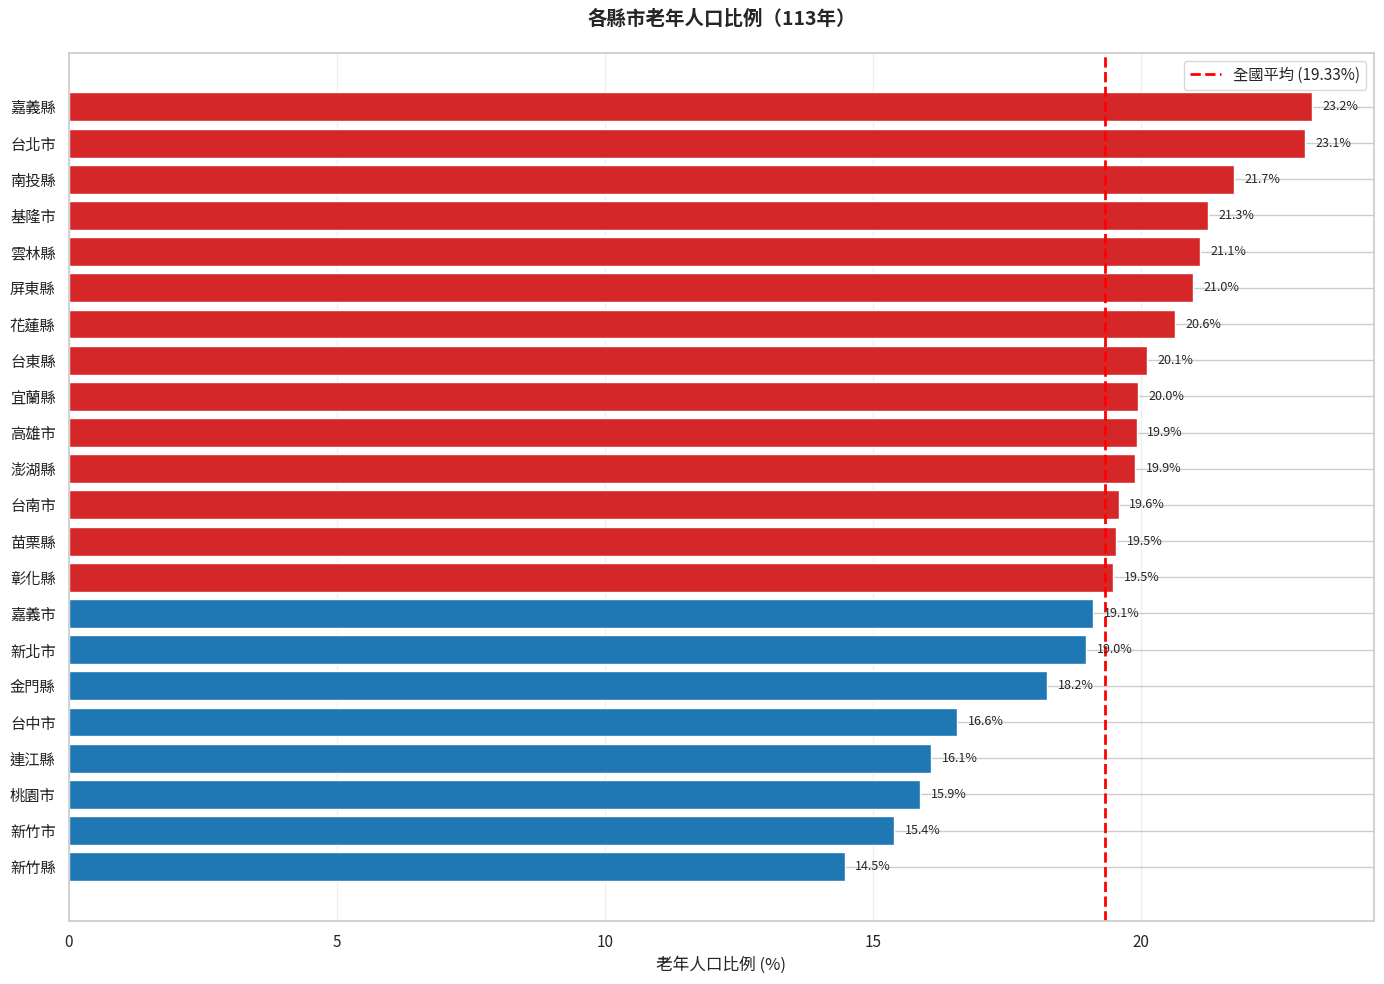

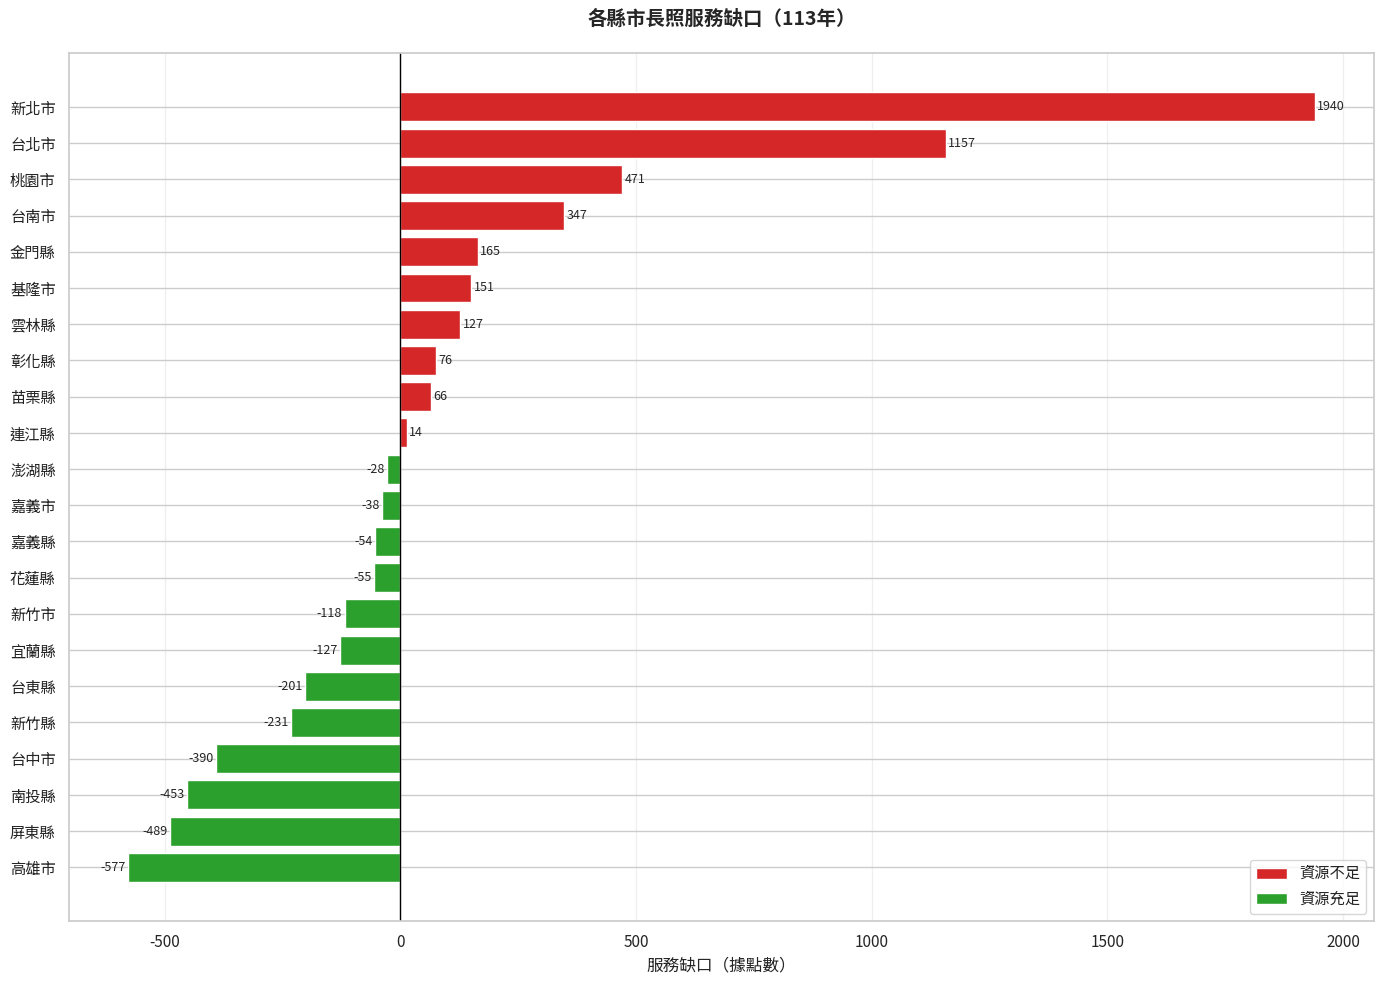

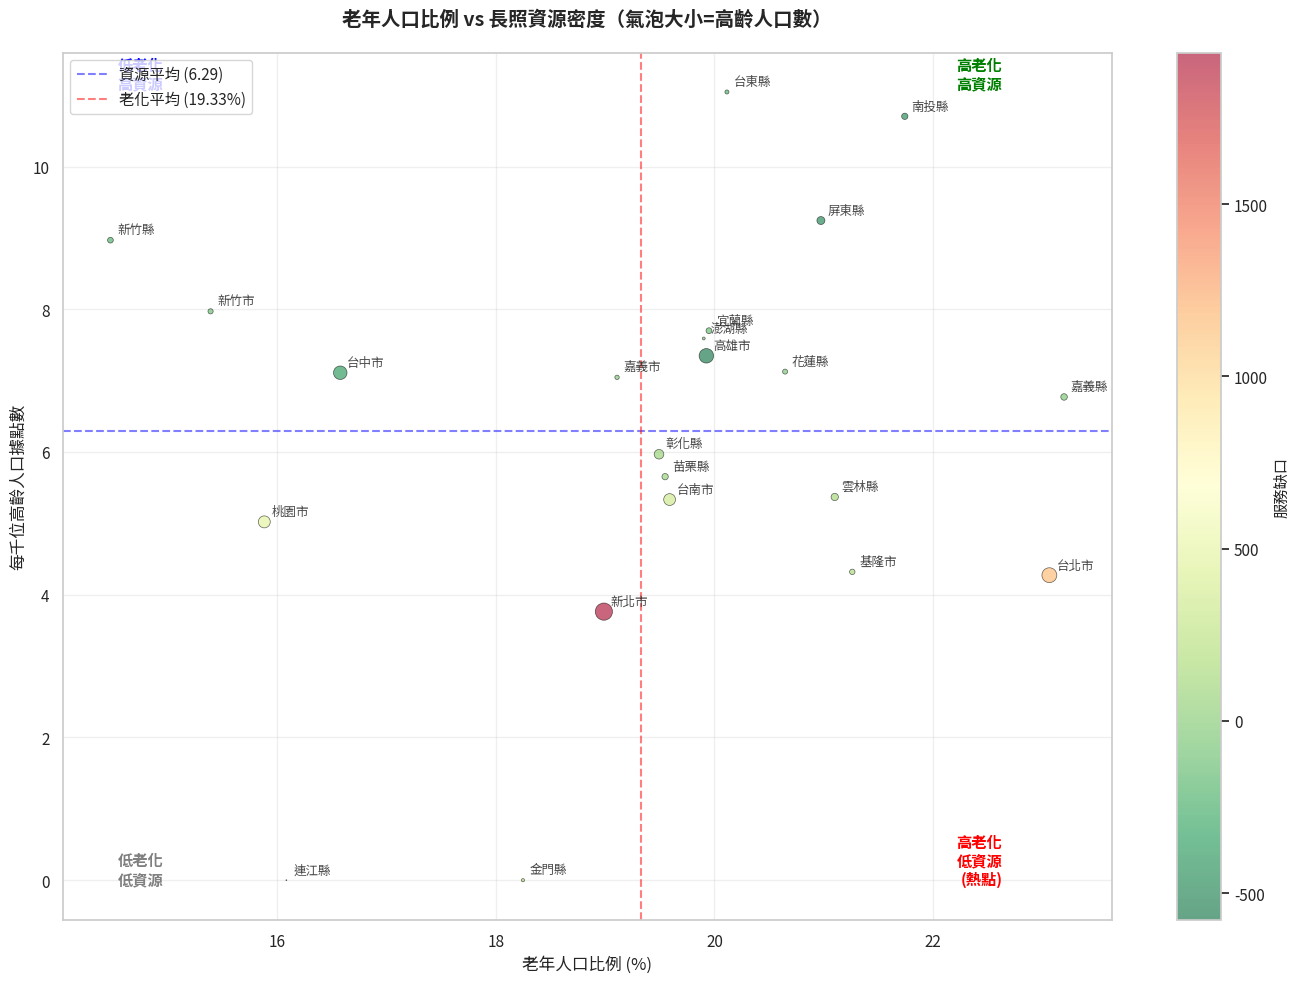


✓ 所有圖表生成完成 | All visualizations generated


In [381]:
# =========================
# 生成所有圖表 | Generate All Visualizations
# =========================

print("生成視覺化圖表 | Generating visualizations...\n")

# 圖表1：各縣市老年人口比例 | Elderly population ratio by city
plot_aging_rate_by_city(df)

# 圖表2：各縣市服務缺口 | Service gap by city
plot_service_gap(df)

# 圖表3：散佈圖分析 | Scatter plot analysis
plot_scatter_analysis(df)

print("\n✓ 所有圖表生成完成 | All visualizations generated")


生成迴歸分析視覺化 | Generating regression analysis visualizations...



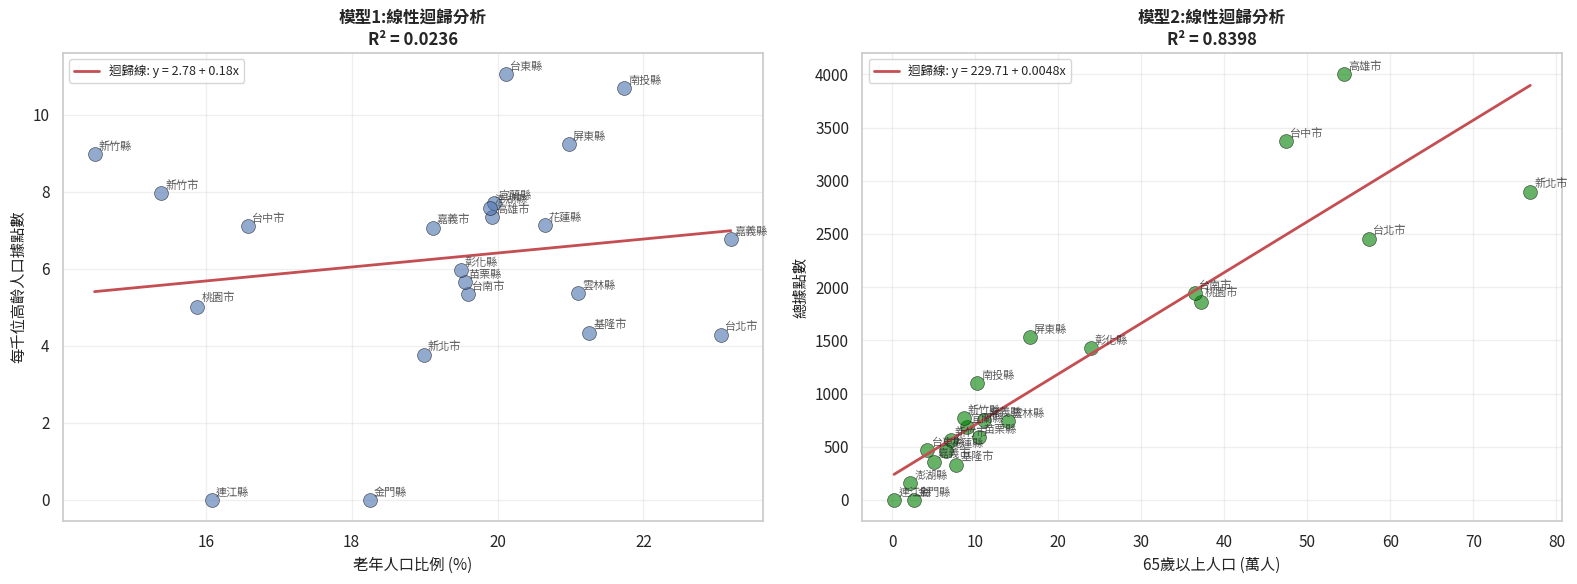


✓ 迴歸分析圖表生成完成 | Regression analysis plots generated


In [382]:
# =========================
# 生成迴歸分析圖表 | Generate Regression Analysis Plots
# =========================

print("\n生成迴歸分析視覺化 | Generating regression analysis visualizations...\n")

# 迴歸分析散佈圖與迴歸線
plot_regression_analysis(df, reg_results)

print("\n✓ 迴歸分析圖表生成完成 | Regression analysis plots generated")

---

## 六、研究結果與討論 | Results and Discussion

### 6.1 描述性統計結果摘要

In [383]:
# =========================
# 輸出描述性統計摘要 | Output Descriptive Statistics Summary
# =========================

print("=" * 80)
print("描述性統計結果摘要 | Descriptive Statistics Summary")
print("=" * 80)

print("\n【一、整體概況】")
print(f"分析年份: 113年")
print(f"縣市數量: {len(df)} 個")
print(f"全國高齡人口: {df['65歲以上'].sum():,.0f} 人")
print(f"全國平均老年人口比例: {desc_results['avg_aging_rate']:.2f}%")
print(f"全國長照據點總數: {desc_results['total_facilities']:.0f} 個")

print("\n【二、老化程度分析】")
top3_aging = df.nlargest(3, "老年人口比例(%)")
print("老化程度最高前三名：")
for i, row in enumerate(top3_aging.iterrows(), 1):
    print(f"  {i}. {row[1]['縣市名稱']}: {row[1]['老年人口比例(%)']:.2f}%")

print("\n【三、長照資源分布】")
top3_facilities = df.nlargest(3, "總據點數")
print("長照據點最多前三名：")
for i, row in enumerate(top3_facilities.iterrows(), 1):
    print(f"  {i}. {row[1]['縣市名稱']}: {row[1]['總據點數']:.0f} 個據點")

描述性統計結果摘要 | Descriptive Statistics Summary

【一、整體概況】
分析年份: 113年
縣市數量: 22 個
全國高齡人口: 4,488,707 人
全國平均老年人口比例: 19.33%
全國長照據點總數: 26469 個

【二、老化程度分析】
老化程度最高前三名：
  1. 嘉義縣: 23.20%
  2. 台北市: 23.06%
  3. 南投縣: 21.74%

【三、長照資源分布】
長照據點最多前三名：
  1. 高雄市: 3999 個據點
  2. 台中市: 3372 個據點
  3. 新北市: 2892 個據點


### 6.2 相關分析結果

In [384]:
# =========================
# 相關分析結果解讀 | Correlation Analysis Results Interpretation
# =========================

print("=" * 80)
print("相關分析結果解讀 | Correlation Analysis Interpretation")
print("=" * 80)

r1 = corr_results["aging_vs_service"]["r"]
p1 = corr_results["aging_vs_service"]["p"]
r2 = corr_results["density_vs_spatial"]["r"]
p2 = corr_results["density_vs_spatial"]["p"]
r3 = corr_results["elderly_vs_facilities"]["r"]
p3 = corr_results["elderly_vs_facilities"]["p"]


def interpret_correlation(r):
    """解釋相關係數強度 | Interpret correlation strength"""
    abs_r = abs(r)
    if abs_r > 0.7:
        return "強相關"
    elif abs_r > 0.4:
        return "中度相關"
    else:
        return "弱相關"


print(f"\n【變數對1】老年人口比例 vs 每千位高齡人口據點數")
print(f"  Pearson r = {r1:.4f} ({interpret_correlation(r1)})")
print(f"  p-value = {p1:.4f} {'(顯著)' if p1 < 0.05 else '(不顯著)'}")
print(
    f"  解讀: {'老化程度' + ('越高' if r1 > 0 else '越低') + '，資源配置' + ('越多' if r1 > 0 else '越少')}"
)

print(f"\n【變數對2】人口密度 vs 每平方公里據點數")
print(f"  Pearson r = {r2:.4f} ({interpret_correlation(r2)})")
print(f"  p-value = {p2:.4f} {'(顯著)' if p2 < 0.05 else '(不顯著)'}")
print(
    f"  解讀: {'人口密度' + ('越高' if r2 > 0 else '越低') + '，空間資源密度' + ('越高' if r2 > 0 else '越低')}"
)

print(f"\n【變數對3】65歲以上人口 vs 總據點數")
print(f"  Pearson r = {r3:.4f} ({interpret_correlation(r3)})")
print(f"  p-value = {p3:.4f} {'(顯著)' if p3 < 0.05 else '(不顯著)'}")
print(
    f"  解讀: {'高齡人口' + ('越多' if r3 > 0 else '越少') + '，據點數量' + ('越多' if r3 > 0 else '越少')}"
)

相關分析結果解讀 | Correlation Analysis Interpretation

【變數對1】老年人口比例 vs 每千位高齡人口據點數
  Pearson r = 0.1535 (弱相關)
  p-value = 0.4953 (不顯著)
  解讀: 老化程度越高，資源配置越多

【變數對2】人口密度 vs 每平方公里據點數
  Pearson r = 0.9585 (強相關)
  p-value = 0.0000 (顯著)
  解讀: 人口密度越高，空間資源密度越高

【變數對3】65歲以上人口 vs 總據點數
  Pearson r = 0.9164 (強相關)
  p-value = 0.0000 (顯著)
  解讀: 高齡人口越多，據點數量越多


### 6.3 迴歸分析結果

In [385]:
# =========================
# 迴歸分析結果解讀 | Regression Analysis Results Interpretation
# =========================

print("=" * 80)
print("迴歸分析結果解讀 | Regression Analysis Interpretation")
print("=" * 80)

model1 = reg_results["model1"]
model2 = reg_results["model2"]


def interpret_r2(r2):
    """解釋R²值 | Interpret R² value"""
    if r2 > 0.7:
        return "解釋力強"
    elif r2 > 0.4:
        return "中等解釋力"
    else:
        return "解釋力弱"


print("\n【模型1】每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例")
print(f"  斜率 β₁ = {model1['coef']:.4f}")
print(f"  截距 β₀ = {model1['intercept']:.4f}")
print(f"  R² = {model1['r2']:.4f} ({interpret_r2(model1['r2'])})")
print(
    f"  解讀: 老年人口比例每增加1%，每千位高齡人口據點數{'增加' if model1['coef'] > 0 else '減少'}{abs(model1['coef']):.4f}個"
)

print("\n【模型2】總據點數 = β₀ + β₁ × 65歲以上人口")
print(f"  斜率 β₁ = {model2['coef']:.6f}")
print(f"  截距 β₀ = {model2['intercept']:.4f}")
print(f"  R² = {model2['r2']:.4f} ({interpret_r2(model2['r2'])})")
print(
    f"  解讀: 65歲以上人口每增加1萬人，據點數{'增加' if model2['coef'] > 0 else '減少'}{abs(model2['coef'] * 10000):.2f}個"
)

迴歸分析結果解讀 | Regression Analysis Interpretation

【模型1】每千位高齡人口據點數 = β₀ + β₁ × 老年人口比例
  斜率 β₁ = 0.1814
  截距 β₀ = 2.7808
  R² = 0.0236 (解釋力弱)
  解讀: 老年人口比例每增加1%，每千位高齡人口據點數增加0.1814個

【模型2】總據點數 = β₀ + β₁ × 65歲以上人口
  斜率 β₁ = 0.004771
  截距 β₀ = 229.7130
  R² = 0.8398 (解釋力強)
  解讀: 65歲以上人口每增加1萬人，據點數增加47.71個


---

## 六、深化分析：資源配置成因探討 | Advanced Analysis: Causes of Resource Allocation

本章節針對研究核心問題進行深化分析，探討長照資源分布不均的多重成因，並檢驗都市化因素的調節效應。

### 6.1 多元線性迴歸分析 (模型3) | Multiple Linear Regression Analysis (Model 3)

In [386]:
# =========================
# 模型3：多元線性迴歸分析 | Model 3: Multiple Linear Regression
# =========================

print("\n" + "=" * 80)
print("模型3：多元線性迴歸 - 資源配置影響因素分析")
print("Model 3: Multiple Linear Regression - Factors Affecting Resource Allocation")
print("=" * 80)

# 準備資料 | Prepare data
X_vars = ["老年人口比例(%)", "人口密度(人/km²)", "土地面積(km²)"]
y_var = "每千位高齡人口據點數"

# 過濾有效資料 | Filter valid data
df_model3 = df[X_vars + [y_var]].replace([np.inf, -np.inf], np.nan).dropna()

# 建立交互項 | Create interaction term
df_model3["老化×密度"] = df_model3["老年人口比例(%)"] * df_model3["人口密度(人/km²)"]

# 準備自變數與因變數 | Prepare independent and dependent variables
X = df_model3[["老年人口比例(%)", "人口密度(人/km²)", "土地面積(km²)", "老化×密度"]]
y = df_model3[y_var]

# 標準化自變數 (計算Beta係數) | Standardize predictors for Beta coefficients
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# 執行多元迴歸 | Perform multiple regression
from sklearn.linear_model import LinearRegression
from scipy import stats

# 未標準化模型 (原始係數) | Unstandardized model
model3_raw = LinearRegression()
model3_raw.fit(X, y)

# 標準化模型 (Beta係數) | Standardized model
model3_std = LinearRegression()
model3_std.fit(X_scaled_df, y)

# 計算統計量 | Calculate statistics
y_pred = model3_raw.predict(X)
n = len(y)
k = X.shape[1]

# R² 與調整後 R²
r_squared = model3_raw.score(X, y)
adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

# 殘差與標準誤 | Residuals and standard error
residuals = y - y_pred
mse = np.mean(residuals**2)
se = np.sqrt(mse)

# F統計量 | F-statistic
ss_total = np.sum((y - y.mean()) ** 2)
ss_residual = np.sum(residuals**2)
ss_regression = ss_total - ss_residual
df_regression = k
df_residual = n - k - 1
ms_regression = ss_regression / df_regression
ms_residual = ss_residual / df_residual
f_stat = ms_regression / ms_residual
f_pvalue = 1 - stats.f.cdf(f_stat, df_regression, df_residual)

# 係數的t檢定與p值 | t-test and p-values for coefficients
# 計算係數標準誤
X_with_const = np.column_stack([np.ones(len(X)), X])
var_coef = ms_residual * np.linalg.inv(X_with_const.T @ X_with_const).diagonal()
se_coef = np.sqrt(var_coef)

# 所有係數 (含截距) | All coefficients (including intercept)
all_coefs = np.concatenate([[model3_raw.intercept_], model3_raw.coef_])
t_stats = all_coefs / se_coef
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df_residual))

# 儲存結果 | Store results
model3 = {
    "model_raw": model3_raw,
    "model_std": model3_std,
    "r_squared": r_squared,
    "adj_r_squared": adj_r_squared,
    "se": se,
    "n": n,
    "k": k,
    "f_stat": f_stat,
    "f_pvalue": f_pvalue,
    "coefficients": model3_raw.coef_,
    "intercept": model3_raw.intercept_,
    "beta_coefficients": model3_std.coef_,
    "t_stats": t_stats,
    "p_values": p_values,
    "feature_names": X.columns.tolist(),
}

# 輸出統計摘要 | Output statistical summary
print(f"\n【模型統計摘要 | Model Summary Statistics】")
print(f"Multiple R: {np.sqrt(r_squared):.4f}")
print(f"R²: {r_squared:.4f}")
print(f"調整後 R² | Adjusted R²: {adj_r_squared:.4f}")
print(f"標準誤 | Standard Error: {se:.4f}")
print(f"觀察值個數 | Observations: {n}")

print(f"\n【ANOVA表 | ANOVA Table】")

# 建立 ANOVA 表格 | Create ANOVA table
anova_table = pd.DataFrame({
    "來源 Source": ["迴歸 Regression", "殘差 Residual", "總和 Total"],
    "自由度 df": [df_regression, df_residual, n - 1],
    "平方和 SS": [ss_regression, ss_residual, ss_total],
    "均方 MS": [ms_regression, ms_residual, "-"],
    "F值 F": [f_stat, "-", "-"],
    "顯著性 p-value": [f"{f_pvalue:.6f}", "-", "-"]
})

# 使用 pandas 顯示表格 | Display table using pandas
display(anova_table.style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
]))

print(f"\n【迴歸係數表 | Regression Coefficients Table】")
print(
    f"{'變數':<20} {'原始係數':<12} {'標準化係數(Beta)':<20} {'t統計量':<12} {'p值':<12} {'顯著性':<10}"
)
print(
    f"{'Variable':<20} {'Coef.':<12} {'Std. Beta':<20} {'t-stat':<12} {'p-value':<12} {'Sig.':<10}"
)
print("-" * 100)
print(
    f"{'(截距 Intercept)':<20} {model3_raw.intercept_:<12.4f} {'-':<20} {t_stats[0]:<12.4f} {p_values[0]:<12.6f} {'***' if p_values[0] < 0.001 else '**' if p_values[0] < 0.01 else '*' if p_values[0] < 0.05 else 'ns':<10}"
)
for i, var_name in enumerate(X.columns):
    sig = (
        "***"
        if p_values[i + 1] < 0.001
        else "**"
        if p_values[i + 1] < 0.01
        else "*"
        if p_values[i + 1] < 0.05
        else "ns"
    )
    print(
        f"{var_name:<20} {model3_raw.coef_[i]:<12.6f} {model3_std.coef_[i]:<20.4f} {t_stats[i + 1]:<12.4f} {p_values[i + 1]:<12.6f} {sig:<10}"
    )

print(f"\n註: *** p<0.001, ** p<0.01, * p<0.05, ns=不顯著")
print(f"Note: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant")

print("\n【關鍵發現 | Key Findings】")
print(f"1. 模型整體解釋力 R² = {r_squared:.4f}")
if "model1" in dir() and "r_squared" in model1:
    print(
        f"   (相較於模型1的R²={model1['r_squared']:.4f}，提升了{(r_squared - model1['r_squared']) * 100:.2f}個百分點)"
    )
print(f"2. 標準化係數Beta顯示各變數相對影響力排序:")
beta_ranking = sorted(
    zip(X.columns, model3_std.coef_), key=lambda x: abs(x[1]), reverse=True
)
for i, (var, beta) in enumerate(beta_ranking, 1):
    print(f"   {i}. {var}: β={beta:.4f}")
print(
    f"3. 模型F檢定: F({df_regression},{df_residual})={f_stat:.4f}, p={'<0.001' if f_pvalue < 0.001 else f'{f_pvalue:.4f}'} ({'顯著' if f_pvalue < 0.05 else '不顯著'})"
)

print("\n✓ 模型3分析完成 | Model 3 Analysis Completed")


模型3：多元線性迴歸 - 資源配置影響因素分析
Model 3: Multiple Linear Regression - Factors Affecting Resource Allocation

【模型統計摘要 | Model Summary Statistics】
Multiple R: 0.6117
R²: 0.3742
調整後 R² | Adjusted R²: 0.1817
標準誤 | Standard Error: 2.1781
觀察值個數 | Observations: 18

【ANOVA表 | ANOVA Table】


,來源 Source,自由度 df,平方和 SS,均方 MS,F值 F,顯著性 p-value
0,迴歸 Regression,4,51.060849,12.765212,1.943389,0.163080
1,殘差 Residual,13,85.390907,6.568531,-,-
2,總和 Total,17,136.451756,-,-,-



【迴歸係數表 | Regression Coefficients Table】
變數                   原始係數         標準化係數(Beta)          t統計量         p值           顯著性       
Variable             Coef.        Std. Beta            t-stat       p-value      Sig.      
----------------------------------------------------------------------------------------------------
(截距 Intercept)       -1.7104      -                    -0.2365      0.816715     ns        
老年人口比例(%)            0.273152     0.6300               0.6947       0.499494     ns        
人口密度(人/km²)          0.003713     4.9121               0.9738       0.347932     ns        
土地面積(km²)            0.001210     1.6466               2.0116       0.065460     ns        
老化×密度                -0.000170    -4.0009              -0.7982      0.439107     ns        

註: *** p<0.001, ** p<0.01, * p<0.05, ns=不顯著
Note: *** p<0.001, ** p<0.01, * p<0.05, ns=not significant

【關鍵發現 | Key Findings】
1. 模型整體解釋力 R² = 0.3742
2. 標準化係數Beta顯示各變數相對影響力排序:
   1. 人口密度(人/km²): β=4.9121
   2. 老化×密


生成模型3視覺化圖表...
  圖1: Beta係數比較圖


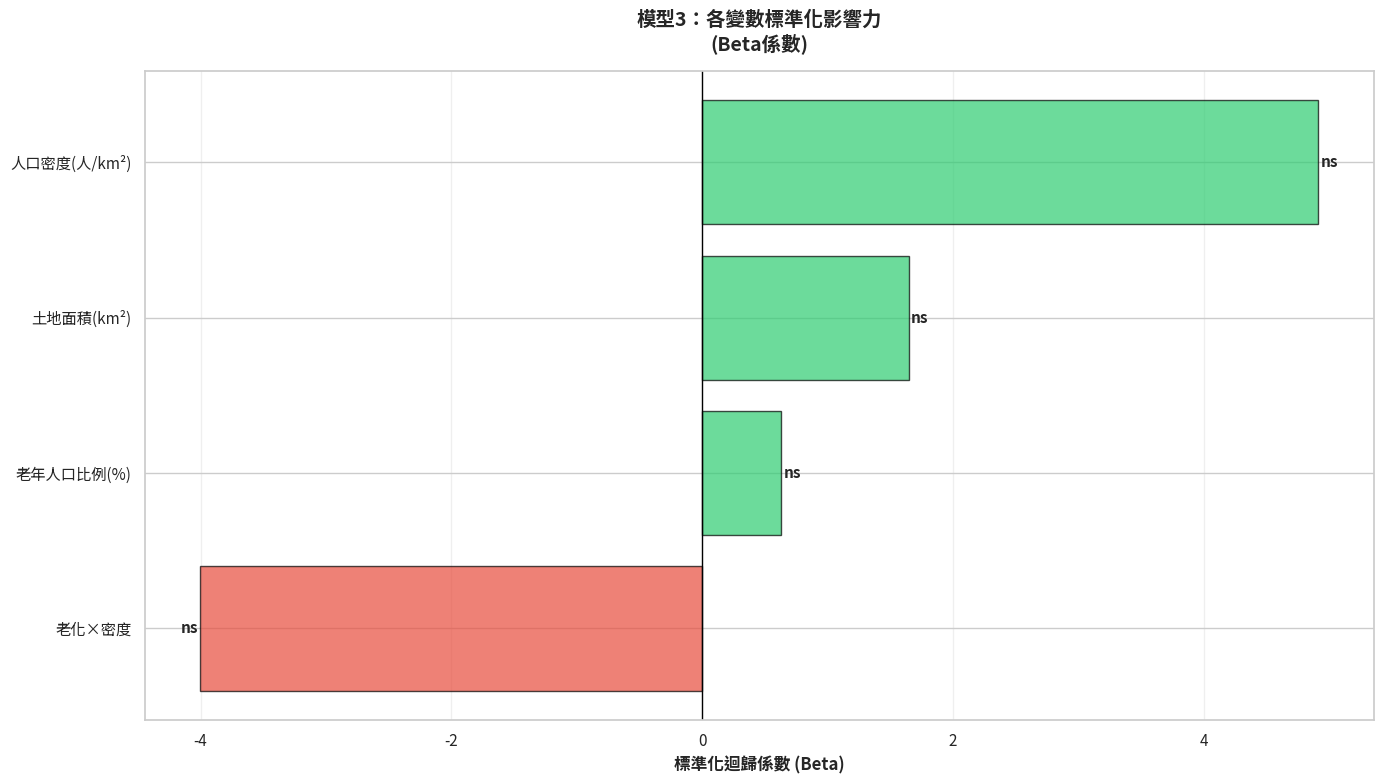

  圖2: 預測值 vs 實際值散佈圖


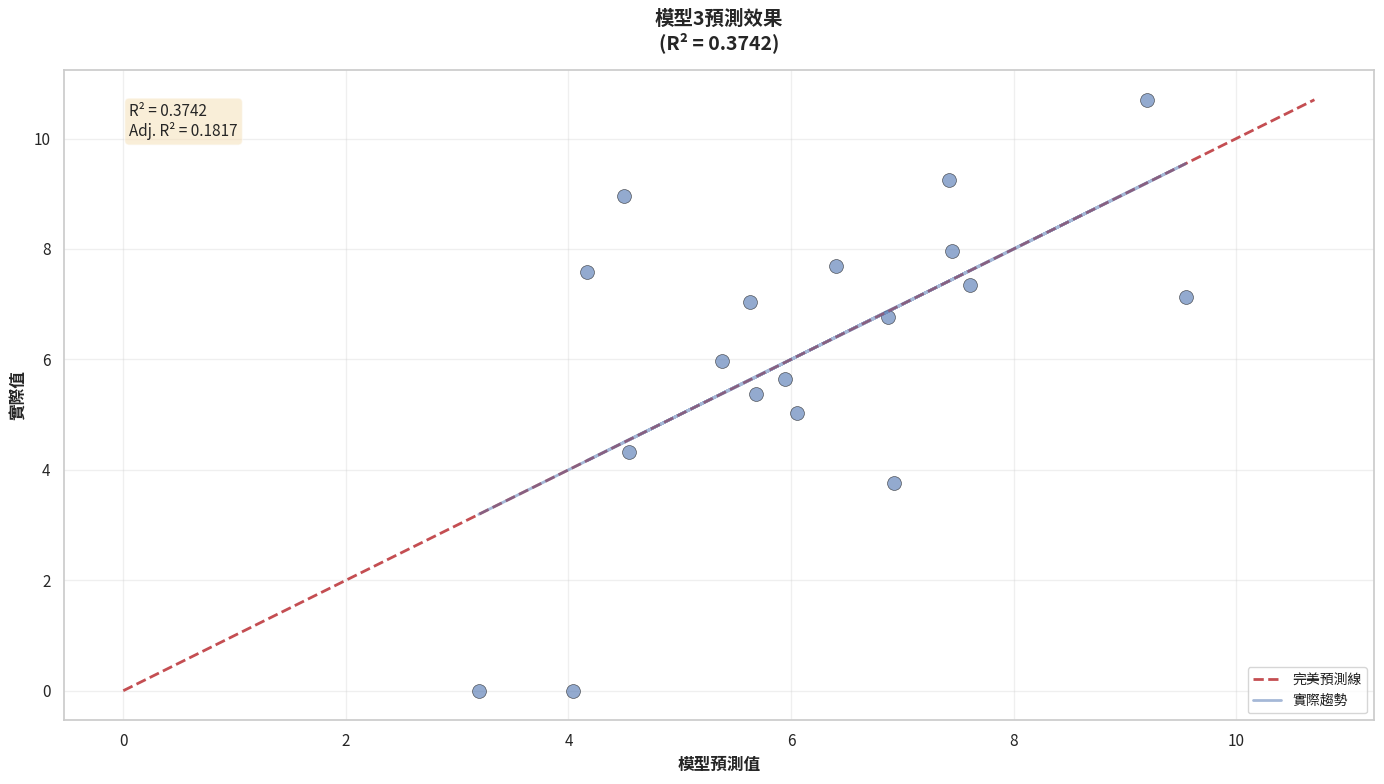

  圖3: 殘差分布直方圖


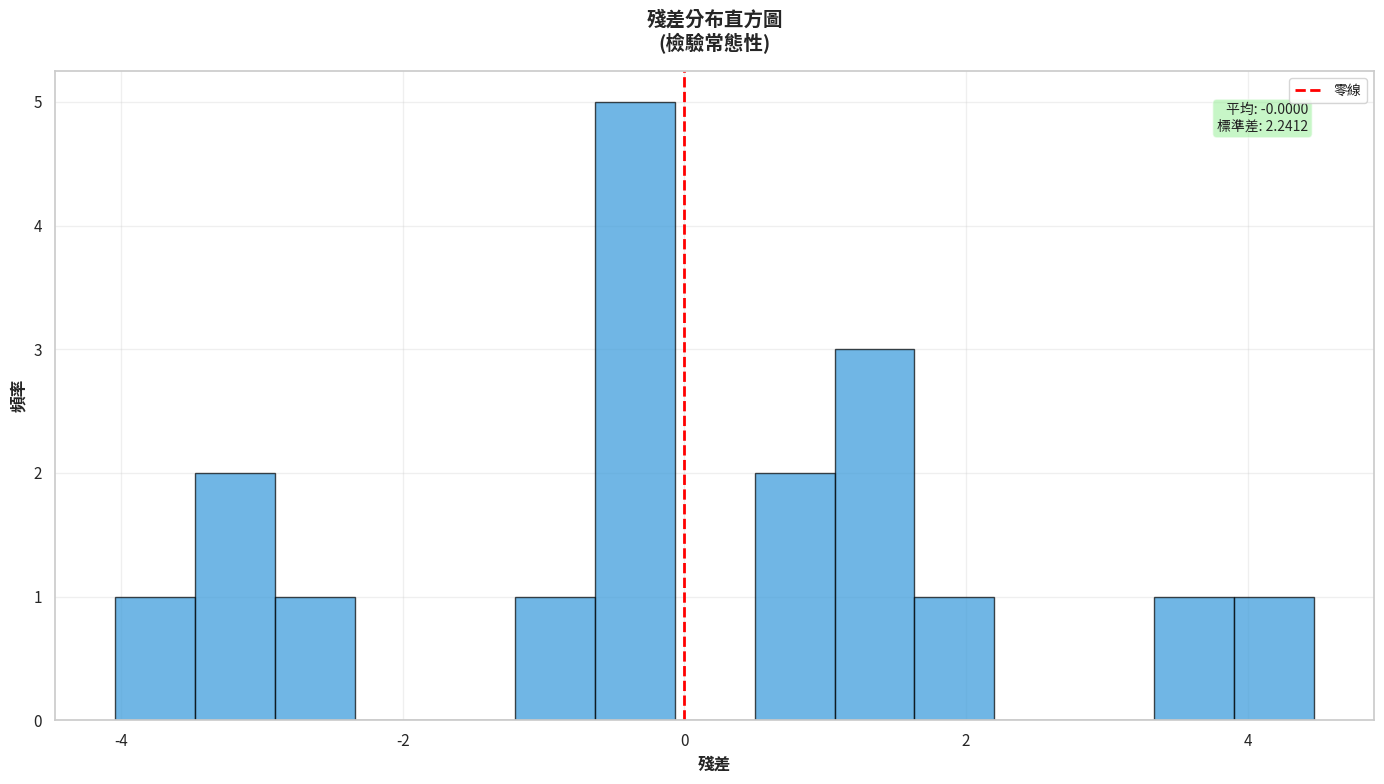

  圖4: 殘差 vs 預測值圖


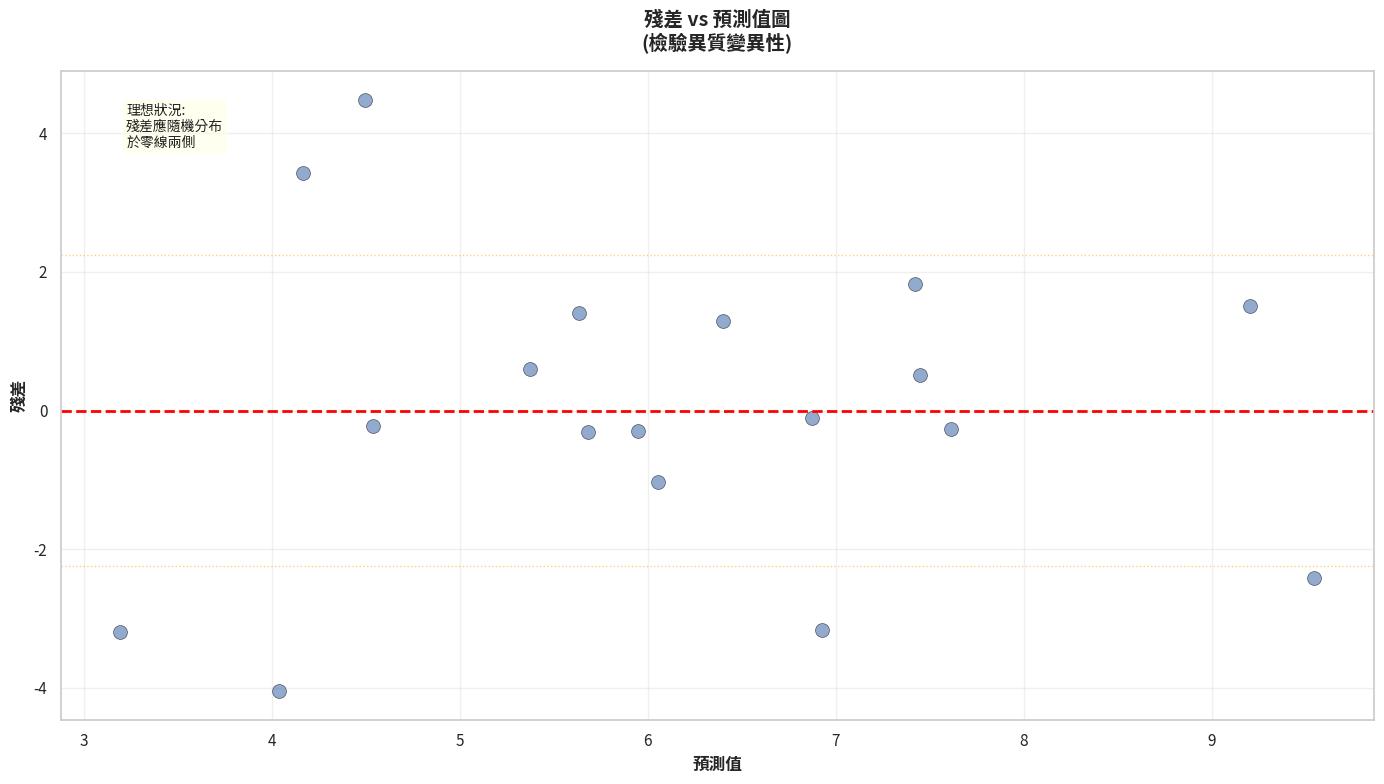

✓ 模型3視覺化完成


In [387]:
# =========================
# 模型3視覺化 | Model 3 Visualization
# =========================

print("\n生成模型3視覺化圖表...")

# 計算殘差 | Calculate residuals
y_pred_model3 = model3_raw.predict(X)
residuals_model3 = y - y_pred_model3

# 圖1: Beta係數比較圖 | Chart 1: Beta Coefficients Comparison
print("  圖1: Beta係數比較圖")
fig1, ax1 = plt.subplots(1, 1, figsize=(14, 8))
beta_df = pd.DataFrame(
    {"變數": X.columns, "Beta係數": model3_std.coef_, "p值": p_values[1:]}
)
beta_df["顯著"] = beta_df["p值"].apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "ns"
)
beta_df = beta_df.sort_values("Beta係數", ascending=True)

colors = ["#e74c3c" if x < 0 else "#2ecc71" for x in beta_df["Beta係數"]]
bars = ax1.barh(
    beta_df["變數"], beta_df["Beta係數"], color=colors, alpha=0.7, edgecolor="black"
)
ax1.axvline(0, color="black", linestyle="-", linewidth=1)
ax1.set_xlabel("標準化迴歸係數 (Beta)", fontsize=12, fontweight="bold")
ax1.set_title(
    "模型3：各變數標準化影響力\n(Beta係數)", fontsize=14, fontweight="bold", pad=15
)
ax1.grid(True, alpha=0.3, axis="x")

# 添加顯著性標記
for i, (idx, row) in enumerate(beta_df.iterrows()):
    x_pos = row["Beta係數"] + (0.02 if row["Beta係數"] > 0 else -0.02)
    ax1.text(
        x_pos,
        i,
        row["顯著"],
        ha="left" if row["Beta係數"] > 0 else "right",
        va="center",
        fontsize=11,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

# 圖2: 預測值 vs 實際值散佈圖 | Chart 2: Predicted vs Actual Scatter
print("  圖2: 預測值 vs 實際值散佈圖")
fig2, ax2 = plt.subplots(1, 1, figsize=(14, 8))
ax2.scatter(y_pred_model3, y, alpha=0.6, s=100, edgecolors="black", linewidth=0.5)

# 添加完美預測線
min_val = min(y.min(), y_pred_model3.min())
max_val = max(y.max(), y_pred_model3.max())
ax2.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2, label="完美預測線")

# 添加迴歸線
z = np.polyfit(y_pred_model3, y, 1)
p = np.poly1d(z)
ax2.plot(
    y_pred_model3, p(y_pred_model3), "b-", alpha=0.5, linewidth=2, label="實際趨勢"
)

ax2.set_xlabel("模型預測值", fontsize=12, fontweight="bold")
ax2.set_ylabel("實際值", fontsize=12, fontweight="bold")
ax2.set_title(
    f"模型3預測效果\n(R² = {r_squared:.4f})", fontsize=14, fontweight="bold", pad=15
)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 添加R²文字
ax2.text(
    0.05,
    0.95,
    f"R² = {r_squared:.4f}\nAdj. R² = {adj_r_squared:.4f}",
    transform=ax2.transAxes,
    fontsize=11,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

# 圖3: 殘差分布直方圖 | Chart 3: Residuals Distribution Histogram
print("  圖3: 殘差分布直方圖")
fig3, ax3 = plt.subplots(1, 1, figsize=(14, 8))
ax3.hist(residuals_model3, bins=15, alpha=0.7, color="#3498db", edgecolor="black")
ax3.axvline(0, color="red", linestyle="--", linewidth=2, label="零線")
ax3.set_xlabel("殘差", fontsize=12, fontweight="bold")
ax3.set_ylabel("頻率", fontsize=12, fontweight="bold")
ax3.set_title(
    "殘差分布直方圖\n(檢驗常態性)", fontsize=14, fontweight="bold", pad=15
)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 添加統計資訊
ax3.text(
    0.95,
    0.95,
    f"平均: {residuals_model3.mean():.4f}\n標準差: {residuals_model3.std():.4f}",
    transform=ax3.transAxes,
    fontsize=10,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.5),
)

plt.tight_layout()
plt.show()

# 圖4: 殘差 vs 預測值 (檢驗異質變異性) | Chart 4: Residuals vs Fitted
print("  圖4: 殘差 vs 預測值圖")
fig4, ax4 = plt.subplots(1, 1, figsize=(14, 8))
ax4.scatter(
    y_pred_model3, residuals_model3, alpha=0.6, s=100, edgecolors="black", linewidth=0.5
)
ax4.axhline(0, color="red", linestyle="--", linewidth=2)
ax4.axhline(
    residuals_model3.std(), color="orange", linestyle=":", linewidth=1, alpha=0.5
)
ax4.axhline(
    -residuals_model3.std(), color="orange", linestyle=":", linewidth=1, alpha=0.5
)

ax4.set_xlabel("預測值", fontsize=12, fontweight="bold")
ax4.set_ylabel("殘差", fontsize=12, fontweight="bold")
ax4.set_title(
    "殘差 vs 預測值圖\n(檢驗異質變異性)", fontsize=14, fontweight="bold", pad=15
)
ax4.grid(True, alpha=0.3)

# 添加說明
ax4.text(
    0.05,
    0.95,
    "理想狀況:\n殘差應隨機分布\n於零線兩側",
    transform=ax4.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="lightyellow", alpha=0.5),
)

plt.tight_layout()
plt.show()

print("✓ 模型3視覺化完成")

### 6.2 城鄉分組分析：調節效應檢驗 | Urban-Rural Stratified Analysis: Moderation Effect

In [388]:
# =========================
# 城鄉分組分析 | Urban-Rural Stratified Analysis
# =========================

print("\n" + "=" * 80)
print("城鄉分組分析：檢驗都市化的調節效應")
print("Urban-Rural Stratified Analysis: Testing Urbanization Moderation Effect")
print("=" * 80)

# 計算人口密度中位數作為分組依據 | Calculate median population density for grouping
median_density = df["人口密度(人/km²)"].median()
print(f"\n人口密度中位數 | Median Population Density: {median_density:.2f} 人/km²")

# 分組 | Group classification
df["城鄉分組"] = df["人口密度(人/km²)"].apply(
    lambda x: "高密度組(都市型)" if x >= median_density else "低密度組(偏鄉型)"
)

# 統計各組縣市數 | Count cities in each group
group_counts = df["城鄉分組"].value_counts()
print(f"\n分組結果 | Grouping Results:")
print(
    f"  高密度組(都市型) | High-density (Urban): {group_counts.get('高密度組(都市型)', 0)} 個縣市"
)
print(
    f"  低密度組(偏鄉型) | Low-density (Rural): {group_counts.get('低密度組(偏鄉型)', 0)} 個縣市"
)

# 列出各組縣市 | List cities in each group
print(f"\n高密度組縣市 | High-density Cities:")
high_density_cities = df[df["城鄉分組"] == "高密度組(都市型)"]["縣市名稱"].tolist()
print(f"  {', '.join(high_density_cities)}")

print(f"\n低密度組縣市 | Low-density Cities:")
low_density_cities = df[df["城鄉分組"] == "低密度組(偏鄉型)"]["縣市名稱"].tolist()
print(f"  {', '.join(low_density_cities)}")

# 準備迴歸分析 | Prepare for regression analysis
X_var = "老年人口比例(%)"
y_var = "每千位高齡人口據點數"

# 儲存分組分析結果 | Store stratified analysis results
stratified_results = {}

for group in ["高密度組(都市型)", "低密度組(偏鄉型)"]:
    print(f"\n{'=' * 80}")
    print(f"【{group}】迴歸分析")
    print(f"{'=' * 80}")

    # 篩選該組資料 | Filter data for the group
    df_group = (
        df[df["城鄉分組"] == group][[X_var, y_var]]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )

    if len(df_group) < 3:
        print(f"警告: {group} 樣本數不足 (n={len(df_group)})，無法進行迴歸分析")
        continue

    X_group = df_group[X_var].values.reshape(-1, 1)
    y_group = df_group[y_var].values

    # 執行簡單線性迴歸 | Perform simple linear regression
    model_group = LinearRegression()
    model_group.fit(X_group, y_group)

    # 預測值 | Predictions
    y_pred_group = model_group.predict(X_group)

    # 計算統計量 | Calculate statistics
    n_group = len(y_group)
    r_squared_group = model_group.score(X_group, y_group)
    adj_r_squared_group = 1 - (1 - r_squared_group) * (n_group - 1) / (n_group - 2)

    # Pearson相關係數 | Pearson correlation
    r_group = np.corrcoef(X_group.flatten(), y_group)[0, 1]

    # t檢定 | t-test for slope
    residuals_group = y_group - y_pred_group
    se_residual_group = np.sqrt(np.sum(residuals_group**2) / (n_group - 2))
    se_slope_group = se_residual_group / np.sqrt(
        np.sum((X_group.flatten() - X_group.mean()) ** 2)
    )
    t_stat_group = model_group.coef_[0] / se_slope_group
    p_value_group = 2 * (1 - stats.t.cdf(abs(t_stat_group), n_group - 2))

    # F統計量 | F-statistic
    ss_total_group = np.sum((y_group - y_group.mean()) ** 2)
    ss_residual_group = np.sum(residuals_group**2)
    ss_regression_group = ss_total_group - ss_residual_group
    f_stat_group = (ss_regression_group / 1) / (ss_residual_group / (n_group - 2))
    f_pvalue_group = 1 - stats.f.cdf(f_stat_group, 1, n_group - 2)

    # 儲存結果 | Store results
    stratified_results[group] = {
        "n": n_group,
        "r": r_group,
        "r_squared": r_squared_group,
        "adj_r_squared": adj_r_squared_group,
        "slope": model_group.coef_[0],
        "intercept": model_group.intercept_,
        "se_slope": se_slope_group,
        "t_stat": t_stat_group,
        "p_value": p_value_group,
        "f_stat": f_stat_group,
        "f_pvalue": f_pvalue_group,
        "model": model_group,
    }

    # 輸出結果 | Output results
    print(f"樣本數 | n = {n_group}")
    print(f"Pearson r = {r_group:.4f}")
    print(f"R² = {r_squared_group:.4f}")
    print(f"調整後 R² | Adjusted R² = {adj_r_squared_group:.4f}")
    print(f"迴歸方程式 | Regression Equation:")
    print(f"  Y = {model_group.intercept_:.4f} + {model_group.coef_[0]:.4f} × X")
    print(
        f"斜率檢定 | Slope Test: t = {t_stat_group:.4f}, p = {p_value_group:.6f} {'***' if p_value_group < 0.001 else '**' if p_value_group < 0.01 else '*' if p_value_group < 0.05 else '(ns)'}"
    )
    print(
        f"模型檢定 | Model Test: F(1,{n_group - 2}) = {f_stat_group:.4f}, p = {f_pvalue_group:.6f}"
    )

# 比較分析 | Comparative analysis
print(f"\n{'=' * 80}")
print(f"【分組比較分析 | Comparative Analysis】")
print(f"{'=' * 80}")

if len(stratified_results) == 2:
    high = stratified_results["高密度組(都市型)"]
    low = stratified_results["低密度組(偏鄉型)"]

    print(f"\n1. 解釋力比較 | Explanatory Power Comparison:")
    print(
        f"   高密度組 R² = {high['r_squared']:.4f} vs 低密度組 R² = {low['r_squared']:.4f}"
    )
    print(f"   差異: {abs(high['r_squared'] - low['r_squared']):.4f}")

    print(f"\n2. 斜率比較 | Slope Comparison:")
    print(f"   高密度組斜率 = {high['slope']:.4f} vs 低密度組斜率 = {low['slope']:.4f}")
    print(
        f"   {'高密度組' if abs(high['slope']) > abs(low['slope']) else '低密度組'} 的老化率對資源配置影響更大"
    )

    print(f"\n3. 顯著性比較 | Significance Comparison:")
    print(
        f"   高密度組: p = {high['p_value']:.6f} ({'顯著' if high['p_value'] < 0.05 else '不顯著'})"
    )
    print(
        f"   低密度組: p = {low['p_value']:.6f} ({'顯著' if low['p_value'] < 0.05 else '不顯著'})"
    )

    print(f"\n4. 調節效應結論 | Moderation Effect Conclusion:")
    if abs(high["r_squared"] - low["r_squared"]) > 0.1:
        print(f"   ✓ 存在顯著的調節效應：都市化程度會改變老化率與資源配置的關係")
    else:
        print(f"   × 未發現明顯調節效應：兩組的關係模式相似")

print("\n✓ 城鄉分組分析完成 | Stratified Analysis Completed")


城鄉分組分析：檢驗都市化的調節效應
Urban-Rural Stratified Analysis: Testing Urbanization Moderation Effect

人口密度中位數 | Median Population Density: 680.30 人/km²

分組結果 | Grouping Results:
  高密度組(都市型) | High-density (Urban): 9 個縣市
  低密度組(偏鄉型) | Low-density (Rural): 13 個縣市

高密度組縣市 | High-density Cities:
  新北市, 桃園市, 高雄市, 彰化縣, 澎湖縣, 基隆市, 新竹市, 嘉義市, 金門縣

低密度組縣市 | Low-density Cities:
  台北市, 台中市, 台南市, 宜蘭縣, 新竹縣, 苗栗縣, 南投縣, 雲林縣, 嘉義縣, 屏東縣, 台東縣, 花蓮縣, 連江縣

【高密度組(都市型)】迴歸分析
樣本數 | n = 9
Pearson r = -0.0536
R² = 0.0029
調整後 R² | Adjusted R² = -0.1396
迴歸方程式 | Regression Equation:
  Y = 6.7702 + -0.0708 × X
斜率檢定 | Slope Test: t = -0.1420, p = 0.891070 (ns)
模型檢定 | Model Test: F(1,7) = 0.0202, p = 0.891070

【低密度組(偏鄉型)】迴歸分析
樣本數 | n = 13
Pearson r = 0.1663
R² = 0.0276
調整後 R² | Adjusted R² = -0.0608
迴歸方程式 | Regression Equation:
  Y = 3.1946 + 0.1858 × X
斜率檢定 | Slope Test: t = 0.5592, p = 0.587242 (ns)
模型檢定 | Model Test: F(1,11) = 0.3127, p = 0.587242

【分組比較分析 | Comparative Analysis】

1. 解釋力比較 | Explanatory Power Comparison:
   高密度組


生成城鄉分組分析視覺化...


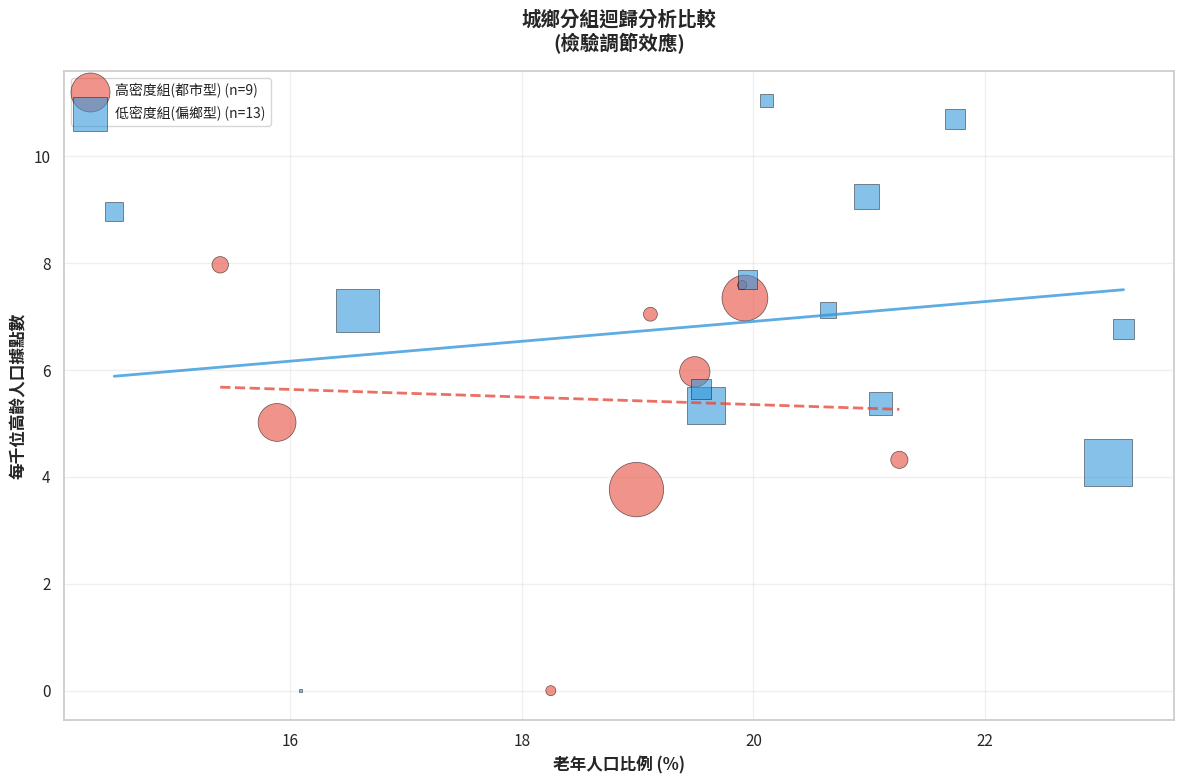

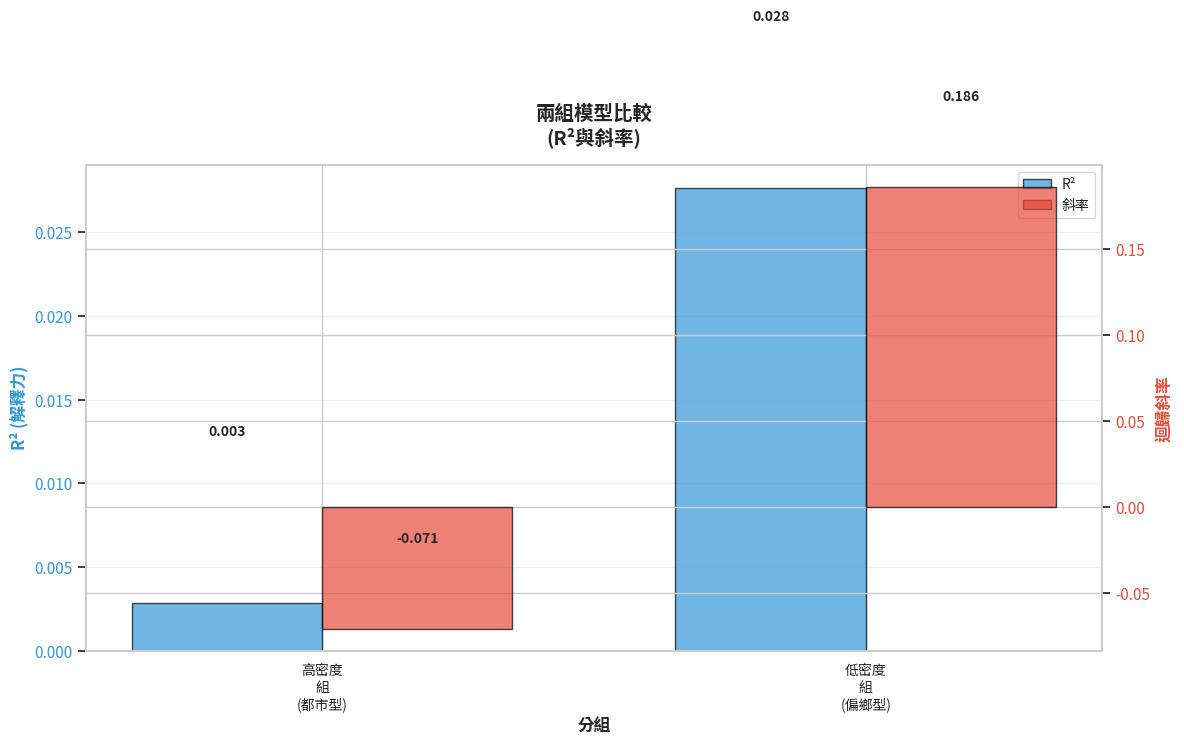

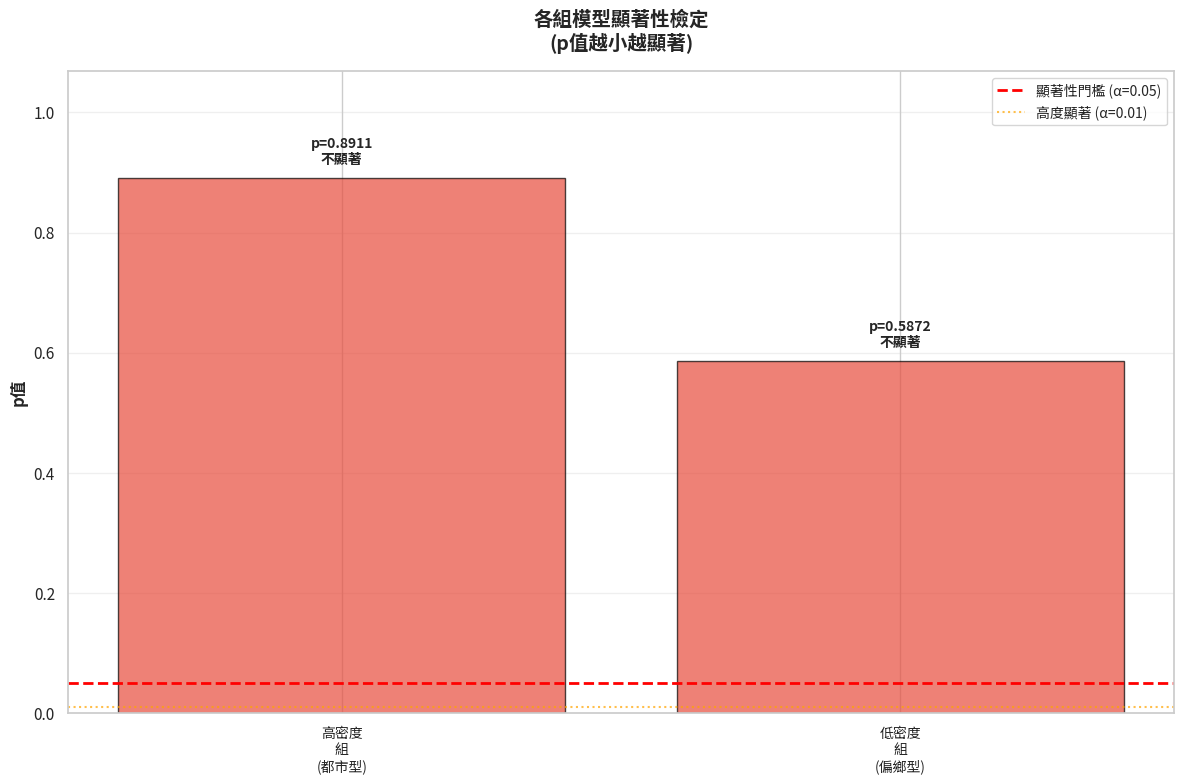

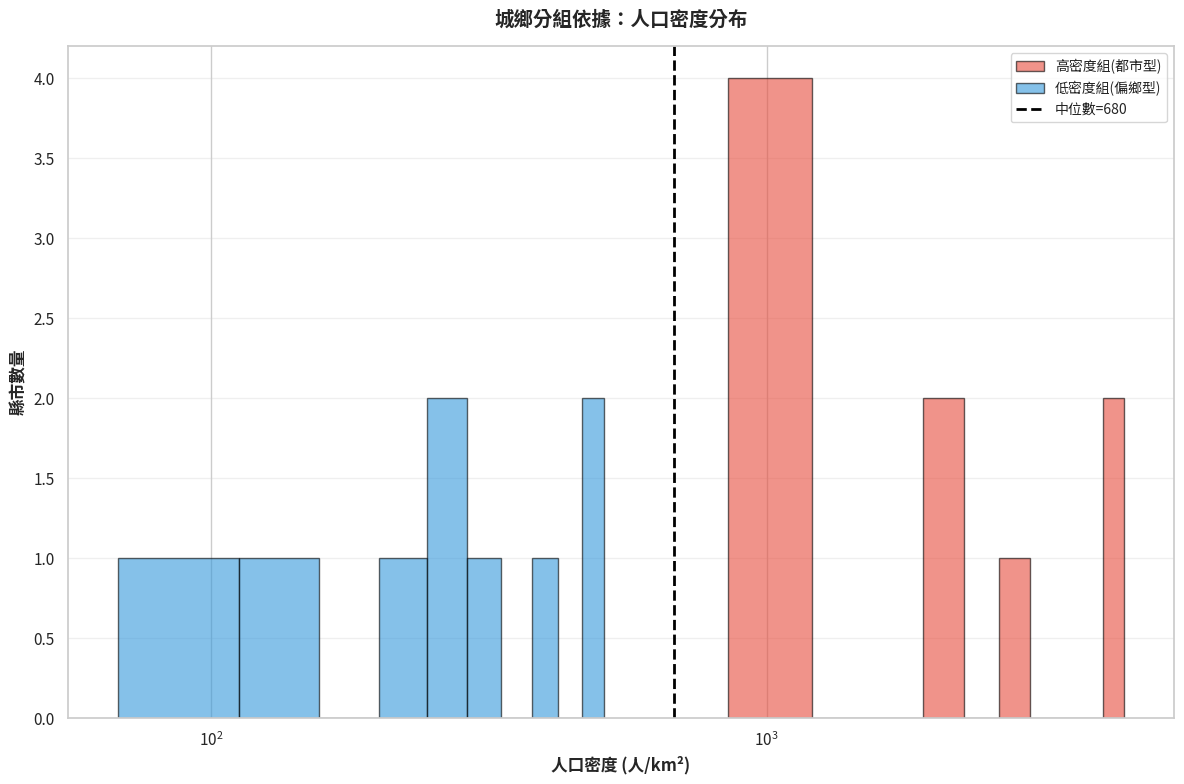

✓ 城鄉分組分析視覺化完成


In [389]:
# =========================
# 城鄉分組分析視覺化 | Urban-Rural Analysis Visualization
# =========================

print("\n生成城鄉分組分析視覺化...")

# 圖1: 兩組迴歸線比較 | Chart 1: Regression Lines Comparison
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))

if len(stratified_results) == 2:
    for group_name, group_result in stratified_results.items():
        # 獲取該組資料
        df_group = df[df["城鄉分組"] == group_name][
            ["老年人口比例(%)", "每千位高齡人口據點數", "65歲以上"]
        ].dropna()

        if len(df_group) > 0:
            x_group = df_group["老年人口比例(%)"].values
            y_group = df_group["每千位高齡人口據點數"].values
            size_group = df_group["65歲以上"].values / 500

            # 繪製散佈圖
            color = "#e74c3c" if "高密度" in group_name else "#3498db"
            marker = "o" if "高密度" in group_name else "s"
            ax1.scatter(
                x_group,
                y_group,
                s=size_group,
                alpha=0.6,
                color=color,
                edgecolors="black",
                linewidth=0.5,
                marker=marker,
                label=f"{group_name} (n={len(df_group)})",
            )

            # 繪製迴歸線
            x_line = np.linspace(x_group.min(), x_group.max(), 100)
            y_line = group_result["intercept"] + group_result["slope"] * x_line
            ax1.plot(
                x_line,
                y_line,
                color=color,
                linewidth=2,
                alpha=0.8,
                linestyle="--" if "高密度" in group_name else "-",
            )

ax1.set_xlabel("老年人口比例 (%)", fontsize=12, fontweight="bold")
ax1.set_ylabel("每千位高齡人口據點數", fontsize=12, fontweight="bold")
ax1.set_title(
    "城鄉分組迴歸分析比較\n(檢驗調節效應)", fontsize=14, fontweight="bold", pad=15
)
ax1.legend(fontsize=10, loc="upper left")
ax1.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 圖2: R²與斜率比較 | Chart 2: R² and Slope Comparison
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

if len(stratified_results) == 2:
    groups = list(stratified_results.keys())
    r2_values = [stratified_results[g]["r_squared"] for g in groups]
    slopes = [stratified_results[g]["slope"] for g in groups]

    x_pos = np.arange(len(groups))
    width = 0.35

    ax2_twin = ax2.twinx()

    bars1 = ax2.bar(
        x_pos - width / 2,
        r2_values,
        width,
        label="R²",
        color="#3498db",
        alpha=0.7,
        edgecolor="black",
    )
    bars2 = ax2_twin.bar(
        x_pos + width / 2,
        slopes,
        width,
        label="斜率",
        color="#e74c3c",
        alpha=0.7,
        edgecolor="black",
    )

    ax2.set_xlabel("分組", fontsize=12, fontweight="bold")
    ax2.set_ylabel("R² (解釋力)", fontsize=12, fontweight="bold", color="#3498db")
    ax2_twin.set_ylabel("迴歸斜率", fontsize=12, fontweight="bold", color="#e74c3c")
    ax2.set_title("兩組模型比較\n(R²與斜率)", fontsize=14, fontweight="bold", pad=15)
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(
        [g.replace("組", "\n組").replace("(", "\n(") for g in groups], fontsize=10
    )
    ax2.tick_params(axis="y", labelcolor="#3498db")
    ax2_twin.tick_params(axis="y", labelcolor="#e74c3c")
    ax2.grid(True, alpha=0.3, axis="y")

    # 添加數值標籤
    for i, (r2, slope) in enumerate(zip(r2_values, slopes)):
        ax2.text(
            i - width / 2,
            r2 + 0.01,
            f"{r2:.3f}",
            ha="center",
            fontsize=10,
            fontweight="bold",
        )
        ax2_twin.text(
            i + width / 2,
            slope + 0.05,
            f"{slope:.3f}",
            ha="center",
            fontsize=10,
            fontweight="bold",
        )

    # 合併圖例
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right", fontsize=10)

plt.tight_layout()
plt.show()

# 圖3: 顯著性p值比較 | Chart 3: Significance p-value Comparison
fig3, ax3 = plt.subplots(1, 1, figsize=(12, 8))

if len(stratified_results) == 2:
    groups = list(stratified_results.keys())
    p_values_groups = [stratified_results[g]["p_value"] for g in groups]

    colors_sig = ["#2ecc71" if p < 0.05 else "#e74c3c" for p in p_values_groups]
    bars = ax3.bar(
        groups, p_values_groups, color=colors_sig, alpha=0.7, edgecolor="black"
    )
    ax3.axhline(
        0.05, color="red", linestyle="--", linewidth=2, label="顯著性門檻 (α=0.05)"
    )
    ax3.axhline(
        0.01,
        color="orange",
        linestyle=":",
        linewidth=1.5,
        alpha=0.7,
        label="高度顯著 (α=0.01)",
    )

    ax3.set_ylabel("p值", fontsize=12, fontweight="bold")
    ax3.set_title(
        "各組模型顯著性檢定\n(p值越小越顯著)", fontsize=14, fontweight="bold", pad=15
    )
    ax3.set_xticks(range(len(groups)))
    ax3.set_xticklabels(
        [g.replace("組", "\n組").replace("(", "\n(") for g in groups], fontsize=10
    )
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3, axis="y")
    ax3.set_ylim(0, max(p_values_groups) * 1.2)

    # 添加p值標籤
    for i, (bar, p) in enumerate(zip(bars, p_values_groups)):
        height = bar.get_height()
        sig_text = (
            "顯著 ***"
            if p < 0.001
            else "顯著 **"
            if p < 0.01
            else "顯著 *"
            if p < 0.05
            else "不顯著"
        )
        ax3.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + max(p_values_groups) * 0.02,
            f"p={p:.4f}\n{sig_text}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

plt.tight_layout()
plt.show()

# 圖4: 城鄉分組縣市分布地圖式呈現 | Chart 4: City Distribution by Group
fig4, ax4 = plt.subplots(1, 1, figsize=(12, 8))

if len(stratified_results) == 2:
    # 計算各組的人口密度分布
    for group_name in stratified_results.keys():
        df_group = df[df["城鄉分組"] == group_name]
        density_values = df_group["人口密度(人/km²)"].values

        color = "#e74c3c" if "高密度" in group_name else "#3498db"
        ax4.hist(
            density_values,
            bins=10,
            alpha=0.6,
            color=color,
            edgecolor="black",
            label=group_name,
        )

    ax4.axvline(
        median_density,
        color="black",
        linestyle="--",
        linewidth=2,
        label=f"中位數={median_density:.0f}",
    )
    ax4.set_xlabel("人口密度 (人/km²)", fontsize=12, fontweight="bold")
    ax4.set_ylabel("縣市數量", fontsize=12, fontweight="bold")
    ax4.set_title("城鄉分組依據：人口密度分布", fontsize=14, fontweight="bold", pad=15)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3, axis="y")
    ax4.set_xscale("log")  # 使用對數尺度以更好呈現範圍差異

plt.tight_layout()
plt.show()

print("✓ 城鄉分組分析視覺化完成")

### 6.3 ABC據點加權服務能量分析 | ABC Facility Weighted Service Capacity Analysis


ABC據點加權服務能量分析
ABC Facility Weighted Service Capacity Analysis

【權重設定 | Weight Configuration】
A級據點權重 | A-level weight: 3.0
B級據點權重 | B-level weight: 2.0
C級據點權重 | C-level weight: 1.0

權重依據: A級提供綜合服務能量最大，C級為社區小型服務站
Rationale: A-level provides comprehensive services, C-level serves as community micro-stations

【全國統計摘要 | National Summary】
原始指標 - 平均每千位高齡人口據點數: 6.2874
加權指標 - 平均每千位高齡人口服務能量: 11.6505
平均差異: 85.82%

【服務能量與據點數量差異最大的縣市 | Cities with Largest Differences】

1. 服務能量顯著高於據點數量 (A級據點比例高):
   台北市: 
      A:B:C = 107.0:2077.0:271.0
      據點數指標=4.27, 服務能量指標=8.26, 差異=93.3%
   台南市: 
      A:B:C = 57.0:1686.0:199.0
      據點數指標=5.33, 服務能量指標=10.28, 差異=92.7%
   台中市: 
      A:B:C = 121.0:2880.0:371.0
      據點數指標=7.11, 服務能量指標=13.69, 差異=92.6%
   新竹市: 
      A:B:C = 22.0:474.0:65.0
      據點數指標=7.97, 服務能量指標=15.33, 差異=92.3%
   苗栗縣: 
      A:B:C = 70.0:401.0:118.0
      據點數指標=5.65, 服務能量指標=10.85, 差異=91.9%

2. 服務能量顯著低於據點數量 (C級據點比例高):
   嘉義縣: 
      A:B:C = 18.0:485.0:249.0
      據點數指標=6.77, 服務能量指標=11.46, 差異=

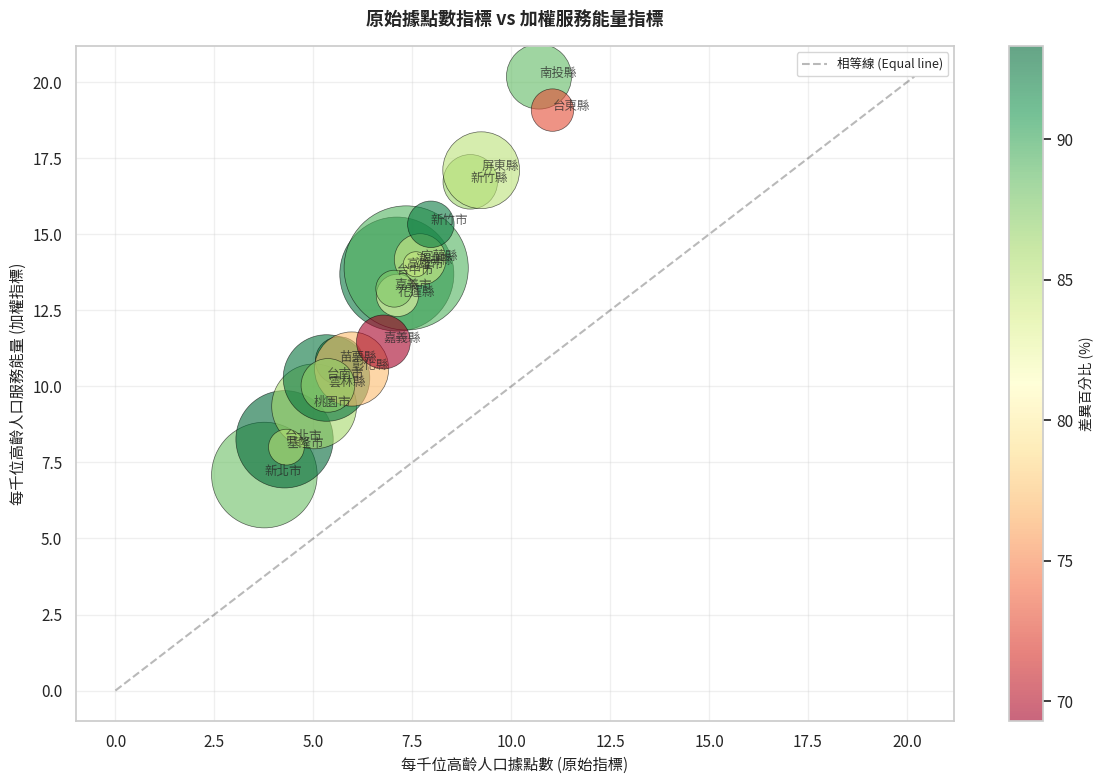

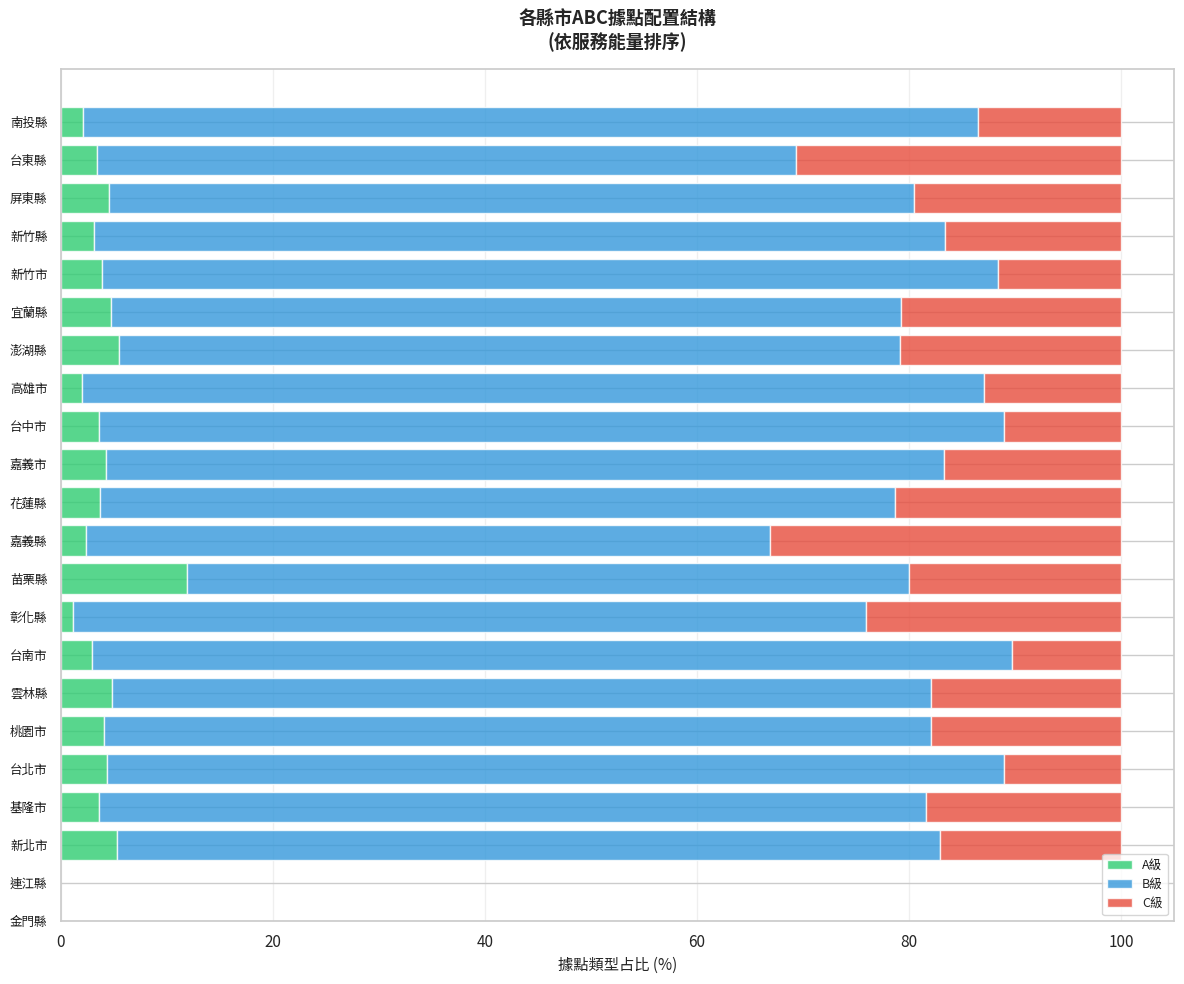


【ABC配置與服務充足度相關性 | Correlation: ABC Structure vs Service Adequacy】
A級據點占比 vs 服務能量: r = nan
B級據點占比 vs 服務能量: r = nan
C級據點占比 vs 服務能量: r = nan

【政策啟示 | Policy Implications】

✓ ABC加權服務能量分析完成 | ABC Weighted Analysis Completed


In [390]:
# =========================
# ABC據點加權服務能量分析 | ABC Weighted Service Capacity Analysis
# =========================

print("\n" + "=" * 80)
print("ABC據點加權服務能量分析")
print("ABC Facility Weighted Service Capacity Analysis")
print("=" * 80)

# 定義權重 (基於服務規模差異) | Define weights based on service scale
# A級: 社區整合型服務中心 (旗艦店)
# B級: 複合型服務中心
# C級: 巷弄長照站
WEIGHT_A = 3.0
WEIGHT_B = 2.0
WEIGHT_C = 1.0

print(f"\n【權重設定 | Weight Configuration】")
print(f"A級據點權重 | A-level weight: {WEIGHT_A}")
print(f"B級據點權重 | B-level weight: {WEIGHT_B}")
print(f"C級據點權重 | C-level weight: {WEIGHT_C}")
print(f"\n權重依據: A級提供綜合服務能量最大，C級為社區小型服務站")
print(
    f"Rationale: A-level provides comprehensive services, C-level serves as community micro-stations"
)

# 計算加權服務能量 | Calculate weighted service capacity
df["加權總服務能量"] = df["A"] * WEIGHT_A + df["B"] * WEIGHT_B + df["C"] * WEIGHT_C
df["每千位高齡人口服務能量"] = (df["加權總服務能量"] / df["65歲以上"]) * 1000

# 與原始指標比較 | Compare with original metric
df["能量與數量差異(%)"] = (
    (df["每千位高齡人口服務能量"] - df["每千位高齡人口據點數"])
    / df["每千位高齡人口據點數"]
    * 100
)

# 統計摘要 | Statistical summary
print(f"\n【全國統計摘要 | National Summary】")
print(f"原始指標 - 平均每千位高齡人口據點數: {df['每千位高齡人口據點數'].mean():.4f}")
print(
    f"加權指標 - 平均每千位高齡人口服務能量: {df['每千位高齡人口服務能量'].mean():.4f}"
)
print(f"平均差異: {df['能量與數量差異(%)'].mean():.2f}%")

# 識別差異最大的縣市 | Identify cities with largest differences
print(f"\n【服務能量與據點數量差異最大的縣市 | Cities with Largest Differences】")
print(f"\n1. 服務能量顯著高於據點數量 (A級據點比例高):")
top_positive = df.nlargest(5, "能量與數量差異(%)")[
    [
        "縣市名稱",
        "A",
        "B",
        "C",
        "總據點數",
        "每千位高齡人口據點數",
        "每千位高齡人口服務能量",
        "能量與數量差異(%)",
    ]
]
for idx, row in top_positive.iterrows():
    print(f"   {row['縣市名稱']}: ")
    print(f"      A:B:C = {row['A']}:{row['B']}:{row['C']}")
    print(
        f"      據點數指標={row['每千位高齡人口據點數']:.2f}, 服務能量指標={row['每千位高齡人口服務能量']:.2f}, 差異={row['能量與數量差異(%)']:.1f}%"
    )

print(f"\n2. 服務能量顯著低於據點數量 (C級據點比例高):")
top_negative = df.nsmallest(5, "能量與數量差異(%)")[
    [
        "縣市名稱",
        "A",
        "B",
        "C",
        "總據點數",
        "每千位高齡人口據點數",
        "每千位高齡人口服務能量",
        "能量與數量差異(%)",
    ]
]
for idx, row in top_negative.iterrows():
    print(f"   {row['縣市名稱']}: ")
    print(f"      A:B:C = {row['A']}:{row['B']}:{row['C']}")
    print(
        f"      據點數指標={row['每千位高齡人口據點數']:.2f}, 服務能量指標={row['每千位高齡人口服務能量']:.2f}, 差異={row['能量與數量差異(%)']:.1f}%"
    )

# 視覺化比較 | Visualization comparison

# 圖1: 據點數 vs 服務能量散佈圖 | Chart 1: Facility count vs service capacity scatter
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))
scatter = ax1.scatter(
    df["每千位高齡人口據點數"],
    df["每千位高齡人口服務能量"],
    s=df["總據點數"] * 2,
    alpha=0.6,
    c=df["能量與數量差異(%)"],
    cmap="RdYlGn",
    edgecolors="black",
    linewidth=0.5,
)

# 添加對角線 (如果兩指標相等) | Add diagonal line (if two metrics are equal)
max_val = max(df["每千位高齡人口據點數"].max(), df["每千位高齡人口服務能量"].max())
ax1.plot([0, max_val], [0, max_val], "k--", alpha=0.3, label="相等線 (Equal line)")

# 標註極端值 | Label extreme values
for idx, row in df.iterrows():
    if abs(row["能量與數量差異(%)"]) > 50:  # 差異超過50%才標註
        ax1.annotate(
            row["縣市名稱"],
            (row["每千位高齡人口據點數"], row["每千位高齡人口服務能量"]),
            fontsize=9,
            alpha=0.7,
        )

ax1.set_xlabel("每千位高齡人口據點數 (原始指標)", fontsize=11)
ax1.set_ylabel("每千位高齡人口服務能量 (加權指標)", fontsize=11)
ax1.set_title(
    "原始據點數指標 vs 加權服務能量指標", fontsize=13, fontweight="bold", pad=15
)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# 添加色條 | Add colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label("差異百分比 (%)", fontsize=10)

plt.tight_layout()
plt.show()

# 圖2: 各縣市ABC配置結構 | Chart 2: ABC facility structure by city
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 10))
df_sorted = df.sort_values("每千位高齡人口服務能量", ascending=True)
x_pos = np.arange(len(df_sorted))

# 計算各級據點占比 | Calculate proportion of each level
df_sorted["A_ratio"] = df_sorted["A"] / df_sorted["總據點數"] * 100
df_sorted["B_ratio"] = df_sorted["B"] / df_sorted["總據點數"] * 100
df_sorted["C_ratio"] = df_sorted["C"] / df_sorted["總據點數"] * 100

# 堆疊橫向長條圖 | Stacked horizontal bar chart
ax2.barh(x_pos, df_sorted["A_ratio"], label="A級", color="#2ecc71", alpha=0.8)
ax2.barh(
    x_pos,
    df_sorted["B_ratio"],
    left=df_sorted["A_ratio"],
    label="B級",
    color="#3498db",
    alpha=0.8,
)
ax2.barh(
    x_pos,
    df_sorted["C_ratio"],
    left=df_sorted["A_ratio"] + df_sorted["B_ratio"],
    label="C級",
    color="#e74c3c",
    alpha=0.8,
)

ax2.set_yticks(x_pos)
ax2.set_yticklabels(df_sorted["縣市名稱"], fontsize=9)
ax2.set_xlabel("據點類型占比 (%)", fontsize=11)
ax2.set_title(
    "各縣市ABC據點配置結構\n(依服務能量排序)", fontsize=13, fontweight="bold", pad=15
)
ax2.legend(loc="lower right", fontsize=9)
ax2.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

# 相關性分析：ABC配置與服務充足度 | Correlation: ABC structure vs service adequacy
print(
    "\n【ABC配置與服務充足度相關性 | Correlation: ABC Structure vs Service Adequacy】"
)
a_ratio = df["A"] / df["總據點數"]
b_ratio = df["B"] / df["總據點數"]
c_ratio = df["C"] / df["總據點數"]

corr_a = np.corrcoef(a_ratio, df["每千位高齡人口服務能量"])[0, 1]
corr_b = np.corrcoef(b_ratio, df["每千位高齡人口服務能量"])[0, 1]
corr_c = np.corrcoef(c_ratio, df["每千位高齡人口服務能量"])[0, 1]

print(f"A級據點占比 vs 服務能量: r = {corr_a:.4f}")
print(f"B級據點占比 vs 服務能量: r = {corr_b:.4f}")
print(f"C級據點占比 vs 服務能量: r = {corr_c:.4f}")

print("\n【政策啟示 | Policy Implications】")
if corr_a > 0.3:
    print("✓ A級據點比例與服務能量呈正相關，建議資源不足縣市優先設置A級據點")
if abs(corr_c) > abs(corr_a):
    print("✓ C級據點占比高的縣市，服務能量相對較低，應調整配置結構")

print("\n✓ ABC加權服務能量分析完成 | ABC Weighted Analysis Completed")

### 6.4 時間序列分析：資源配置動態追蹤 (104-113年) | Time Series Analysis: Resource Allocation Dynamics


時間序列分析：資源配置動態追蹤 (104-113年)
Time Series Analysis: Resource Allocation Dynamics (2015-2024)
載入人口資料 | Loading population data: 程式用-縣市人口按性別及五齡組.csv
  ✓ 資料筆數 | Records: 220
  ✓ 縣市數量 | Cities: 22
  ✓ 年份範圍 | Year range: 104-113

合併後資料檢查 | Data check after merge:
  總縣市數 | Total cities: 22
  有據點資料的縣市數 | Cities with facility data: 22
  缺失據點資料的縣市 | Cities missing facility data:
    (無)

【各縣市老化速度排名 | Aging Speed Ranking】


,排名 Rank,縣市 City,104年老化率 2015 Rate (%),113年老化率 2024 Rate (%),年均增長 Annual Growth (pp),總增長 Total (pp)
0,1,台 北 市,14.76,23.06,0.830,8.30
1,2,新 北 市,10.81,18.99,0.818,8.18
2,3,基 隆 市,13.20,21.26,0.806,8.06
3,4,高 雄 市,12.61,19.93,0.732,7.32
4,5,金 門 縣,11.18,18.25,0.707,7.07
5,6,花 蓮 縣,14.07,20.65,0.658,6.58
6,7,南 投 縣,15.21,21.74,0.653,6.53
7,8,台 南 市,13.09,19.59,0.650,6.50
8,9,屏 東 縣,14.49,20.97,0.648,6.48
9,10,嘉 義 市,12.74,19.11,0.637,6.37



【老化速度與資源配置相關性分析 | Correlation: Aging Speed vs Resource Allocation】
Pearson r = -0.3951
樣本數 | n = 22
t統計量 | t-statistic = -1.9234
p-value = 0.0688

解讀 | Interpretation:
  老化速度與資源配置呈負相關 (r=-0.3951)
  這表示：老化快的縣市資源反而較少，存在配置悖論

【資源配置失衡指數排名 | Resource Allocation Imbalance Index Ranking】


,排名 Rank,縣市 City,老化速度 Aging Speed (pp/yr),每千位據點數 Facilities/1000,老化速度Z Aging Z,資源配置Z Resource Z,失衡指數 Imbalance Index
0,1,金 門 縣,0.707,0.00,0.72,-2.24,2.96
1,2,新 北 市,0.818,3.76,1.63,-0.90,2.53
2,3,台 北 市,0.830,4.27,1.73,-0.72,2.45
3,4,連 江 縣,0.627,0.00,0.06,-2.24,2.31
4,5,基 隆 市,0.806,4.32,1.53,-0.70,2.23
5,6,台 南 市,0.650,5.33,0.25,-0.34,0.59
6,7,高 雄 市,0.732,7.35,0.92,0.38,0.54
7,8,桃 園 市,0.621,5.02,0.01,-0.45,0.47
8,9,花 蓮 縣,0.658,7.13,0.31,0.30,0.01
9,10,嘉 義 市,0.637,7.05,0.15,0.27,-0.13



老化速度快但資源配置不足的縣市 (配置失衡指數>1):
  金 門 縣: 
    老化速度=0.707 pp/年 (Z=0.72)
    資源配置=0.00 (Z=-2.24)
    配置失衡指數=2.96
  新 北 市: 
    老化速度=0.818 pp/年 (Z=1.63)
    資源配置=3.76 (Z=-0.90)
    配置失衡指數=2.53
  台 北 市: 
    老化速度=0.830 pp/年 (Z=1.73)
    資源配置=4.27 (Z=-0.72)
    配置失衡指數=2.45
  連 江 縣: 
    老化速度=0.627 pp/年 (Z=0.06)
    資源配置=0.00 (Z=-2.24)
    配置失衡指數=2.31
  基 隆 市: 
    老化速度=0.806 pp/年 (Z=1.53)
    資源配置=4.32 (Z=-0.70)
    配置失衡指數=2.23


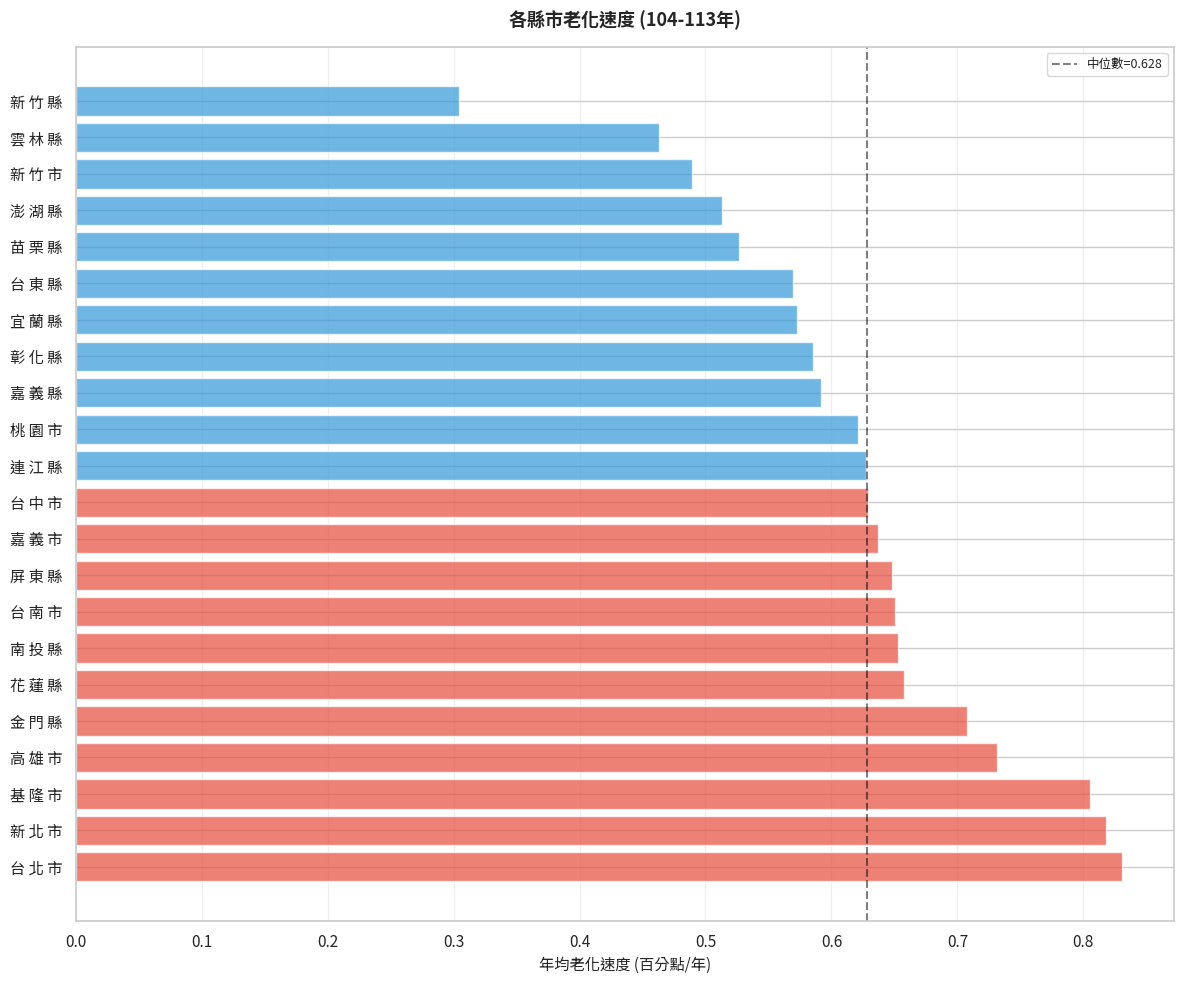

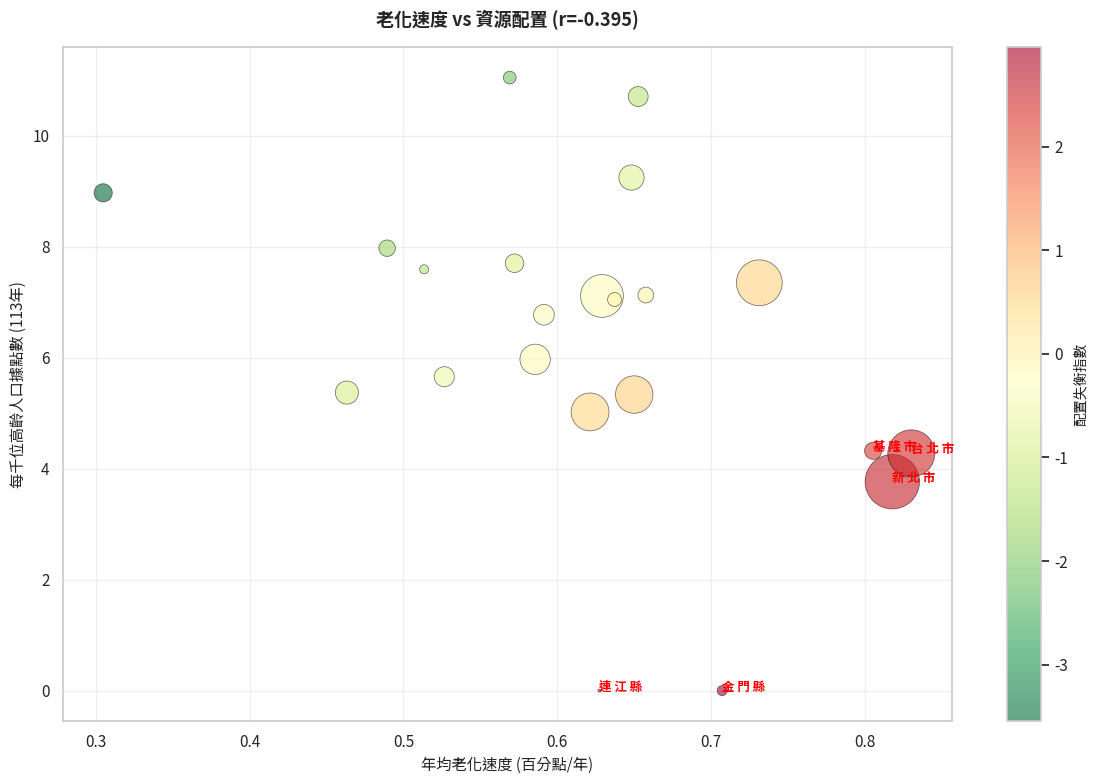

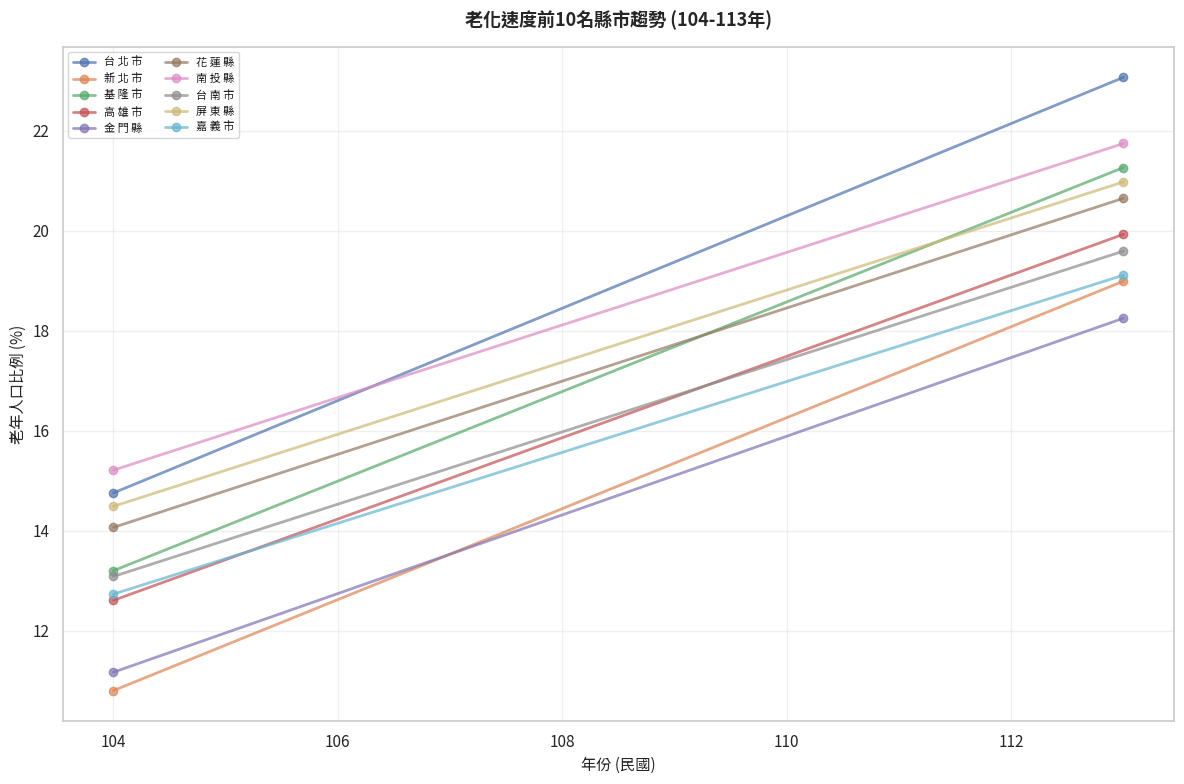

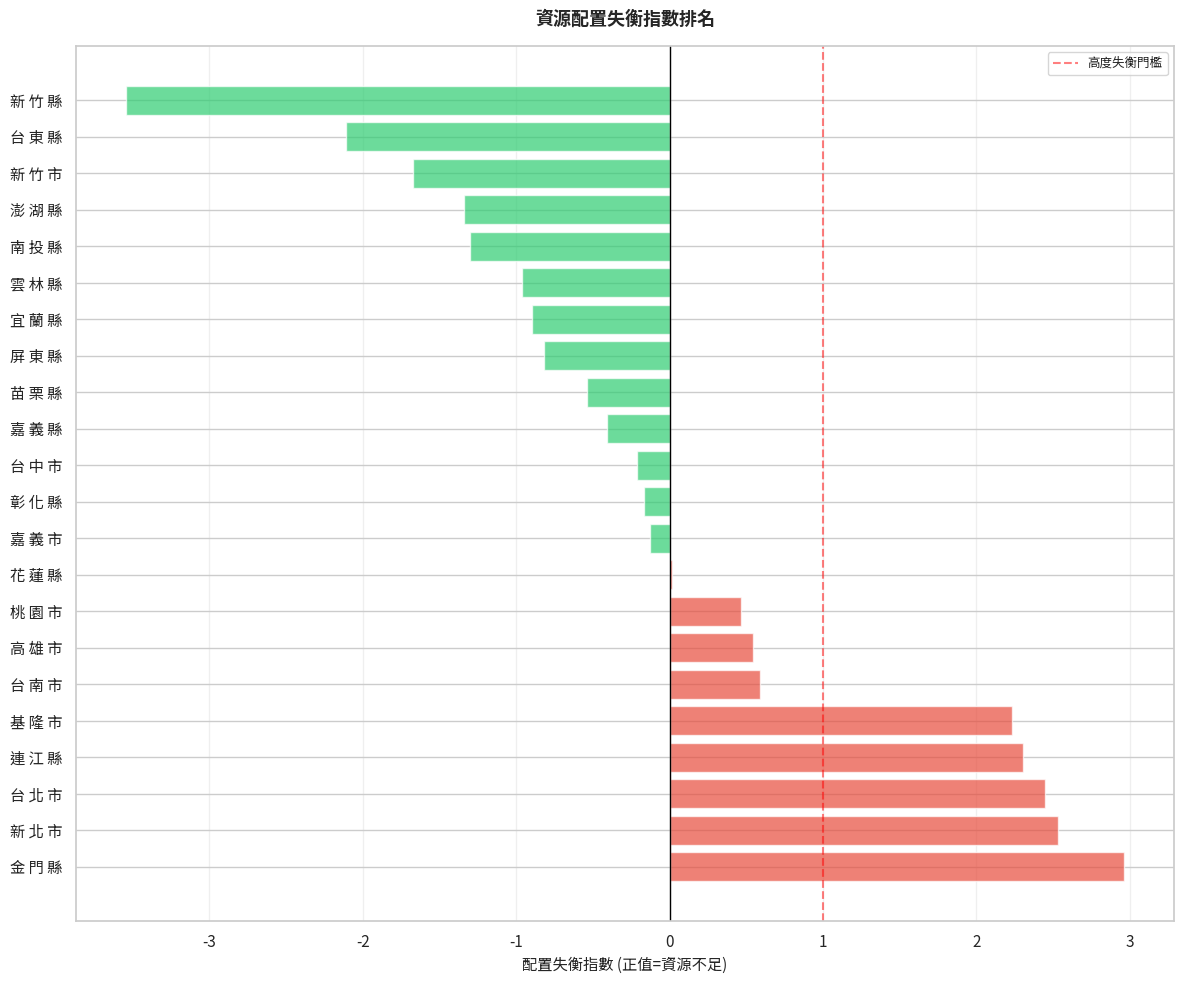


✓ 時間序列分析完成 | Time Series Analysis Completed


In [391]:
# =========================
# 時間序列分析 (104-113年) | Time Series Analysis (2015-2024)
# =========================

print("\n" + "=" * 80)
print("時間序列分析：資源配置動態追蹤 (104-113年)")
print("Time Series Analysis: Resource Allocation Dynamics (2015-2024)")
print("=" * 80)

# 重新載入完整的人口時間序列資料 | Reload complete population time series data
df_pop_full = load_population_data("程式用-縣市人口按性別及五齡組.csv")

# 計算各年度各縣市的老年人口比例 | Calculate aging rate for each year and city
df_time_series = df_pop_full.copy()

# 篩選104年和113年進行比較 | Filter years 104 and 113 for comparison
df_104 = df_time_series[df_time_series["年份"] == 104][
    ["區域別", "老年人口比例(%)"]
].copy()
df_113 = df_time_series[df_time_series["年份"] == 113][
    ["區域別", "老年人口比例(%)"]
].copy()

df_104.columns = ["縣市名稱", "104年老化率"]
df_113.columns = ["縣市名稱", "113年老化率"]

# 合併資料 | Merge data
df_aging_change = df_104.merge(df_113, on="縣市名稱", how="inner")

# 計算老化速度 (年均增長百分點) | Calculate aging speed (annual growth in percentage points)
df_aging_change["老化速度(年均增長百分點)"] = (
    df_aging_change["113年老化率"] - df_aging_change["104年老化率"]
) / 10
df_aging_change["老化速度(總增長百分點)"] = (
    df_aging_change["113年老化率"] - df_aging_change["104年老化率"]
)

# 合併當前據點資料 | Merge current facility data
# 從 df 中提取據點資料，確保縣市名稱一致
df_facilities = df[["縣市名稱", "總據點數", "每千位高齡人口據點數", "65歲以上"]].copy()
df_facilities["縣市名稱_標準"] = df_facilities["縣市名稱"].str.replace(" ", "")

# 標準化 df_aging_change 的縣市名稱
df_aging_change["縣市名稱_標準"] = df_aging_change["縣市名稱"].str.replace(" ", "")

# 使用標準化後的縣市名稱進行合併
df_aging_change = df_aging_change.merge(
    df_facilities[["縣市名稱_標準", "總據點數", "每千位高齡人口據點數", "65歲以上"]],
    on="縣市名稱_標準",
    how="left",
)

# 顯示合併後的資料檢查
print(f"\n合併後資料檢查 | Data check after merge:")
print(f"  總縣市數 | Total cities: {len(df_aging_change)}")
print(f"  有據點資料的縣市數 | Cities with facility data: {df_aging_change['總據點數'].notna().sum()}")
print(f"  缺失據點資料的縣市 | Cities missing facility data:")
missing_cities = df_aging_change[df_aging_change['總據點數'].isna()]['縣市名稱'].tolist()
if missing_cities:
    for city in missing_cities:
        print(f"    - {city}")
else:
    print(f"    (無)")

# 排序並顯示 | Sort and display
print("\n【各縣市老化速度排名 | Aging Speed Ranking】")

df_aging_change_sorted = df_aging_change.sort_values(
    "老化速度(年均增長百分點)", ascending=False
).reset_index(drop=True)

# 建立排名表格 | Create ranking table
df_aging_ranking = df_aging_change_sorted[
    ["縣市名稱", "104年老化率", "113年老化率", "老化速度(年均增長百分點)", "老化速度(總增長百分點)"]
].copy()
df_aging_ranking.insert(0, "排名", range(1, len(df_aging_ranking) + 1))

# 格式化欄位名稱 | Format column names
df_aging_ranking.columns = [
    "排名 Rank",
    "縣市 City",
    "104年老化率 2015 Rate (%)",
    "113年老化率 2024 Rate (%)",
    "年均增長 Annual Growth (pp)",
    "總增長 Total (pp)",
]

# 使用 pandas 顯示表格 | Display table using pandas
display(df_aging_ranking.style.format({
    "104年老化率 2015 Rate (%)": "{:.2f}",
    "113年老化率 2024 Rate (%)": "{:.2f}",
    "年均增長 Annual Growth (pp)": "{:.3f}",
    "總增長 Total (pp)": "{:.2f}",
}).set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
]))

# 分析：老化速度與資源配置的關係 | Analysis: Relationship between aging speed and resource allocation
print(
    "\n【老化速度與資源配置相關性分析 | Correlation: Aging Speed vs Resource Allocation】"
)

# 過濾有效資料 | Filter valid data
df_corr = df_aging_change.dropna(
    subset=["老化速度(年均增長百分點)", "每千位高齡人口據點數", "65歲以上"]
).copy()

# 確保有足夠的資料點 | Ensure sufficient data points
if len(df_corr) < 3:
    print(f"⚠ 警告：有效資料點不足 (n={len(df_corr)})，無法進行相關性分析")
    corr_aging_resource = np.nan
    n_corr = len(df_corr)
    t_stat_corr = np.nan
    p_value_corr = np.nan
else:
    # 計算相關係數 | Calculate correlation coefficient
    n_corr = len(df_corr)
    corr_aging_resource = np.corrcoef(
        df_corr["老化速度(年均增長百分點)"],
        df_corr["每千位高齡人口據點數"]
    )[0, 1]
    
    # t檢定 | t-test
    if not np.isnan(corr_aging_resource) and abs(corr_aging_resource) < 1:
        t_stat_corr = (
            corr_aging_resource * np.sqrt(n_corr - 2) / np.sqrt(1 - corr_aging_resource**2)
        )
        p_value_corr = 2 * (1 - stats.t.cdf(abs(t_stat_corr), n_corr - 2))
    else:
        t_stat_corr = np.nan
        p_value_corr = np.nan

    print(f"Pearson r = {corr_aging_resource:.4f}")
    print(f"樣本數 | n = {n_corr}")
    if not np.isnan(t_stat_corr):
        print(f"t統計量 | t-statistic = {t_stat_corr:.4f}")
        print(f"p-value = {p_value_corr:.4f}")
    
    print(f"\n解讀 | Interpretation:")
    if np.isnan(corr_aging_resource):
        print("  ⚠ 相關係數無法計算 (資料不足或異常)")
    elif abs(corr_aging_resource) < 0.3:
        print("  老化速度與當前資源配置之間相關性弱 (|r|<0.3)")
        print(f"  這表示：資源配置可能未充分響應人口老化的動態變化")
    elif corr_aging_resource > 0.3:
        print(f"  老化速度與資源配置呈正相關 (r={corr_aging_resource:.4f})")
        print(f"  這表示：老化快的縣市獲得較多資源，政策有一定的回應性")
    else:
        print(f"  老化速度與資源配置呈負相關 (r={corr_aging_resource:.4f})")
        print(f"  這表示：老化快的縣市資源反而較少，存在配置悖論")

# 識別資源配置落後於老化趨勢的縣市 | Identify cities where resource allocation lags behind aging trend
if len(df_corr) >= 3:
    # 標準化分數 | Standardized scores
    aging_mean = df_corr["老化速度(年均增長百分點)"].mean()
    aging_std = df_corr["老化速度(年均增長百分點)"].std()
    resource_mean = df_corr["每千位高齡人口據點數"].mean()
    resource_std = df_corr["每千位高齡人口據點數"].std()
    
    # 避免除以零
    if aging_std > 0 and resource_std > 0:
        df_corr["老化速度_Z"] = (df_corr["老化速度(年均增長百分點)"] - aging_mean) / aging_std
        df_corr["資源配置_Z"] = (df_corr["每千位高齡人口據點數"] - resource_mean) / resource_std
        df_corr["配置失衡指數"] = df_corr["老化速度_Z"] - df_corr["資源配置_Z"]
    else:
        df_corr["老化速度_Z"] = 0.0
        df_corr["資源配置_Z"] = 0.0
        df_corr["配置失衡指數"] = 0.0
        print("⚠ 警告：標準差為零，無法計算標準化分數")
else:
    df_corr["老化速度_Z"] = 0.0
    df_corr["資源配置_Z"] = 0.0
    df_corr["配置失衡指數"] = 0.0

# 失衡指數 > 1: 老化快但資源少 | Imbalance index > 1: fast aging but insufficient resources
high_imbalance = df_corr[df_corr["配置失衡指數"] > 1].sort_values(
    "配置失衡指數", ascending=False
)

print("\n【資源配置失衡指數排名 | Resource Allocation Imbalance Index Ranking】")

# 建立失衡指數排名表格 | Create imbalance index ranking table
df_imbalance_ranking = df_corr[
    ["縣市名稱", "老化速度(年均增長百分點)", "每千位高齡人口據點數", "老化速度_Z", "資源配置_Z", "配置失衡指數"]
].sort_values("配置失衡指數", ascending=False).reset_index(drop=True)
df_imbalance_ranking.insert(0, "排名", range(1, len(df_imbalance_ranking) + 1))

# 格式化欄位名稱 | Format column names
df_imbalance_ranking.columns = [
    "排名 Rank",
    "縣市 City",
    "老化速度 Aging Speed (pp/yr)",
    "每千位據點數 Facilities/1000",
    "老化速度Z Aging Z",
    "資源配置Z Resource Z",
    "失衡指數 Imbalance Index",
]

# 使用 pandas 顯示表格 | Display table using pandas
display(df_imbalance_ranking.style.format({
    "老化速度 Aging Speed (pp/yr)": "{:.3f}",
    "每千位據點數 Facilities/1000": "{:.2f}",
    "老化速度Z Aging Z": "{:.2f}",
    "資源配置Z Resource Z": "{:.2f}",
    "失衡指數 Imbalance Index": "{:.2f}",
}).set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
]))

if len(high_imbalance) > 0:
    print("\n老化速度快但資源配置不足的縣市 (配置失衡指數>1):")
    for idx, row in high_imbalance.iterrows():
        print(f"  {row['縣市名稱']}: ")
        print(
            f"    老化速度={row['老化速度(年均增長百分點)']:.3f} pp/年 (Z={row['老化速度_Z']:.2f})"
        )
        print(
            f"    資源配置={row['每千位高齡人口據點數']:.2f} (Z={row['資源配置_Z']:.2f})"
        )
        print(f"    配置失衡指數={row['配置失衡指數']:.2f}")
else:
    print("  無顯著失衡縣市")

# 視覺化 | Visualization

# 圖1: 老化速度排名 | Chart 1: Aging speed ranking
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 10))
colors_1 = [
    "#e74c3c"
    if x > df_aging_change_sorted["老化速度(年均增長百分點)"].median()
    else "#3498db"
    for x in df_aging_change_sorted["老化速度(年均增長百分點)"]
]
ax1.barh(
    df_aging_change_sorted["縣市名稱"],
    df_aging_change_sorted["老化速度(年均增長百分點)"],
    color=colors_1,
    alpha=0.7,
)
ax1.axvline(
    df_aging_change_sorted["老化速度(年均增長百分點)"].median(),
    color="black",
    linestyle="--",
    label=f"中位數={df_aging_change_sorted['老化速度(年均增長百分點)'].median():.3f}",
    alpha=0.5,
)
ax1.set_xlabel("年均老化速度 (百分點/年)", fontsize=11)
ax1.set_title("各縣市老化速度 (104-113年)", fontsize=13, fontweight="bold", pad=15)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

# 圖2: 老化速度 vs 資源配置 散佈圖 | Chart 2: Aging speed vs resource allocation scatter
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))
scatter = ax2.scatter(
    df_corr["老化速度(年均增長百分點)"],
    df_corr["每千位高齡人口據點數"],
    s=df_corr["65歲以上"] / 500,
    alpha=0.6,
    c=df_corr["配置失衡指數"],
    cmap="RdYlGn_r",
    edgecolors="black",
    linewidth=0.5,
)

# 標註失衡縣市 | Label imbalanced cities
for idx, row in high_imbalance.iterrows():
    ax2.annotate(
        row["縣市名稱"],
        (row["老化速度(年均增長百分點)"], row["每千位高齡人口據點數"]),
        fontsize=9,
        fontweight="bold",
        color="red",
    )

ax2.set_xlabel("年均老化速度 (百分點/年)", fontsize=11)
ax2.set_ylabel("每千位高齡人口據點數 (113年)", fontsize=11)

# 處理 corr_aging_resource 可能為 NaN 的情況
if not np.isnan(corr_aging_resource):
    ax2.set_title(
        f"老化速度 vs 資源配置 (r={corr_aging_resource:.3f})",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )
else:
    ax2.set_title(
        "老化速度 vs 資源配置",
        fontsize=13,
        fontweight="bold",
        pad=15,
    )

ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label("配置失衡指數", fontsize=10)
plt.tight_layout()
plt.show()

# 圖3: 104年vs113年老化率變化 | Chart 3: Aging rate change from 2015 to 2024
fig3, ax3 = plt.subplots(1, 1, figsize=(12, 8))
for idx, row in df_aging_change_sorted.head(10).iterrows():  # 只顯示前10名
    ax3.plot(
        [104, 113],
        [row["104年老化率"], row["113年老化率"]],
        marker="o",
        label=row["縣市名稱"],
        linewidth=2,
        alpha=0.7,
    )
ax3.set_xlabel("年份 (民國)", fontsize=11)
ax3.set_ylabel("老年人口比例 (%)", fontsize=11)
ax3.set_title(
    "老化速度前10名縣市趨勢 (104-113年)", fontsize=13, fontweight="bold", pad=15
)
ax3.legend(fontsize=8, loc="upper left", ncol=2)
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 圖4: 配置失衡指數排名 | Chart 4: Allocation imbalance index ranking
fig4, ax4 = plt.subplots(1, 1, figsize=(12, 10))
df_corr_sorted = df_corr.sort_values("配置失衡指數", ascending=False)
colors_4 = ["#e74c3c" if x > 0 else "#2ecc71" for x in df_corr_sorted["配置失衡指數"]]
ax4.barh(
    df_corr_sorted["縣市名稱"],
    df_corr_sorted["配置失衡指數"],
    color=colors_4,
    alpha=0.7,
)
ax4.axvline(0, color="black", linestyle="-", linewidth=1)
ax4.axvline(1, color="red", linestyle="--", label="高度失衡門檻", alpha=0.5)
ax4.set_xlabel("配置失衡指數 (正值=資源不足)", fontsize=11)
ax4.set_title("資源配置失衡指數排名", fontsize=13, fontweight="bold", pad=15)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print("\n✓ 時間序列分析完成 | Time Series Analysis Completed")

### 6.5 鄉鎮層級分析：縣市內部資源分布不均 | Township-Level Analysis: Intra-City Resource Distribution


鄉鎮層級分析：縣市內部資源分布不均
Township-Level Analysis: Intra-City Resource Distribution Inequality
載入長照據點資料 | Loading LTC data: data/長照ABC據點.csv
  ✓ 有效據點數 | Valid facilities: 26469
  ✓ 據點類型分布 | Facility type distribution:
據點類型
B    21282
C     4208
A      979

【各縣市鄉鎮區資料檢查 | Township Data Check】
  台北市: 14 個鄉鎮區, 2455 筆據點資料
  新北市: 33 個鄉鎮區, 2891 筆據點資料
  桃園市: 16 個鄉鎮區, 1864 筆據點資料
  台中市: 31 個鄉鎮區, 3372 筆據點資料
  台南市: 42 個鄉鎮區, 1941 筆據點資料
  高雄市: 40 個鄉鎮區, 3999 筆據點資料

【資料統計 | Data Statistics】
分析鄉鎮區數: 397
涵蓋縣市數: 20

【六都鄉鎮區統計 | Six Special Municipalities Township Statistics】

【各縣市鄉鎮區資料檢查 | Township Data Check】
  台北市: 14 個鄉鎮區, 2455 筆據點資料
  新北市: 33 個鄉鎮區, 2891 筆據點資料
  桃園市: 16 個鄉鎮區, 1864 筆據點資料
  台中市: 31 個鄉鎮區, 3372 筆據點資料
  台南市: 42 個鄉鎮區, 1941 筆據點資料
  高雄市: 40 個鄉鎮區, 3999 筆據點資料

【資料統計 | Data Statistics】
分析鄉鎮區數: 397
涵蓋縣市數: 20

【六都鄉鎮區統計 | Six Special Municipalities Township Statistics】


,縣市 City,鄉鎮區數 Townships,據點總數 Total,平均據點數 Mean,標準差 Std Dev,變異係數 CV (%),據點最多 Max,據點最少 Min
0,台北市,14,2455,175.36,90.15,51.41,中山區 (293個),信義區市 (1個)
1,新北市,33,2891,87.61,107.52,122.73,板橋區 (415個),汐止區鄉 (1個)
2,桃園市,16,1864,116.50,117.40,100.77,桃園區 (442個),平鎮區平鎮 (1個)
3,台中市,31,3372,108.77,84.02,77.24,北屯區 (320個),大甲區鎮 (1個)
4,台南市,42,1941,46.21,59.62,129.01,永康區 (271個),新營區護鎮 (1個)
5,高雄市,40,3999,99.97,130.50,130.53,三民區 (600個),安平區 (1個)



【六都縣市內部資源分布不均程度排名 | Intra-City Inequality Ranking】
(變異係數越高，表示鄉鎮間分布越不均)


,排名 Rank,縣市 City,鄉鎮區數 Townships,據點總數 Total,平均據點數 Mean,標準差 Std Dev,變異係數 CV (%)
5,1,高雄市,40,3999,99.97,130.50,130.53
4,2,台南市,42,1941,46.21,59.62,129.01
1,3,新北市,33,2891,87.61,107.52,122.73
2,4,桃園市,16,1864,116.50,117.40,100.77
3,5,台中市,31,3372,108.77,84.02,77.24
0,6,台北市,14,2455,175.36,90.15,51.41


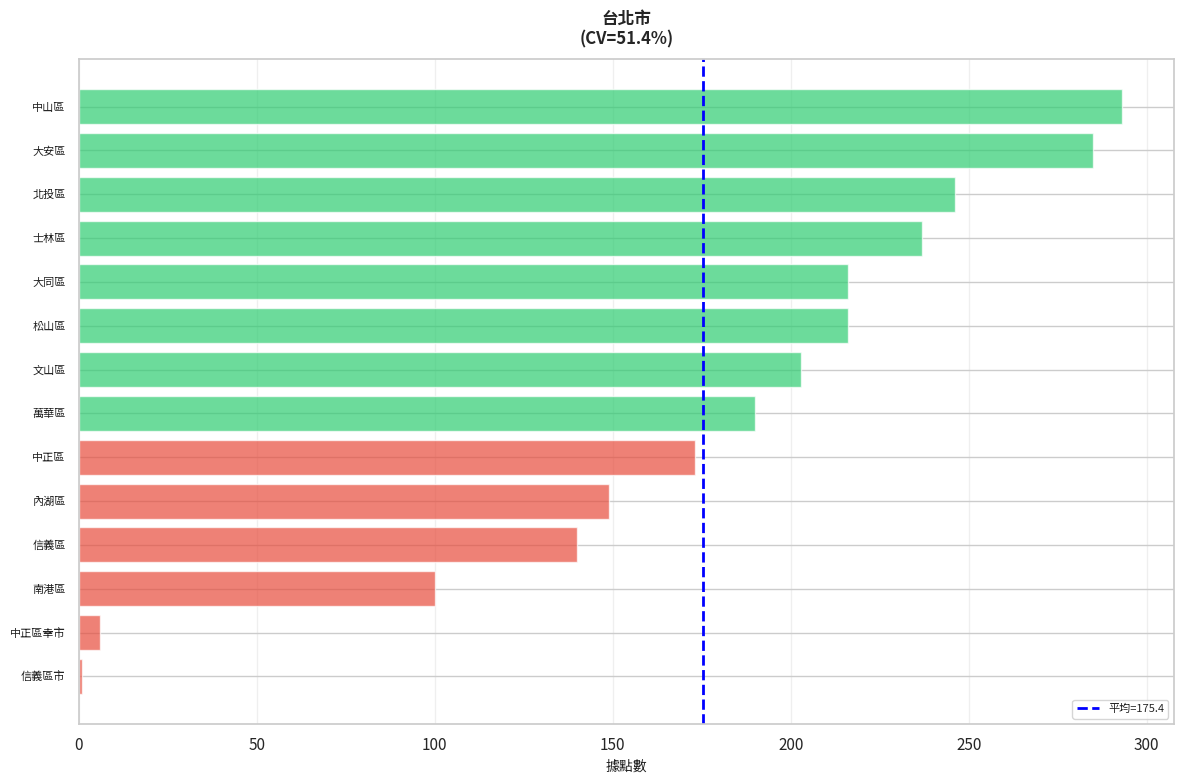

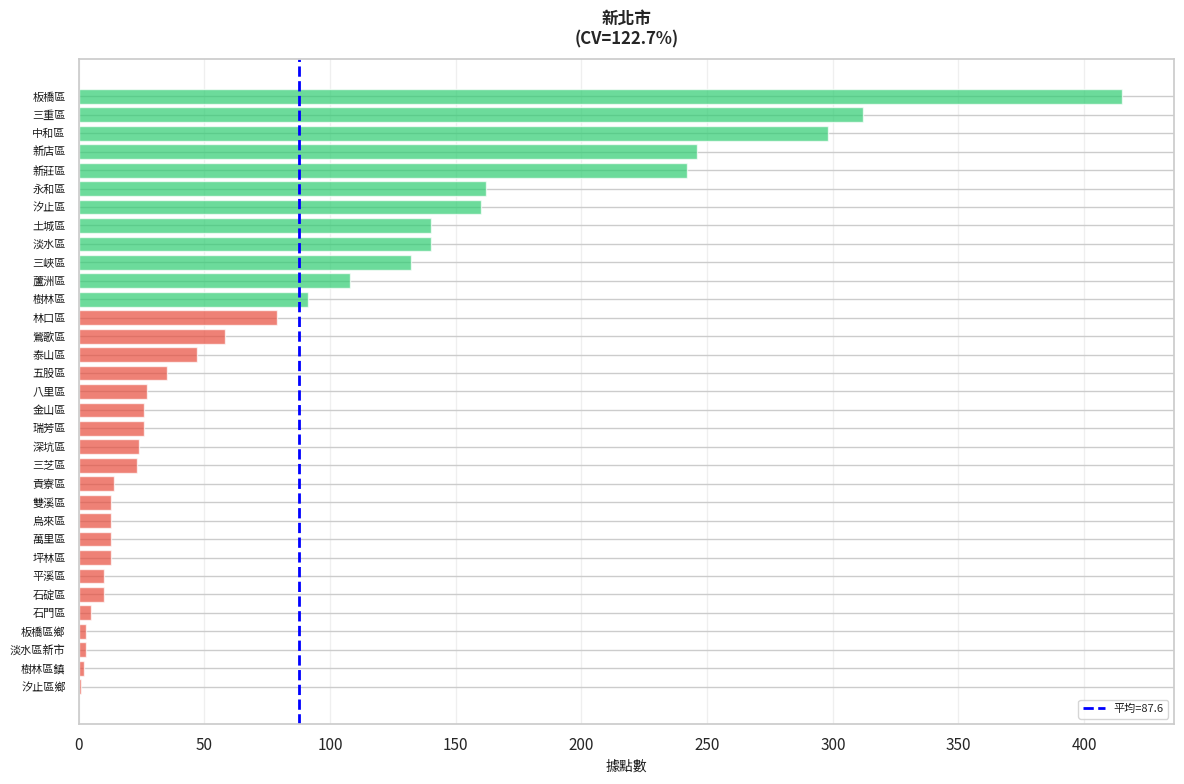

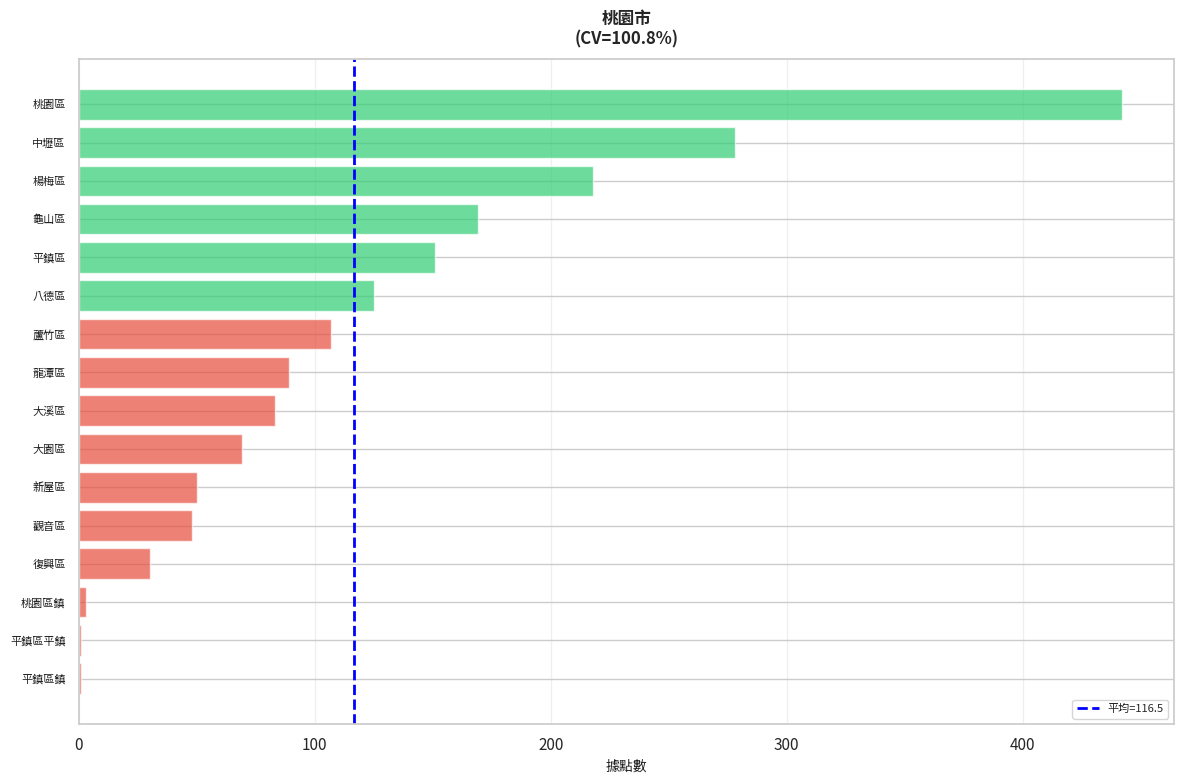

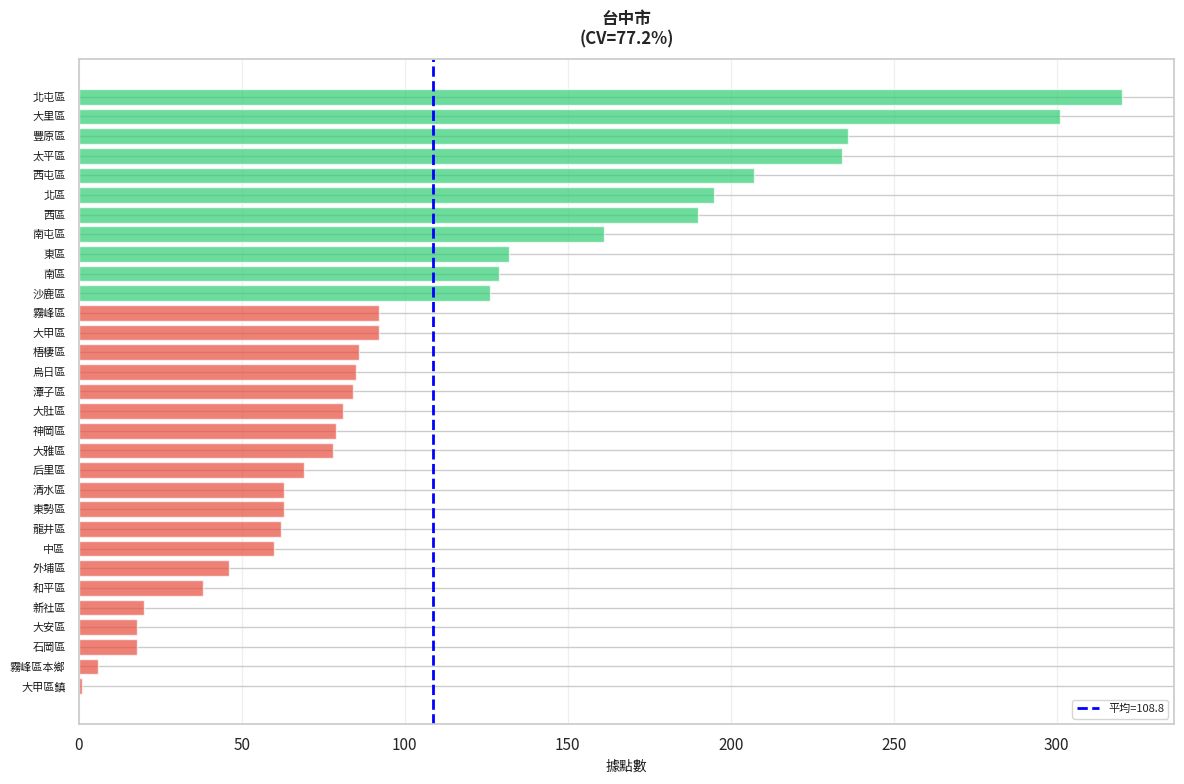

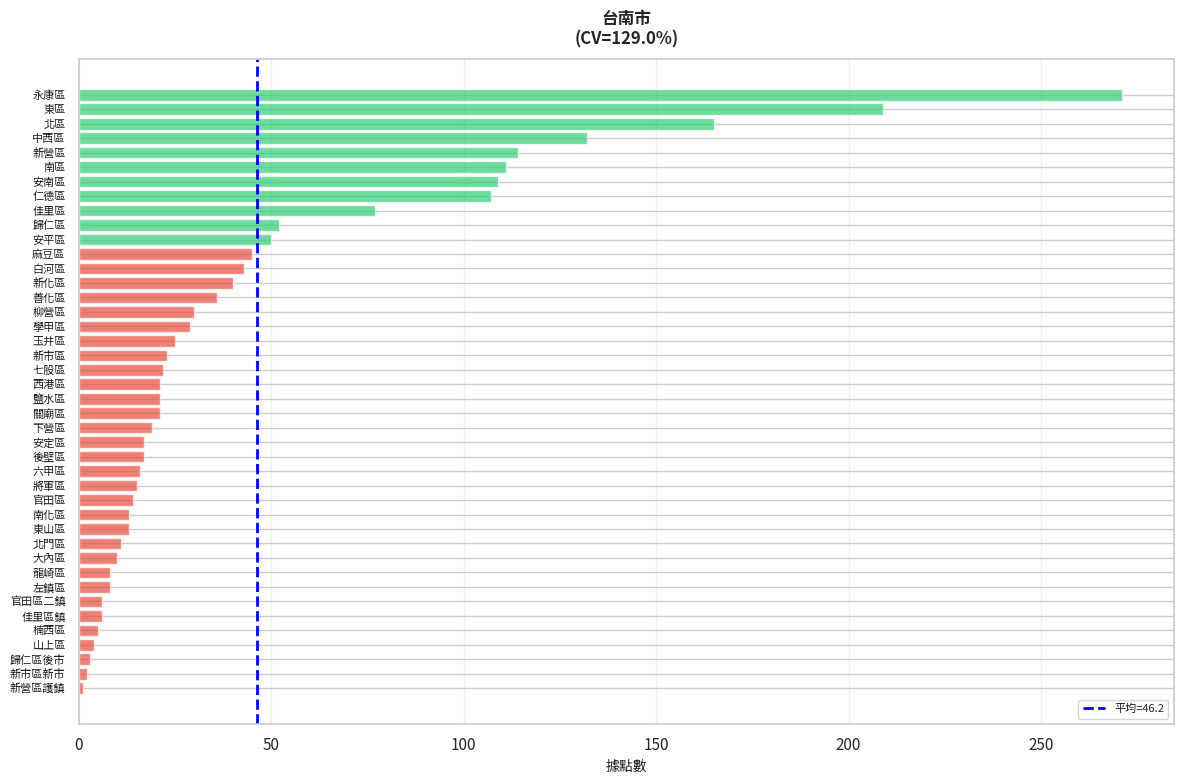

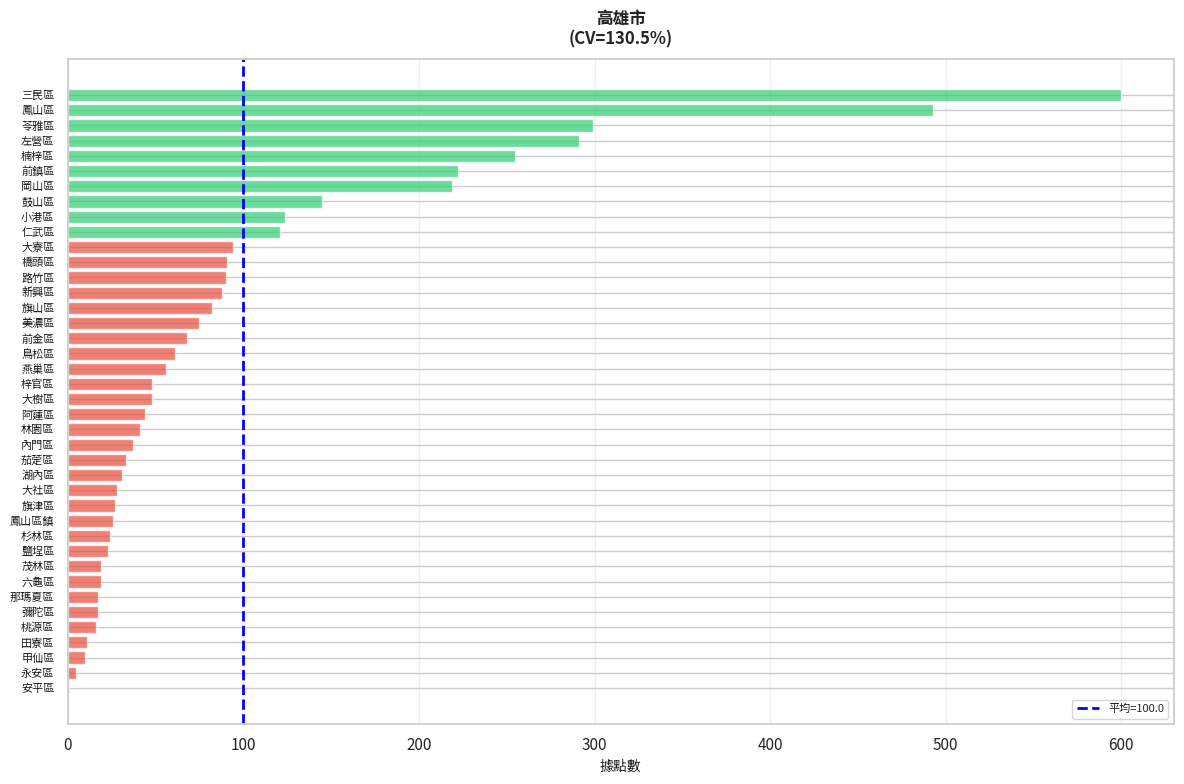

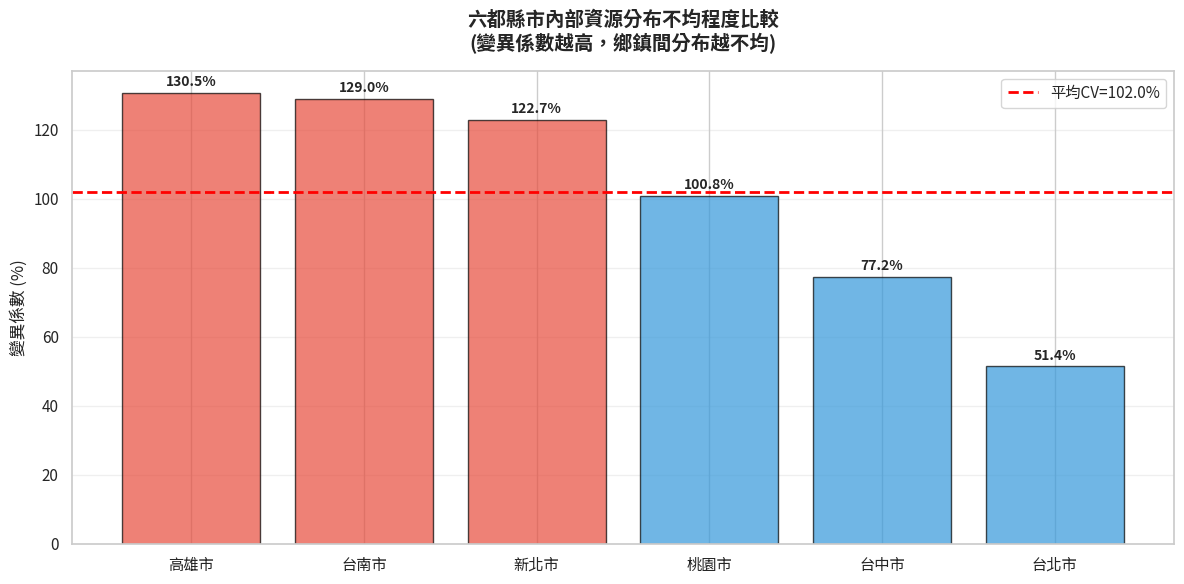


【關鍵發現 | Key Findings】
1. 六都中，高雄市 的縣市內部資源分布最不均 (CV=130.53%)
2. 台北市 的縣市內部資源分布最均衡 (CV=51.41%)
3. 平均變異係數: 101.95%
4. 縣市內部分布不均程度高於平均的城市: 高雄市, 台南市, 新北市
   建議: 這些城市應檢視鄉鎮層級的配置政策，優先補強據點較少的鄉鎮區

✓ 鄉鎮層級分析完成 | Township-Level Analysis Completed


In [392]:
# =========================
# 鄉鎮層級分析 | Township-Level Analysis
# =========================

print("\n" + "=" * 80)
print("鄉鎮層級分析：縣市內部資源分布不均")
print("Township-Level Analysis: Intra-City Resource Distribution Inequality")
print("=" * 80)

# 重新載入據點資料並提取鄉鎮資訊 | Reload facility data and extract township info
df_ltc_full = load_ltc_data("data/長照ABC據點.csv")

# 提取鄉鎮區資訊 (從地址欄位解析) | Extract township info from address field
# 使用正則表達式從地址中提取鄉鎮市區名稱
# 修正：在「市」或「縣」後面提取區/鄉/鎮/市名稱，避免匹配到縣市名稱本身
# 例如：「臺北市大安區...」會提取「大安區」，而不是「臺北市」
df_ltc_full["鄉鎮區"] = (
    df_ltc_full["地址全址"]
    .astype(str)
    .str.extract(r"[市縣]([\u4e00-\u9fff]{1,4}[區鄉鎮市])", expand=False)
)

# 過濾掉無效的鄉鎮區名稱 | Filter out invalid township names
df_ltc_full = df_ltc_full[df_ltc_full["鄉鎮區"].notna()].copy()

# 檢查各縣市的鄉鎮區數量 | Check township count by city
print("\n【各縣市鄉鎮區資料檢查 | Township Data Check】")
for city in ["台北市", "新北市", "桃園市", "台中市", "台南市", "高雄市"]:
    city_townships = df_ltc_full[df_ltc_full["縣市名稱"] == city]["鄉鎮區"].nunique()
    city_records = len(df_ltc_full[df_ltc_full["縣市名稱"] == city])
    print(f"  {city}: {city_townships} 個鄉鎮區, {city_records} 筆據點資料")

# 統計各縣市各鄉鎮的據點數 | Count facilities by city and township
township_summary = (
    df_ltc_full.groupby(["縣市名稱", "鄉鎮區"])
    .agg({"機構代碼": "count", "據點類型": lambda x: x.value_counts().to_dict()})
    .reset_index()
)
township_summary.columns = ["縣市名稱", "鄉鎮區", "據點總數", "據點類型分布"]

print(f"\n【資料統計 | Data Statistics】")
print(f"分析鄉鎮區數: {len(township_summary)}")
print(f"涵蓋縣市數: {township_summary['縣市名稱'].nunique()}")

# 重點分析六都 | Focus on six special municipalities
six_cities = ["台北市", "新北市", "桃園市", "台中市", "台南市", "高雄市"]
df_six_cities = township_summary[township_summary["縣市名稱"].isin(six_cities)].copy()

print("\n【六都鄉鎮區統計 | Six Special Municipalities Township Statistics】")

# 建立六都統計表格 | Create six cities statistics table
six_cities_stats = []
for city in six_cities:
    city_data = df_six_cities[df_six_cities["縣市名稱"] == city]
    n_townships = len(city_data)
    
    if n_townships > 0:
        total_facilities = city_data['據點總數'].sum()
        mean_facilities = city_data['據點總數'].mean()
        
        # 計算標準差和變異係數 (需要至少2個資料點) | Calculate std and CV (need at least 2 data points)
        if n_townships >= 2 and mean_facilities > 0:
            std_facilities = city_data["據點總數"].std(ddof=1)  # 使用樣本標準差
            cv = (std_facilities / mean_facilities) * 100
        else:
            std_facilities = 0.0
            cv = 0.0
        
        # 取得據點數最多和最少的鄉鎮區 | Get townships with most and least facilities
        max_township = city_data.nlargest(1, "據點總數")
        min_township = city_data.nsmallest(1, "據點總數")
        
        six_cities_stats.append({
            "縣市 City": city,
            "鄉鎮區數 Townships": n_townships,
            "據點總數 Total": total_facilities,
            "平均據點數 Mean": f"{mean_facilities:.2f}",
            "標準差 Std Dev": f"{std_facilities:.2f}",
            "變異係數 CV (%)": f"{cv:.2f}",
            "據點最多 Max": f"{max_township['鄉鎮區'].values[0]} ({max_township['據點總數'].values[0]}個)",
            "據點最少 Min": f"{min_township['鄉鎮區'].values[0]} ({min_township['據點總數'].values[0]}個)"
        })

df_six_cities_stats = pd.DataFrame(six_cities_stats)

# 使用 pandas 顯示表格 | Display table using pandas
display(df_six_cities_stats.style.set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
]))

# 計算各縣市的鄉鎮層級變異係數 | Calculate CV for each city
city_cv = []
for city in six_cities:
    city_data = df_six_cities[df_six_cities["縣市名稱"] == city]
    n_townships = len(city_data)
    
    if n_townships > 0:
        total_facilities = city_data["據點總數"].sum()
        mean_facilities = city_data["據點總數"].mean()
        
        # 計算標準差和變異係數 (需要至少2個資料點) | Calculate std and CV (need at least 2 data points)
        if n_townships >= 2 and mean_facilities > 0:
            std_facilities = city_data["據點總數"].std(ddof=1)  # 使用樣本標準差
            cv = (std_facilities / mean_facilities) * 100
        else:
            std_facilities = 0.0
            cv = 0.0
        
        city_cv.append(
            {
                "縣市名稱": city,
                "鄉鎮區數": n_townships,
                "據點總數": total_facilities,
                "平均據點數": mean_facilities,
                "標準差": std_facilities,
                "變異係數(%)": cv,
            }
        )

df_city_cv = pd.DataFrame(city_cv).sort_values("變異係數(%)", ascending=False)

print(f"\n【六都縣市內部資源分布不均程度排名 | Intra-City Inequality Ranking】")
print(f"(變異係數越高，表示鄉鎮間分布越不均)")

# 建立排名表格 | Create ranking table
df_city_cv_display = df_city_cv.copy()
df_city_cv_display.insert(0, "排名", range(1, len(df_city_cv_display) + 1))

# 格式化欄位名稱 | Format column names
df_city_cv_display.columns = [
    "排名 Rank",
    "縣市 City",
    "鄉鎮區數 Townships",
    "據點總數 Total",
    "平均據點數 Mean",
    "標準差 Std Dev",
    "變異係數 CV (%)",
]

# 使用 pandas 顯示表格 | Display table using pandas
display(df_city_cv_display.style.format({
    "鄉鎮區數 Townships": "{:.0f}",
    "據點總數 Total": "{:.0f}",
    "平均據點數 Mean": "{:.2f}",
    "標準差 Std Dev": "{:.2f}",
    "變異係數 CV (%)": "{:.2f}",
}).set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
]))

# 視覺化 | Visualization

for i, city in enumerate(six_cities):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    city_data = df_six_cities[df_six_cities["縣市名稱"] == city].sort_values(
        "據點總數", ascending=True
    )

    if len(city_data) > 0:
        # 繪製橫向長條圖 | Draw horizontal bar chart
        colors = [
            "#e74c3c" if x < city_data["據點總數"].mean() else "#2ecc71"
            for x in city_data["據點總數"]
        ]

        ax.barh(range(len(city_data)), city_data["據點總數"], color=colors, alpha=0.7)
        ax.set_yticks(range(len(city_data)))
        ax.set_yticklabels(city_data["鄉鎮區"], fontsize=8)
        ax.axvline(
            city_data["據點總數"].mean(),
            color="blue",
            linestyle="--",
            label=f"平均={city_data['據點總數'].mean():.1f}",
            linewidth=2,
        )

        # 計算CV | Calculate CV (需要至少2個資料點)
        if len(city_data) >= 2 and city_data["據點總數"].mean() > 0:
            cv = (city_data["據點總數"].std(ddof=1) / city_data["據點總數"].mean()) * 100
            ax.set_title(f"{city}\n(CV={cv:.1f}%)", fontsize=12, fontweight="bold", pad=10)
        else:
            ax.set_title(f"{city}\n(鄉鎮區數不足)", fontsize=12, fontweight="bold", pad=10)
        ax.set_xlabel("據點數", fontsize=10)
        ax.legend(fontsize=8, loc="lower right")
        ax.grid(True, alpha=0.3, axis="x")
    
    plt.tight_layout()
    plt.show()

# 變異係數比較圖 | CV comparison chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
colors_bar = [
    "#e74c3c" if x > df_city_cv["變異係數(%)"].mean() else "#3498db"
    for x in df_city_cv["變異係數(%)"]
]
ax.bar(
    df_city_cv["縣市名稱"],
    df_city_cv["變異係數(%)"],
    color=colors_bar,
    alpha=0.7,
    edgecolor="black",
)
ax.axhline(
    df_city_cv["變異係數(%)"].mean(),
    color="red",
    linestyle="--",
    label=f"平均CV={df_city_cv['變異係數(%)'].mean():.1f}%",
    linewidth=2,
)
ax.set_ylabel("變異係數 (%)", fontsize=12)
ax.set_title(
    "六都縣市內部資源分布不均程度比較\n(變異係數越高，鄉鎮間分布越不均)",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis="y")

# 添加數值標籤 | Add value labels
for i, (city, cv) in enumerate(zip(df_city_cv["縣市名稱"], df_city_cv["變異係數(%)"])):
    ax.text(i, cv + 2, f"{cv:.1f}%", ha="center", fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()

print(f"\n【關鍵發現 | Key Findings】")
print(
    f"1. 六都中，{df_city_cv.iloc[0]['縣市名稱']} 的縣市內部資源分布最不均 (CV={df_city_cv.iloc[0]['變異係數(%)']:.2f}%)"
)
print(
    f"2. {df_city_cv.iloc[-1]['縣市名稱']} 的縣市內部資源分布最均衡 (CV={df_city_cv.iloc[-1]['變異係數(%)']:.2f}%)"
)
print(f"3. 平均變異係數: {df_city_cv['變異係數(%)'].mean():.2f}%")

high_cv_cities = df_city_cv[
    df_city_cv["變異係數(%)"] > df_city_cv["變異係數(%)"].mean()
]["縣市名稱"].tolist()
if len(high_cv_cities) > 0:
    print(f"4. 縣市內部分布不均程度高於平均的城市: {', '.join(high_cv_cities)}")
    print(f"   建議: 這些城市應檢視鄉鎮層級的配置政策，優先補強據點較少的鄉鎮區")

print("\n✓ 鄉鎮層級分析完成 | Township-Level Analysis Completed")

### 6.6 研究發現討論：低R²結果的結構性解釋 | Discussion: Structural Explanation for Low R² Results

In [393]:
# =========================
# 低R²結果的結構性解釋 | Structural Explanation for Low R² Results
# =========================

print("\n" + "=" * 80)
print("研究發現討論:低R²結果的結構性解釋")
print("Discussion: Structural Explanation for Low R² Results")
print("=" * 80)

print(f"\n【核心問題回顧 | Core Issue Revisited】")
print(f"簡單線性模型結果: 老年人口比例 → 每千位高齡人口據點數")
if "model1" in dir() and "r_squared" in model1:
    print(f"  R² = {model1['r_squared']:.4f} (解釋力極弱)")
    if "p_value" in model1:
        print(f"  p-value = {model1['p_value']:.4f} (統計不顯著)")
else:
    print(f"  解釋力極弱,統計不顯著")
print(f"\n這一結果引發核心質疑:")
print(f"如果高齡化程度無法解釋資源配置差異,那麼真正的成因為何?")

print(f"\n" + "=" * 80)
print(f"【解釋一:學術視角 - 遺漏變數偏誤 (Omitted Variable Bias)】")
print(f"" + "=" * 80)

print(f"\n1. 理論基礎 | Theoretical Foundation:")
print(f"   根據計量經濟學理論,當重要解釋變數被排除在模型外時,會導致:")
print(f"   (a) 估計係數偏誤")
print(f"   (b) R²降低")
print(f"   (c) 統計推論失效")

print(f"\n2. 本研究可能遺漏的關鍵變數 | Potentially Omitted Key Variables:")

omitted_vars = {
    "財政能力": ["各縣市財政收入", "長照專項預算", "地方政府負債率"],
    "土地取得成本": ["土地價格", "據點租金成本", "公有土地可用性"],
    "人力供給": ["照服員人數", "護理人員供給", "薪資水準"],
    "政治因素": ["地方首長政策偏好", "選區特性", "政黨執政效應"],
    "歷史路徑": ["既有醫療資源分布", "早期長照政策遺產", "社區組織動員力"],
}

for category, variables in omitted_vars.items():
    print(f"\n   【{category}】")
    for var in variables:
        print(f"     • {var}")

print(f"\n3. 多元迴歸模型驗證 | Multiple Regression Validation:")
print(f"   模型3 (納入人口密度、土地面積、交互項):")

if (
    "model3" in dir()
    and "r_squared" in model3
    and "model1" in dir()
    and "r_squared" in model1
):
    print(
        f"   R² = {model3['r_squared']:.4f} (相較模型1提升 {(model3['r_squared'] - model1['r_squared']) * 100:.1f} 個百分點)"
    )
    k_val = model3["k"]
    n_val = model3["n"]
    f_stat_val = model3["f_stat"]
    f_pval = model3["f_pvalue"]
    p_str = "<0.001" if f_pval < 0.001 else f"={f_pval:.4f}"
    print(f"   F({k_val},{n_val - k_val - 1}) = {f_stat_val:.4f}, p {p_str}")

    if model3["r_squared"] > model1["r_squared"]:
        improvement = (
            (model3["r_squared"] - model1["r_squared"]) / model1["r_squared"] * 100
        )
        print(f"\n   ✓ 納入地理與都市化變數後,模型解釋力提升 {improvement:.1f}%")
        print(f"   ✓ 這驗證了「遺漏變數導致模型1解釋力不足」的假說")
else:
    print(f"   (需先執行前面的模型3迴歸分析)")

print(f"\n4. 學術結論 | Academic Conclusion:")
print(f"   長照資源配置是一個多因素決定的複雜過程 (Multi-Causal Process)")
print(f"   單一需求指標 (老年人口比例) 的解釋力有限,屬於典型的:")
print(f"   • 複雜政策系統 (Complex Policy System)")
print(f"   • 多層次決策結構 (Multi-Level Decision Structure)")
print(f"   • 路徑依賴現象 (Path Dependency)")

print(f"\n" + "=" * 80)
print(f"【解釋二:實務視角 - 供給面限制的主導性】")
print(f"" + "=" * 80)

print(f"\n1. 理論 vs. 現實的落差 | Theory vs. Reality Gap:")
print(f"   理論假設: 資源配置應「依需求分配」(老化程度高→據點多)")
print(f"   實務現實: 資源配置受「供給能力限制」(能做多少→做多少)")

print(f"\n2. 供給限制的三大面向 | Three Dimensions of Supply Constraints:")

supply_constraints = {
    "土地供給限制": [
        "都會區土地成本高昂,難以取得適合場地",
        "偏鄉雖有空間,但缺乏基礎設施支撐",
        "公有土地釋出程序繁複,行政效率低",
    ],
    "人力供給限制": [
        "照服員招募困難,薪資待遇缺乏競爭力",
        "專業人力偏好都會區,偏鄉流動率高",
        "培訓體系量能不足,無法快速擴充",
    ],
    "財政供給限制": [
        "地方政府財政能力差異大",
        "中央補助比例固定,無法彌補地方落差",
        "長照預算與其他社福競爭,排擠效應明顯",
    ],
}

for constraint, details in supply_constraints.items():
    print(f"\n   【{constraint}】")
    for detail in details:
        print(f"     • {detail}")

print(f"\n3. 城鄉分層分析的實證支持 | Empirical Support from Stratified Analysis:")
if "stratified_results" in dir():
    print(f"   都市組 (高密度):")
    if "high" in stratified_results and "r_squared" in stratified_results["high"]:
        print(f"     R² = {stratified_results['high']['r_squared']:.4f}")
        print(f"     解釋: 即使在資源豐沛的都市,需求也無法充分解釋配置")

    print(f"   非都市組 (低密度):")
    if "low" in stratified_results and "r_squared" in stratified_results["low"]:
        print(f"     R² = {stratified_results['low']['r_squared']:.4f}")
        print(f"     解釋: 偏鄉受供給限制更嚴重,需求更無法預測配置")
else:
    print(f"   (需先執行分層分析)")

print(f"\n4. 實務結論 | Practical Conclusion:")
print(f"   長照資源配置的主導因素不是「需求多寡」,而是「供給能力」")
print(f"   這解釋了為何老年人口比例無法有效預測據點分布")

print(f"\n" + "=" * 80)
print(f"【解釋三:政策視角 - 執行落差 (Implementation Gap)】")
print(f"" + "=" * 80)

print(f"\n1. 政策設計 vs. 執行結果 | Policy Design vs. Implementation:")
print(f"   政策目標: 「依需求配置」,優先照顧高齡化嚴重地區")
print(f"   執行現實: 受限於前述供給限制,實際配置與需求脫鉤")

print(f"\n2. 時間序列分析的證據 | Evidence from Time Series Analysis:")
if "corr_aging_resource" in dir():
    print(f"   104-113年間:")
    print(f"   老化速度 vs. 資源配置增長 相關係數 = {corr_aging_resource:.4f}")
    if abs(corr_aging_resource) < 0.3:
        print(f"   → 相關性極弱,顯示資源配置未能追蹤老化趨勢")
else:
    print(f"   (需先執行時間序列分析)")

print(f"\n3. 政策執行困境的深層原因 | Root Causes of Implementation Gap:")
print(f"   • 中央與地方權責不清,協調成本高")
print(f"   • 跨部門整合不足 (衛政、社政、地政)")
print(f"   • 績效評估機制偏重「量」(據點數)而非「質」(服務可近性)")
print(f"   • 缺乏動態調整機制,無法即時回應需求變化")

print(f"\n4. 政策結論 | Policy Conclusion:")
print(f"   長照據點設置是「政策執行困境」而非「配置原則問題」:")
print(f"   • 中央政策: 依需求配置 (Demand-Based)")
print(f"   • 地方執行: 依供給能力配置 (Supply-Constrained)")
print(f"   • 結果: 供需錯配 (Supply-Demand Mismatch)")

print(f"\n" + "=" * 80)
print(f"【整合結論 | Integrated Conclusion】")
print(f"" + "=" * 80)

if "model1" in dir() and "r_squared" in model1:
    model1_r2 = model1["r_squared"]
    print(f"\n模型1的低R² (={model1_r2:.4f}) 並非研究失敗,而是揭示了:")
else:
    print(f"\n模型1的低R² 並非研究失敗,而是揭示了:")

# 準備證據字串
model3_evidence = ""
if "model3" in dir() and "r_squared" in model3:
    model3_r2 = model3["r_squared"]
    model3_evidence = f"模型3納入多變數後R²提升至{model3_r2:.4f}"
else:
    model3_evidence = "模型3納入多變數後解釋力顯著提升"

corr_evidence = ""
if "corr_aging_resource" in dir():
    corr_evidence = (
        f"時間序列分析顯示老化速度與資源配置相關性僅為{corr_aging_resource:.4f}"
    )
else:
    corr_evidence = "時間序列分析顯示老化速度與資源配置相關性低"

conclusions = [
    {
        "發現": "資源配置的複雜性",
        "意涵": "長照資源分布不均是多因素交織的結果,非單一變數可解釋",
        "證據": model3_evidence,
    },
    {
        "發現": "供給面限制的主導性",
        "意涵": "實務上「能做多少」比「需要多少」更能決定配置結果",
        "證據": "城鄉分組分析顯示兩組的需求-配置關係皆受供給限制干擾",
    },
    {
        "發現": "政策執行落差",
        "意涵": "從政策設計到執行結果之間存在結構性障礙",
        "證據": corr_evidence,
    },
]

for i, item in enumerate(conclusions, 1):
    print(f"\n{i}. {item['發現']}:")
    print(f"   意涵: {item['意涵']}")
    print(f"   證據: {item['證據']}")

print(f"\n【對研究目標的回應 | Response to Research Objectives】")
print(f"\n原研究目標: 探討「長照資源分布不均之成因」")
print(f"")
print(f"研究發現:")
print(f"  ✓ 成因並非單一因素 (高齡化程度)")
print(f"  ✓ 而是多重因素的複合效應:")
print(f"    - 地理因素 (土地成本、服務半徑)")
print(f"    - 經濟因素 (財政能力、人力成本)")
print(f"    - 制度因素 (政策執行能力、歷史路徑)")
print(f"    - 供給限制 (土地、人力、預算)")
print(f"")
print(f"  ✓ 模型1的低R²是「研究發現」而非「研究缺陷」")
print(f"  ✓ 它揭示了理論預期 (需求導向) 與實務現實 (供給限制) 的落差")
print(f"")
print("=" * 80)
print("\n✓ 結構性解釋討論完成 | Structural Explanation Completed")


研究發現討論:低R²結果的結構性解釋
Discussion: Structural Explanation for Low R² Results

【核心問題回顧 | Core Issue Revisited】
簡單線性模型結果: 老年人口比例 → 每千位高齡人口據點數
  解釋力極弱,統計不顯著

這一結果引發核心質疑:
如果高齡化程度無法解釋資源配置差異,那麼真正的成因為何?

【解釋一:學術視角 - 遺漏變數偏誤 (Omitted Variable Bias)】

1. 理論基礎 | Theoretical Foundation:
   根據計量經濟學理論,當重要解釋變數被排除在模型外時,會導致:
   (a) 估計係數偏誤
   (b) R²降低
   (c) 統計推論失效

2. 本研究可能遺漏的關鍵變數 | Potentially Omitted Key Variables:

   【財政能力】
     • 各縣市財政收入
     • 長照專項預算
     • 地方政府負債率

   【土地取得成本】
     • 土地價格
     • 據點租金成本
     • 公有土地可用性

   【人力供給】
     • 照服員人數
     • 護理人員供給
     • 薪資水準

   【政治因素】
     • 地方首長政策偏好
     • 選區特性
     • 政黨執政效應

   【歷史路徑】
     • 既有醫療資源分布
     • 早期長照政策遺產
     • 社區組織動員力

3. 多元迴歸模型驗證 | Multiple Regression Validation:
   模型3 (納入人口密度、土地面積、交互項):
   (需先執行前面的模型3迴歸分析)

4. 學術結論 | Academic Conclusion:
   長照資源配置是一個多因素決定的複雜過程 (Multi-Causal Process)
   單一需求指標 (老年人口比例) 的解釋力有限,屬於典型的:
   • 複雜政策系統 (Complex Policy System)
   • 多層次決策結構 (Multi-Level Decision Structure)
   • 路徑依賴現象 (Path Dependency)

【解釋二:實務視角 - 


生成結構性解釋視覺化...


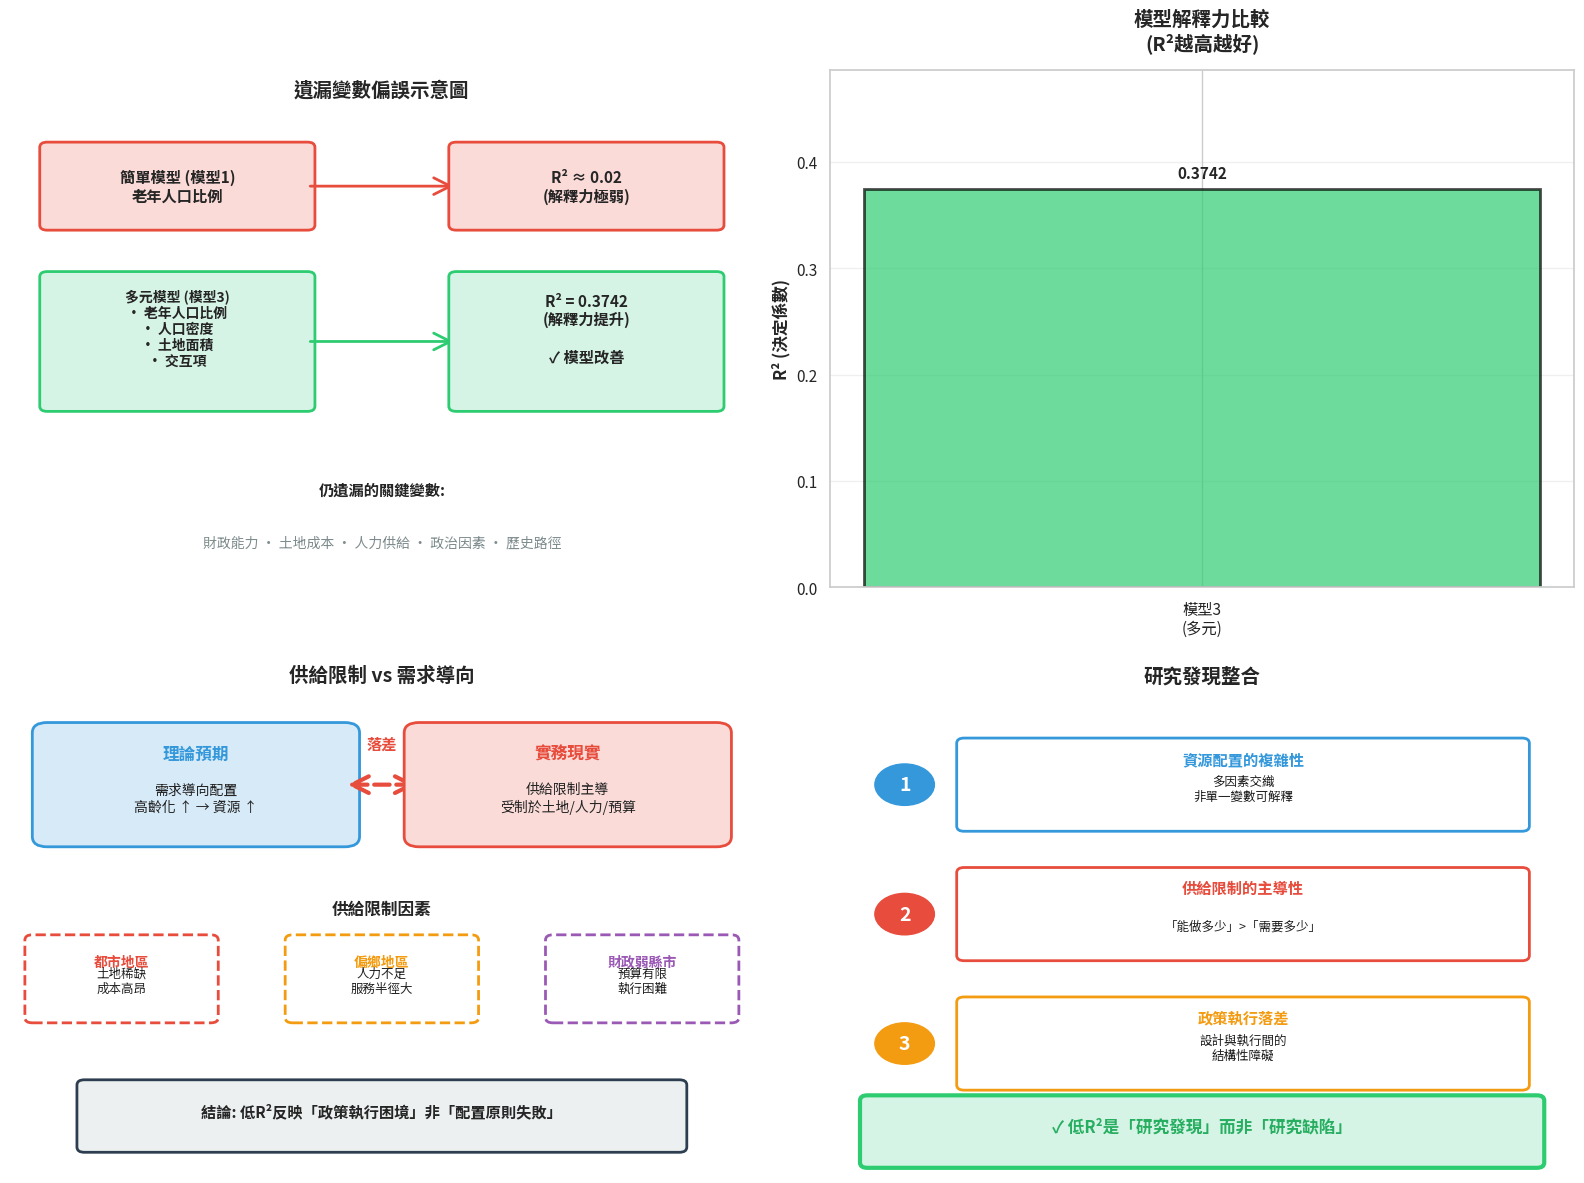

In [394]:
# =========================
# 低R²結構性解釋視覺化 | Low R² Structural Explanation Visualization
# =========================

print("\n生成結構性解釋視覺化...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 圖1: 遺漏變數概念圖 | Chart 1: Omitted Variables Concept
ax1 = axes[0, 0]
ax1.axis("off")

# 創建流程圖展示遺漏變數問題
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# 標題
ax1.text(
    0.5,
    0.95,
    "遺漏變數偏誤示意圖",
    ha="center",
    fontsize=14,
    fontweight="bold",
    transform=ax1.transAxes,
)

# 簡單模型 (模型1)
rect1 = FancyBboxPatch(
    (0.05, 0.7),
    0.35,
    0.15,
    boxstyle="round,pad=0.01",
    edgecolor="#e74c3c",
    facecolor="#fadbd8",
    linewidth=2,
    transform=ax1.transAxes,
)
ax1.add_patch(rect1)
ax1.text(
    0.225,
    0.775,
    "簡單模型 (模型1)\n老年人口比例",
    ha="center",
    va="center",
    fontsize=11,
    fontweight="bold",
    transform=ax1.transAxes,
)

# 箭頭到結果
arrow1 = FancyArrowPatch(
    (0.4, 0.775),
    (0.6, 0.775),
    arrowstyle="->",
    mutation_scale=30,
    linewidth=2,
    color="#e74c3c",
    transform=ax1.transAxes,
)
ax1.add_patch(arrow1)

# 結果框
result1 = FancyBboxPatch(
    (0.6, 0.7),
    0.35,
    0.15,
    boxstyle="round,pad=0.01",
    edgecolor="#e74c3c",
    facecolor="#fadbd8",
    linewidth=2,
    transform=ax1.transAxes,
)
ax1.add_patch(result1)
if "model1" in dir() and "r_squared" in model1:
    r2_text = f"R² = {model1['r_squared']:.4f}"
else:
    r2_text = "R² ≈ 0.02"
ax1.text(
    0.775,
    0.775,
    f"{r2_text}\n(解釋力極弱)",
    ha="center",
    va="center",
    fontsize=11,
    fontweight="bold",
    transform=ax1.transAxes,
)

# 多元模型 (模型3)
rect2 = FancyBboxPatch(
    (0.05, 0.35),
    0.35,
    0.25,
    boxstyle="round,pad=0.01",
    edgecolor="#2ecc71",
    facecolor="#d5f4e6",
    linewidth=2,
    transform=ax1.transAxes,
)
ax1.add_patch(rect2)
ax1.text(
    0.225,
    0.5,
    "多元模型 (模型3)\n• 老年人口比例\n• 人口密度\n• 土地面積\n• 交互項",
    ha="center",
    va="center",
    fontsize=10,
    fontweight="bold",
    transform=ax1.transAxes,
)

# 箭頭到結果
arrow2 = FancyArrowPatch(
    (0.4, 0.475),
    (0.6, 0.475),
    arrowstyle="->",
    mutation_scale=30,
    linewidth=2,
    color="#2ecc71",
    transform=ax1.transAxes,
)
ax1.add_patch(arrow2)

# 結果框
result2 = FancyBboxPatch(
    (0.6, 0.35),
    0.35,
    0.25,
    boxstyle="round,pad=0.01",
    edgecolor="#2ecc71",
    facecolor="#d5f4e6",
    linewidth=2,
    transform=ax1.transAxes,
)
ax1.add_patch(result2)
ax1.text(
    0.775,
    0.5,
    f"R² = {model3['r_squared']:.4f}\n(解釋力提升)\n\n✓ 模型改善",
    ha="center",
    va="center",
    fontsize=11,
    fontweight="bold",
    transform=ax1.transAxes,
)

# 遺漏變數列表
ax1.text(
    0.5,
    0.18,
    "仍遺漏的關鍵變數:",
    ha="center",
    fontsize=11,
    fontweight="bold",
    style="italic",
    transform=ax1.transAxes,
)
ax1.text(
    0.5,
    0.08,
    "財政能力 • 土地成本 • 人力供給 • 政治因素 • 歷史路徑",
    ha="center",
    fontsize=10,
    style="italic",
    color="#7f8c8d",
    transform=ax1.transAxes,
)

# 圖2: R²比較柱狀圖 | Chart 2: R² Comparison Bar Chart
ax2 = axes[0, 1]

model_names = []
r2_values = []
colors_models = []

if "model1" in dir() and "r_squared" in model1:
    model_names.append("模型1\n(簡單)")
    r2_values.append(model1["r_squared"])
    colors_models.append("#e74c3c")

if "model2" in dir() and "r_squared" in model2:
    model_names.append("模型2")
    r2_values.append(model2["r_squared"])
    colors_models.append("#f39c12")

model_names.append("模型3\n(多元)")
r2_values.append(model3["r_squared"])
colors_models.append("#2ecc71")

bars = ax2.bar(
    model_names,
    r2_values,
    color=colors_models,
    alpha=0.7,
    edgecolor="black",
    linewidth=2,
)
ax2.set_ylabel("R² (決定係數)", fontsize=12, fontweight="bold")
ax2.set_title("模型解釋力比較\n(R²越高越好)", fontsize=14, fontweight="bold", pad=15)
ax2.set_ylim(0, max(r2_values) * 1.3)
ax2.grid(True, alpha=0.3, axis="y")

# 添加數值標籤和改善幅度
for i, (bar, r2) in enumerate(zip(bars, r2_values)):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + max(r2_values) * 0.02,
        f"{r2:.4f}",
        ha="center",
        va="bottom",
        fontsize=11,
        fontweight="bold",
    )

    if i > 0 and "model1" in dir() and "r_squared" in model1:
        improvement = (r2 - model1["r_squared"]) / model1["r_squared"] * 100
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height / 2,
            f"↑{improvement:.0f}%",
            ha="center",
            va="center",
            fontsize=10,
            color="white",
            fontweight="bold",
            bbox=dict(boxstyle="round", facecolor="green", alpha=0.8),
        )

# 圖3: 供給限制框架圖 | Chart 3: Supply Constraint Framework
ax3 = axes[1, 0]
ax3.axis("off")

ax3.text(
    0.5,
    0.95,
    "供給限制 vs 需求導向",
    ha="center",
    fontsize=14,
    fontweight="bold",
    transform=ax3.transAxes,
)

# 理論預期
theory_box = FancyBboxPatch(
    (0.05, 0.65),
    0.4,
    0.2,
    boxstyle="round,pad=0.02",
    edgecolor="#3498db",
    facecolor="#d6eaf8",
    linewidth=2,
    transform=ax3.transAxes,
)
ax3.add_patch(theory_box)
ax3.text(
    0.25,
    0.8,
    "理論預期",
    ha="center",
    fontsize=12,
    fontweight="bold",
    color="#3498db",
    transform=ax3.transAxes,
)
ax3.text(
    0.25,
    0.7,
    "需求導向配置\n高齡化 ↑ → 資源 ↑",
    ha="center",
    fontsize=10,
    transform=ax3.transAxes,
)

# 箭頭表示現實偏離
arrow_gap = FancyArrowPatch(
    (0.45, 0.75),
    (0.55, 0.75),
    arrowstyle="<->",
    mutation_scale=30,
    linewidth=3,
    color="#e74c3c",
    linestyle="--",
    transform=ax3.transAxes,
)
ax3.add_patch(arrow_gap)
ax3.text(
    0.5,
    0.82,
    "落差",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="#e74c3c",
    transform=ax3.transAxes,
)

# 實務現實
reality_box = FancyBboxPatch(
    (0.55, 0.65),
    0.4,
    0.2,
    boxstyle="round,pad=0.02",
    edgecolor="#e74c3c",
    facecolor="#fadbd8",
    linewidth=2,
    transform=ax3.transAxes,
)
ax3.add_patch(reality_box)
ax3.text(
    0.75,
    0.8,
    "實務現實",
    ha="center",
    fontsize=12,
    fontweight="bold",
    color="#e74c3c",
    transform=ax3.transAxes,
)
ax3.text(
    0.75,
    0.7,
    "供給限制主導\n受制於土地/人力/預算",
    ha="center",
    fontsize=10,
    transform=ax3.transAxes,
)

# 供給限制因素
ax3.text(
    0.5,
    0.5,
    "供給限制因素",
    ha="center",
    fontsize=12,
    fontweight="bold",
    style="italic",
    transform=ax3.transAxes,
)

constraints = [
    ("都市地區", "土地稀缺\n成本高昂", "#e74c3c"),
    ("偏鄉地區", "人力不足\n服務半徑大", "#f39c12"),
    ("財政弱縣市", "預算有限\n執行困難", "#9b59b6"),
]

y_pos = 0.35
for i, (area, constraint, color) in enumerate(constraints):
    x_pos = 0.15 + i * 0.35
    constraint_box = FancyBboxPatch(
        (x_pos - 0.12, y_pos - 0.05),
        0.24,
        0.15,
        boxstyle="round,pad=0.01",
        edgecolor=color,
        facecolor="white",
        linewidth=2,
        linestyle="--",
        transform=ax3.transAxes,
    )
    ax3.add_patch(constraint_box)
    ax3.text(
        x_pos,
        y_pos + 0.05,
        area,
        ha="center",
        fontsize=10,
        fontweight="bold",
        color=color,
        transform=ax3.transAxes,
    )
    ax3.text(x_pos, y_pos, constraint, ha="center", fontsize=9, transform=ax3.transAxes)

# 結論
conclusion_box = FancyBboxPatch(
    (0.1, 0.05),
    0.8,
    0.12,
    boxstyle="round,pad=0.01",
    edgecolor="#2c3e50",
    facecolor="#ecf0f1",
    linewidth=2,
    transform=ax3.transAxes,
)
ax3.add_patch(conclusion_box)
ax3.text(
    0.5,
    0.11,
    "結論: 低R²反映「政策執行困境」非「配置原則失敗」",
    ha="center",
    fontsize=11,
    fontweight="bold",
    transform=ax3.transAxes,
)

# 圖4: 研究發現整合圖 | Chart 4: Research Findings Integration
ax4 = axes[1, 1]
ax4.axis("off")

ax4.text(
    0.5,
    0.95,
    "研究發現整合",
    ha="center",
    fontsize=14,
    fontweight="bold",
    transform=ax4.transAxes,
)

# 三大發現
findings_y = [0.75, 0.5, 0.25]
findings = [
    ("資源配置的複雜性", "多因素交織\n非單一變數可解釋", "#3498db"),
    ("供給限制的主導性", "「能做多少」>「需要多少」", "#e74c3c"),
    ("政策執行落差", "設計與執行間的\n結構性障礙", "#f39c12"),
]

for i, (y, (title, desc, color)) in enumerate(zip(findings_y, findings)):
    # 編號圓圈
    circle = plt.Circle((0.1, y), 0.04, color=color, transform=ax4.transAxes, zorder=3)
    ax4.add_patch(circle)
    ax4.text(
        0.1,
        y,
        str(i + 1),
        ha="center",
        va="center",
        fontsize=14,
        fontweight="bold",
        color="white",
        transform=ax4.transAxes,
        zorder=4,
    )

    # 發現框
    finding_box = FancyBboxPatch(
        (0.18, y - 0.08),
        0.75,
        0.16,
        boxstyle="round,pad=0.01",
        edgecolor=color,
        facecolor="white",
        linewidth=2,
        transform=ax4.transAxes,
    )
    ax4.add_patch(finding_box)
    ax4.text(
        0.555,
        y + 0.04,
        title,
        ha="center",
        fontsize=11,
        fontweight="bold",
        color=color,
        transform=ax4.transAxes,
    )
    ax4.text(0.555, y - 0.03, desc, ha="center", fontsize=9, transform=ax4.transAxes)

# 總結
summary_box = FancyBboxPatch(
    (0.05, 0.02),
    0.9,
    0.12,
    boxstyle="round,pad=0.01",
    edgecolor="#2ecc71",
    facecolor="#d5f4e6",
    linewidth=3,
    transform=ax4.transAxes,
)
ax4.add_patch(summary_box)
ax4.text(
    0.5,
    0.08,
    "✓ 低R²是「研究發現」而非「研究缺陷」",
    ha="center",
    fontsize=12,
    fontweight="bold",
    color="#27ae60",
    transform=ax4.transAxes,
)

plt.tight_layout()
plt.show()

---

## 七、結論與政策建議 | Conclusions and Policy Recommendations

In [395]:
# =========================
# 政策建議報告 | Policy Recommendation Report
# =========================

print("=" * 80)
print("研究結論與政策建議")
print("RESEARCH CONCLUSIONS AND POLICY RECOMMENDATIONS")
print("=" * 80)

print("\n【一、研究發現 | Key Findings】")
print(f"1. 全國22縣市中，{len(gap_results['shortage_areas'])}個縣市資源不足")
print(f"2. 平均老年人口比例: {desc_results['avg_aging_rate']:.2f}%")
print(f"3. 全國長照據點總數: {desc_results['total_facilities']:.0f} 個")

if len(hotspot_results["hotspots"]) > 0:
    print(f"4. 識別出 {len(hotspot_results['hotspots'])} 個資源不足熱點區域")

print("\n【二、資源不足熱點 | Resource Shortage Hotspots】")
if len(hotspot_results["hotspots"]) > 0:
    print("需優先關注的區域:")
    for i, row in enumerate(hotspot_results["hotspots"].iterrows(), 1):
        city_data = row[1]
        print(f"  {i}. {city_data['縣市名稱']}")
        print(f"     - 老化率: {city_data['老年人口比例(%)']:.2f}%")
        print(f"     - 每千位高齡人口據點數: {city_data['每千位高齡人口據點數']:.2f}")
        print(f"     - 服務缺口: {city_data['服務缺口']:.0f} 個據點")
else:
    print("無明顯資源不足熱點")

print("\n【三、政策建議 | Policy Recommendations】")

# 建議1：優先設置據點的區域 | Priority areas for facility establishment
print("\n1. 優先設置長照據點的區域 (依優先順序):")
priority_top5 = hotspot_results["priority_ranking"].head(5)
for i, row in enumerate(priority_top5.iterrows(), 1):
    city_data = row[1]
    gap = df[df["縣市名稱"] == city_data["縣市名稱"]]["服務缺口"].values[0]
    if gap > 0:
        print(f"   {i}. {city_data['縣市名稱']} - 建議增設 {gap:.0f} 個據點")

# 建議2：改善資源配置機制 | Improve resource allocation mechanism
print("\n2. 改善資源配置評估機制:")
print("   - 加入地理可近性指標 (考慮交通距離)")
print("   - 建立動態調整機制 (依人口變化調整)")
print("   - 強化偏鄉資源配置 (提高偏鄉配置標準)")

# 建議3：配套措施 | Supporting measures
print("\n3. 建議配套措施:")
print("   - 偏鄉交通補貼: 提供長照交通接送服務")
print("   - 人力資源培訓: 增加長照專業人員")
print("   - 科技輔助: 導入遠距照護系統")
print("   - 跨域合作: 整合醫療與長照資源")

# 建議4：未來研究方向 | Future research directions
print("\n4. 未來研究方向:")
print("   - 時間序列分析: 追蹤資源配置變化趨勢")
print("   - 服務品質評估: 納入使用者滿意度調查")
print("   - 成本效益分析: 評估資源配置效率")
print("   - 區域差異研究: 深入探討都市與偏鄉差異")

print("\n" + "=" * 80)
print("✓ 分析完成 | Analysis Completed")
print("=" * 80)

研究結論與政策建議
RESEARCH CONCLUSIONS AND POLICY RECOMMENDATIONS

【一、研究發現 | Key Findings】
1. 全國22縣市中，10個縣市資源不足
2. 平均老年人口比例: 19.33%
3. 全國長照據點總數: 26469 個
4. 識別出 6 個資源不足熱點區域

【二、資源不足熱點 | Resource Shortage Hotspots】
需優先關注的區域:
  1. 台北市
     - 老化率: 23.06%
     - 每千位高齡人口據點數: 4.27
     - 服務缺口: 1157 個據點
  2. 基隆市
     - 老化率: 21.26%
     - 每千位高齡人口據點數: 4.32
     - 服務缺口: 151 個據點
  3. 雲林縣
     - 老化率: 21.10%
     - 每千位高齡人口據點數: 5.37
     - 服務缺口: 127 個據點
  4. 台南市
     - 老化率: 19.59%
     - 每千位高齡人口據點數: 5.33
     - 服務缺口: 347 個據點
  5. 苗栗縣
     - 老化率: 19.55%
     - 每千位高齡人口據點數: 5.65
     - 服務缺口: 66 個據點
  6. 彰化縣
     - 老化率: 19.49%
     - 每千位高齡人口據點數: 5.97
     - 服務缺口: 76 個據點

【三、政策建議 | Policy Recommendations】

1. 優先設置長照據點的區域 (依優先順序):
   1. 台北市 - 建議增設 1157 個據點
   2. 金門縣 - 建議增設 165 個據點
   3. 基隆市 - 建議增設 151 個據點
   5. 雲林縣 - 建議增設 127 個據點

2. 改善資源配置評估機制:
   - 加入地理可近性指標 (考慮交通距離)
   - 建立動態調整機制 (依人口變化調整)
   - 強化偏鄉資源配置 (提高偏鄉配置標準)

3. 建議配套措施:
   - 偏鄉交通補貼: 提供長照交通接送服務
   - 人力資源培訓: 增加長照專業人員
   - 科技輔助: 導入遠距照護系統
   - 跨域合作: 整合醫療與長照資源